Cálculo de emisiones GEI en el puerto de Valencia

# Libraries

In [2]:
import dill
import os
import glob
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import math
from decimal import Decimal
import collections
import time
import utm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure

%matplotlib inline
import seaborn as sns

from functools import reduce

import string
import csv
import xlrd

In [3]:
# librerías estadística

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from brokenaxes import brokenaxes

from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

2020-11-03 09:21:19,681 [3224] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



In [3]:
# plots interectivos

import plotly
import chart_studio.plotly as py

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import plotly.figure_factory as ff
import cufflinks as cf

# cufflinks offline
cf.go_offline()

# Run at the start of every ipython notebook to use plotly.offline. This injects the plotly.js source files into the notebook.
init_notebook_mode(connected=True)

In [7]:
# %load_ext jupyter_require

## Custom.js (allow nbextensions) ?

In [4]:
from jupyter_core.paths import jupyter_config_dir
jupyter_dir = jupyter_config_dir()
jupyter_dir

'C:\\Users\\badria\\.jupyter'

In [5]:
import os.path
custom_js_path = os.path.join(jupyter_dir, 'custom', 'custom.js')

In [6]:
#  my custom js
if os.path.isfile(custom_js_path):
    with open(custom_js_path) as f:
        print(f.read())
else:
    print("You don't have a custom.js file")

You don't have a custom.js file


In [12]:
import IPython

IPython.version_info

(7, 8, 0, '')

# Input

## Files

### Principal

In [6]:
path = r'C:\Users\badria\OneDrive - FUNDACIÓN VALENCIAPORT\Plan 0 emisiones 2030'
os.chdir(path)

In [4]:
vte = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='VTE')

In [8]:
buques = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='Buques')
contenedores = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='Portacontenedores')
cruceros = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='Cruceros')
# ferris = 
balearia = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='Balearia')
trasme = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='Trasmediterránea')
vte = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='VTE')

In [43]:
otros = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='Otros')
excepciones = pd.read_excel("BUQUES_2017-18-19.xlsx", sheet_name='Excepciones')

### Otros

In [6]:
# ferris_ro = pd.read_excel("BUQUES_PASAJEROS_NAVIERAS_2017-18-19.xlsx", sheet_name='Solo amarres Ferris') 

In [7]:
# Datos escalas 2018

escalas_VLC_2018 = pd.read_excel("ESCALAS_VALENCIA_Amarres_Desamarres_2018_Mejorado.xlsx", sheet_name='Copia resultados') 

In [12]:
escalas_VLC_2018.columns

Index(['Id.Escala', 'Buque', 'Tipo Buque', 'Máx. de FH. Entrada Práctico',
       'Entrada a puerto', 'Inicio Fondeo', 'Fin Fondeo', 'Salida de Puerto',
       'Suma tiempo amarres (horas)', 'Tipo remolcaje reportado',
       'Primer Remolcaje (inicio)', 'Primer Remolcaje (fin)',
       'Tipo remolcaje reportado.1', 'Remolcaje 2 (inicio)',
       'Remolcaje 2 (fin)', 'Tipo remolcaje reportado.2',
       'Remolcaje 3 (inicio)', 'Remolcaje 3 (fin)',
       'Tipo remolcaje reportado.3', 'Remolcaje 4 (inicio)',
       'Remolcaje 4 (fin)', 'Tipo remolcaje reportado.4',
       'Remolcaje 5 (inicio)', 'Remolcaje 5 (fin)', 'Entrada a Puerto',
       'Salida Puerto'],
      dtype='object')

In [ ]:
escalas_VLC_2018.describe(include='all')

In [6]:
# Vessel database
VESSEL_DB = pd.read_excel("CONSULTA_BERNAT_BUQUES_VESSEL.xlsx", sheet_name='Hoja1',header=0)

In [243]:
VESSEL_DB.describe(include='all')

,PortName,SeaCarrierName,IMO,VesselName,StartDate,EndDate,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine,Sfoc,RetrofiftingYear
count,242817,242817,2.428090e+05,242817,242817,165149,242817.000000,242817.000000,238138.000000,237201.000000,242817,242817,242651.000000,242542.000000,208263.000000
unique,909,268,NaN,2435,298,285,NaN,NaN,NaN,NaN,2,760,NaN,NaN,NaN
top,VALENCIA,MSC,NaN,BERLIN EXPRESS,2017-01-01 00:00:00,2017-06-30 00:00:00,NaN,NaN,NaN,NaN,Auxiliary,8_L32/40,NaN,NaN,NaN
freq,11439,30359,NaN,2232,82197,45343,NaN,NaN,NaN,NaN,125048,9056,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,2016-02-03 00:00:00,2016-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2019-10-01 00:00:00,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,9.389177e+06,NaN,NaN,NaN,82040.010452,79532.159960,6997.388359,660.781219,NaN,NaN,20900.010249,170.983367,0.106534
std,NaN,NaN,2.389436e+05,NaN,NaN,NaN,55414.065507,51991.616919,5256.636059,474.077892,NaN,NaN,25445.494037,41.220472,14.658373
min,NaN,NaN,6.510643e+06,NaN,NaN,NaN,0.000000,90.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,9.286255e+06,NaN,NaN,NaN,33812.000000,36825.000000,2478.000000,350.000000,NaN,NaN,2346.000000,166.000000,0.000000


In [7]:
MSC_2018 = pd.read_excel("COLD_IRONING_Valencia_2018_DC.xlsx", sheet_name='CALLS 2018',header=9)

In [45]:
MSC_2018

In [184]:
MSC_2018.columns

Index(['Message Date', 'Vessel', 'Shore power equipped', 'Retrofitted',
       'California Commissioned', 'Segment (TEUs)', 'Port', 'Country',
       'Consolidated AUX', 'Consolidated BOILER', 'Estimated Power',
       'Consumo quitando tiempo de conexión/desconexión', 'Average Power',
       'Consolidated Port Stay (Hours)', 'LOA', 'IMO', 'FH. Amarre Calc',
       'Amarre calculado (horas)', 'FH. Desamarre Calc',
       'Duración fondeado en Business Objects', 'Potencia_kW', 'Muelle'],
      dtype='object')

In [8]:
ihs_db = pd.read_excel("ihs_db.xlsx")

In [11]:
MSC_2018.describe(include='all')

,Message Date,Vessel,Shore power equipped,Retrofitted,California Commissioned,Segment (TEUs),Port,Country,Consolidated AUX,Consolidated BOILER,...,Duración fondeado en Business Objects,Average Power (OPS),Muelle,Factor_carga,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
count,1138,1138,1138,1138,1138,1138.000000,1138,1138,1138.000000,1138.000000,...,1138,1123.000000,1122,0.0,9.000000,9,9.0,19,21.0,1
unique,1128,223,3,3,3,NaN,1,1,NaN,NaN,...,131,NaN,6,NaN,NaN,9,9.0,19,20.0,1
top,2018-01-06 00:30:00,VEGA SIGMA,NO,-,-,NaN,VALENCIA,SPAIN,NaN,NaN,...,-,NaN,PRINCIPE FELIPE,NaN,NaN,Clase,252.0,0-10,66.0,"269., 66., 41., 129., 202., 164., 162., 78."
freq,2,32,806,1093,921,NaN,1138,1138,NaN,NaN,...,1006,NaN,581,NaN,NaN,1,1.0,1,2.0,1
first,2018-01-02 21:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-12-31 20:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,5812.653779,NaN,NaN,7.702786,3.583418,...,NaN,1413.338068,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,4047.251452,NaN,NaN,6.446652,3.021354,...,NaN,6466.330505,NaN,NaN,16.431677,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,900.000000,NaN,NaN,0.000000,0.000000,...,NaN,28.092080,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1100.000000,NaN,NaN,2.407500,1.300000,...,NaN,449.060175,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN


In [13]:
for each in MSC_2018.Muelle.unique():
    print(str(each) + '   ' + str(len(MSC_2018[MSC_2018.Muelle==each])))

# Pre-processing

PRINCIPE FELIPE             581
NORTE(XITA)                 1
TRANSVERSAL COSTA           447
ESP.TUR.SUR-2               1
MUELLE DE COSTA             91
CRUCEROS TRES               1
nan   0


## MSC 2018

In [14]:
MSC_CALLS2018 = MSC_2018

In [15]:
# Selección de muelles
MSC_CALLS2018 = MSC_CALLS2018[(MSC_CALLS2018.Muelle =='TRANSVERSAL COSTA        ')|
                  (MSC_CALLS2018.Muelle =='PRINCIPE FELIPE          ')|
                  (MSC_CALLS2018.Muelle =='MUELLE DE COSTA          ')]

In [16]:
# Ordenar por: fecha inicio escala
MSC_CALLS2018.sort_values(by='Fecha escala en Business Objects', inplace=True)

In [19]:
# Inicio escala a la misma hora -- por casualidad
MSC_CALLS2018.index.groupby(MSC_CALLS2018['Fecha escala en Business Objects'])

{Timestamp('2018-01-01 20:48:00'): Int64Index([0], dtype='int64'),
 Timestamp('2018-01-02 05:28:00'): Int64Index([1], dtype='int64'),
 Timestamp('2018-01-02 12:03:00'): Int64Index([3], dtype='int64'),
 Timestamp('2018-01-03 13:37:00'): Int64Index([4], dtype='int64'),
 Timestamp('2018-01-04 16:15:00'): Int64Index([5], dtype='int64'),
 Timestamp('2018-01-05 08:33:00'): Int64Index([6], dtype='int64'),
 Timestamp('2018-01-05 10:19:00'): Int64Index([7], dtype='int64'),
 Timestamp('2018-01-05 12:15:00'): Int64Index([8], dtype='int64'),
 Timestamp('2018-01-05 16:34:00'): Int64Index([9], dtype='int64'),
 Timestamp('2018-01-06 10:04:00'): Int64Index([10], dtype='int64'),
 Timestamp('2018-01-06 14:53:00'): Int64Index([11], dtype='int64'),
 Timestamp('2018-01-06 17:27:00'): Int64Index([12], dtype='int64'),
 Timestamp('2018-01-07 11:50:00'): Int64Index([13], dtype='int64'),
 Timestamp('2018-01-07 12:40:00'): Int64Index([14], dtype='int64'),
 Timestamp('2018-01-07 23:25:00'): Int64Index([15], dtype

In [17]:
# Eliminar filas duplicadas, si las hay
MSC_CALLS2018.drop_duplicates()
# Parece que no hay

,Message Date,Vessel,Shore power equipped,Retrofitted,California Commissioned,Segment (TEUs),Port,Country,Consolidated AUX,Consolidated BOILER,...,Duración fondeado en Business Objects,Average Power (OPS),Muelle,Factor_carga,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,2018-01-06 02:06:00,VEGA SIGMA,NO,-,-,1100,VALENCIA,SPAIN,1.52,0.69,...,76.5167,275.445485,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03 09:00:00,MSC CAMILLE,YES,-,NO,14000,VALENCIA,SPAIN,10.50,6.50,...,-,1735.537190,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04 10:18:00,MSC AJACCIO,YES,-,-,9500,VALENCIA,SPAIN,17.00,6.00,...,-,1923.802339,TRANSVERSAL COSTA,NaN,NaN,Clase,Frecuencia,Clase,Frecuencia,NaN
4,2018-01-04 17:06:00,MSC MELINE,YES,-,-,8500,VALENCIA,SPAIN,19.72,2.60,...,-,3309.650350,PRINCIPE FELIPE,NaN,0.0,0,0,0-6,2,NaN
5,2018-01-05 14:00:00,E.R. YOKOHAMA,NO,-,-,7500,VALENCIA,SPAIN,15.50,3.90,...,-,3226.925746,PRINCIPE FELIPE,NaN,6.0,5,1,6-12,34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,2018-12-31 12:00:00,MSC JOANNA,NO,-,-,9500,VALENCIA,SPAIN,7.22,5.34,...,-,1168.599946,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1118,2018-12-31 13:18:00,MSC DYMPHNA,NO,-,-,5500,VALENCIA,SPAIN,6.50,4.70,...,-,1322.930801,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1119,2018-12-31 13:54:00,MSC RACHELE,NO,-,-,8500,VALENCIA,SPAIN,8.00,5.00,...,-,1781.076067,MUELLE DE COSTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1120,2018-12-31 06:54:00,MSC DON GIOVANNI,NO,-,-,2500,VALENCIA,SPAIN,1.31,0.65,...,-,567.099567,TRANSVERSAL COSTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# formato de los datos
MSC_CALLS2018 = MSC_CALLS2018.astype({'Fecha escala en Business Objects':'datetime64[ns]',
                      'Duración amarrado en Business Objects':'float64'})

In [19]:
MSC_CALLS2018 = MSC_CALLS2018.astype({'Average Power (OPS)':'float64'})

## Escalas Valencia 2018

In [ ]:
escalas_VLC_2018 = escalas_VLC_2018[['Id.Escala','Buque','Tipo Buque',
                  'Entrada a puerto','Salida de Puerto','Suma tiempo amarres (horas)']]
escalas_VLC_2018.drop_duplicates(inplace=True)
escalas_VLC_2018.Buque = escalas_VLC_2018.Buque.str.strip()

In [18]:
escalas_VLC_2018.dtypes

Id.Escala                              object
Buque                                  object
Tipo Buque                             object
Entrada a puerto               datetime64[ns]
Salida de Puerto               datetime64[ns]
Suma tiempo amarres (horas)           float64
dtype: object

## VESSEL DB

In [39]:
VESSEL_DB = VESSEL_DB.drop_duplicates(subset='IMO')

In [40]:
VESSEL_DB = VESSEL_DB.drop_duplicates(subset='VesselName')

In [19]:
VESSEL_DB.columns

Index(['PortName', 'SeaCarrierName', 'IMO', 'VesselName', 'StartDate',
       'EndDate', 'DWT', 'GT', 'TEU', 'ReeferTEU', 'Main/Auxiliary',
       'EngineName', 'PowerPerEngine', 'Sfoc', 'RetrofiftingYear'],
      dtype='object')

In [42]:
VESSEL_DB.dtypes

PortName                    object
SeaCarrierName              object
IMO                        float64
VesselName                  object
StartDate           datetime64[ns]
EndDate             datetime64[ns]
DWT                          int64
GT                           int64
TEU                        float64
ReeferTEU                  float64
Main/Auxiliary              object
EngineName                  object
PowerPerEngine             float64
Sfoc                       float64
RetrofiftingYear           float64
dtype: object

In [22]:
VESSEL_DB.head()

,PortName,SeaCarrierName,IMO,VesselName,StartDate,EndDate,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine,Sfoc,RetrofiftingYear
0,BARCELONA,COSTA CRUISES,9636888.0,COSTA DIADEMA,2018-01-01,2018-06-04,11118,133019,0.0,0.0,Main,12_V46C,12423.0,173.0,0.0
1,BARCELONA,COSTA CRUISES,9636888.0,COSTA DIADEMA,2018-01-01,2018-06-04,11118,133019,0.0,0.0,Auxiliary,8_L46C,8400.0,173.0,0.0
2,BARCELONA,COSTA CRUISES,9636888.0,COSTA DIADEMA,2018-01-01,2018-06-04,11118,133019,0.0,0.0,Main,8_L46C,8400.0,173.0,0.0
3,PALMA,COSTA CRUISES,9636888.0,COSTA DIADEMA,2018-01-01,2018-06-04,11118,133019,0.0,0.0,Main,12_V46C,12423.0,173.0,0.0
4,PALMA,COSTA CRUISES,9636888.0,COSTA DIADEMA,2018-01-01,2018-06-04,11118,133019,0.0,0.0,Auxiliary,8_L46C,8400.0,173.0,0.0


## IHS

In [20]:
ihs_db.columns

Index(['IMO/LR/IHS No.', 'Name of Ship', 'Ship Type', 'GT', 'Service Speed',
       'Total KW Main Eng', 'Aux. Engine Model', 'Aux. Engine Total KW',
       'Year', 'Reefer Points', 'TEU'],
      dtype='object')

In [21]:
ihs_db.describe()

,IMO/LR/IHS No.,GT,Service Speed,Total KW Main Eng,Aux. Engine Total KW,Year,Reefer Points,TEU
count,5.272000e+03,5272.000000,5272.000000,5271.000000,3964.000000,5272.000000,5272.000000,5272.000000
mean,9.388164e+06,46694.016882,20.442561,28623.211535,2056.010091,2007.147382,468.401366,4366.012709
std,2.966533e+05,46395.160582,4.122304,21660.976703,1237.011043,7.384274,379.180397,4418.551437
min,5.202201e+06,275.000000,0.000000,404.000000,0.000000,1945.000000,0.000000,0.000000
25%,9.251154e+06,12526.750000,18.500000,9730.000000,1100.000000,2003.000000,180.000000,1118.000000
50%,9.356230e+06,28190.000000,21.000000,21735.000000,1800.000000,2008.000000,400.000000,2602.000000
75%,9.550386e+06,69132.000000,23.500000,45765.000000,2967.000000,2012.000000,656.000000,5905.000000
max,9.905899e+06,232618.000000,27.500000,80905.000000,4800.000000,2020.000000,2100.000000,23756.000000


In [22]:
ihs_db.drop_duplicates(subset='IMO/LR/IHS No.')

,IMO/LR/IHS No.,Name of Ship,Ship Type,GT,Service Speed,Total KW Main Eng,Aux. Engine Model,Aux. Engine Total KW,Year,Reefer Points,TEU
0,9113745,A2B AMBITION,Container Ship (Fully Cellular),3999,15.0,3825.0,3408C,300.0,1995,50,508
1,9183415,A2B COMFORT,Container Ship (Fully Cellular),3999,15.0,3825.0,3508TA,857.0,1998,120,508
2,9183427,A2B ENERGY,Container Ship (Fully Cellular),3999,15.0,3825.0,3508TA,600.0,1998,120,508
3,9122241,A2B FUTURE,Container Ship (Fully Cellular),3999,15.0,3825.0,3408C,340.0,1995,60,508
4,9186405,A2B INDEPENDENT,Container Ship (Fully Cellular),5056,17.0,5760.0,NaN,NaN,1998,102,658
...,...,...,...,...,...,...,...,...,...,...,...
5267,9839466,MSC MIA,Container Ship (Fully Cellular),232618,18.5,75570.0,9L32/40CD,4400.0,2019,2024,23756
5268,9839260,MSC MINA,Container Ship (Fully Cellular),228741,18.5,75570.0,9L32/40,4500.0,2019,2024,23656
5269,9839296,MSC NELA,Container Ship (Fully Cellular),228741,18.5,75570.0,9L32/40,4500.0,2019,2024,23656
5270,9839442,MSC SAMAR,Container Ship (Fully Cellular),232618,18.5,75570.0,9L32/40CD,4400.0,2019,2024,23756


## Merge

### Escalas + Vessel

In [53]:
escalas_VESSEL = pd.merge(escalas_VLC_2018, VESSEL_DB[['IMO','VesselName','DWT','GT','TEU','ReeferTEU',
                                                       'Main/Auxiliary','EngineName', 'PowerPerEngine']],
                          left_on='Buque',right_on='VesselName',how='left',validate='many_to_one')

In [51]:
escalas_VLC_2018.Buque.str.strip().unique()

array(['JONA', 'LETO', 'MSC AJACCIO', ..., 'MSC ALABAMA', 'PANAGIOTIS',
       'STELLAR WAKAMATSU'], dtype=object)

In [47]:
VESSEL_DB.VesselName[VESSEL_DB.VesselName == 'LETO']

53843    LETO
Name: VesselName, dtype: object

In [56]:
len(escalas_VESSEL.Buque.unique())

1023

In [57]:
len(escalas_VESSEL.VesselName.unique())

533

In [62]:
escalas_VESSEL[escalas_VESSEL['Tipo Buque'].str.strip() == 'PORTACONTENEDOR'].describe(include='all')

,Id.Escala,Buque,Tipo Buque,Entrada a puerto,Salida de Puerto,Suma tiempo amarres (horas),IMO,VesselName,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine
count,3016,3016,3016,3016,3016,3016.000000,2.632000e+03,2632,2632.000000,2632.000000,2632.000000,2629.000000,2632,2632,2632.000000
unique,3016,558,1,2995,3006,NaN,NaN,435,NaN,NaN,NaN,NaN,2,123,NaN
top,1 2018 1769,SVEN,PORTACONTENEDOR,2018-05-26 12:57:00,2018-04-27 20:15:00,NaN,NaN,SVEN,NaN,NaN,NaN,NaN,Main,6_L16/24,NaN
freq,1,89,3016,2,2,NaN,NaN,89,NaN,NaN,NaN,NaN,2245,168,NaN
first,NaN,NaN,NaN,2018-01-01 17:00:00,2018-01-03 09:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-12-31 06:54:00,2019-01-05 17:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,25.124923,9.337260e+06,NaN,58415.237462,51042.954407,4730.553571,523.919361,NaN,NaN,32232.585486
std,NaN,NaN,NaN,NaN,NaN,15.464646,2.171060e+05,NaN,43523.477145,40772.790117,3734.819212,364.807808,NaN,NaN,23692.962853
min,NaN,NaN,NaN,NaN,NaN,0.000000,7.030535e+06,NaN,20.000000,224.000000,0.000000,0.000000,NaN,NaN,147.000000
25%,NaN,NaN,NaN,NaN,NaN,17.583333,9.226918e+06,NaN,13760.000000,10689.000000,1118.000000,238.000000,NaN,NaN,8400.000000


In [66]:
escalas_VESSEL[escalas_VESSEL['Tipo Buque'].str.strip() == 'FERRYS RO/RO PASAJEROS'].describe(include='all')

,Id.Escala,Buque,Tipo Buque,Entrada a puerto,Salida de Puerto,Suma tiempo amarres (horas),IMO,VesselName,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine
count,1458,1458,1458,1458,1458,1458.000000,1.205000e+03,1205,1205.000000,1205.000000,586.0,586.0,1205,1205,1205.000000
unique,1458,15,1,1391,1425,NaN,NaN,11,NaN,NaN,NaN,NaN,2,9,NaN
top,1 2018 2766,FORZA,FERRYS RO/RO PASAJEROS,2018-10-03 18:50:00,2018-12-13 23:15:00,NaN,NaN,FORZA,NaN,NaN,NaN,NaN,Main,12_V46,NaN
freq,1,311,1458,2,2,NaN,NaN,311,NaN,NaN,NaN,NaN,990,311,NaN
first,NaN,NaN,NaN,2018-01-02 07:53:00,2018-01-02 21:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-12-31 20:45:00,2019-01-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.958962,9.126606e+06,NaN,6328.487137,22736.098755,0.0,0.0,NaN,NaN,8931.795021
std,NaN,NaN,NaN,NaN,NaN,7.813490,5.671617e+05,NaN,1761.544922,4877.061373,0.0,0.0,NaN,NaN,4531.617912
min,NaN,NaN,NaN,NaN,NaN,0.250000,7.827225e+06,NaN,340.000000,4662.000000,0.0,0.0,NaN,NaN,1120.000000
25%,NaN,NaN,NaN,NaN,NaN,3.083333,9.261542e+06,NaN,5300.000000,16686.000000,0.0,0.0,NaN,NaN,4781.000000


In [61]:
escalas_VESSEL['Tipo Buque'].unique()

array(['PORTACONTENEDOR          ', 'POLIV. GENERAL CONTENEDOR',
       'RO/RO VEHÍCULO           ', 'MERCANT. CONVENCIONAL    ',
       'RO/RO CONTAINER          ', 'RO/RO  LO/LO             ',
       'CRUCERO TURÍSTICO        ', 'FERRYS RO/RO PASAJEROS   ',
       'PETROLERO REFINADO       ', 'OTROS GRANELEROS         ',
       'CEMENTERO                ', 'RO/RO CARGA GENERAL      ',
       'OTROS TANQUES            ', 'PRODUCTOS QUÍMICOS       ',
       'GRANELERO/CONTENEDOR     ', 'ASFÁLTICO                ',
       'MERCANT. ESPECIAL        ', 'GAS LICUADO              ',
       'OTROS MERCANTES          ', 'OTROS BUQUES             ',
       'CEREALERO                ', 'ACEITEROS                '],
      dtype=object)

### MSC + VESSEL

In [38]:
a = VESSEL_DB.drop_duplicates(subset = 'IMO')
b = MSC_CALLS2018.drop_duplicates()

In [39]:
len(a.IMO.unique())

2439

In [40]:
len(b.IMO.unique())

219

In [41]:
# merge MSC and VESSEL DBs, keep in mind info related to Engines (randomly main/aux)

MSC2018_VESSEL = pd.merge(b, a,
                          on='IMO',how='left')#,validate="many_to_one")

In [42]:
del a,b

In [74]:
MSC2018_VESSEL.describe()

,Segment (TEUs),Consolidated AUX,Consolidated BOILER,Estimated Power,Consumo quitando tiempo de conexión/desconexión,Consolidated Port Stay (Hours),IMO,Duración amarrado en Business Objects,Average Power (OPS),Factor_carga,DWT,GT,TEU,ReeferTEU,PowerPerEngine,Sfoc,RetrofiftingYear
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1.119000e+03,1119.000000,1119.000000,1119.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,897.0
mean,5827.256479,7.700295,3.572913,35001.340483,33257.905489,28.756360,9.338024e+06,28.220733,1229.449527,28.206401,72036.520000,62382.657674,5818.346047,586.646512,37355.484651,171.696630,0.0
std,4058.862372,6.433174,2.996238,29241.700322,28248.151533,15.723659,2.058106e+05,14.031152,895.777011,14.049353,48565.534688,44932.441520,4123.763247,380.289921,24710.054185,11.697084,0.0
min,900.000000,0.120000,0.000000,545.454545,503.316426,0.000000,8.201648e+06,5.000000,28.092080,2.379682,11842.000000,9601.000000,923.000000,100.000000,600.000000,0.000000,0.0
25%,1150.000000,2.445000,1.300000,11113.636364,10449.180328,19.800000,9.237151e+06,20.500000,452.127660,20.500000,14332.000000,11925.000000,1118.000000,240.000000,9730.000000,165.000000,0.0
50%,5000.000000,6.090000,2.900000,27681.818182,26033.082302,25.600000,9.320441e+06,26.000000,1090.909091,26.000000,68307.000000,60117.000000,5059.000000,466.000000,41107.000000,169.000000,0.0
75%,8500.000000,11.000000,4.900000,50000.000000,47196.236377,34.900000,9.406843e+06,34.166667,1730.024310,34.166667,110029.000000,94402.000000,8819.000000,1000.000000,57100.000000,171.000000,0.0
max,19000.000000,43.300000,18.500000,196818.181818,190843.936839,313.500000,9.778090e+06,313.250000,7029.206088,313.250000,201792.000000,193489.000000,19200.000000,1800.000000,75570.000000,195.000000,0.0


### MSC + IHS

In [31]:
vessl_ihs = pd.merge(vessl_jorge,
                     ihs_db[['IMO/LR/IHS No.', 'Name of Ship', 'Ship Type', 'GT', 'Service Speed','Total KW Main Eng']],
                     left_on='IMO',right_on ='IMO/LR/IHS No.',how='outer')

In [37]:
condition =(vessl_ihs['Total KW Main Eng'].isnull() == True)
vessl_ihs['Total KW Main Eng'][condition] = vessl_ihs.TotalPower[condition]

condition =(vessl_ihs.IMO.isnull() == True)
vessl_ihs.IMO[condition] = vessl_ihs['IMO/LR/IHS No.'][condition]

condition =(vessl_ihs.VesselName.isnull() == True)
vessl_ihs.VesselName[condition] = vessl_ihs['Name of Ship'][condition]

condition =(vessl_ihs.VesselTypeName.isnull() == True)
vessl_ihs.VesselTypeName[condition] = vessl_ihs['Ship Type'][condition]

condition =(vessl_ihs.ServiceSpeed.isnull() == True)
vessl_ihs.ServiceSpeed[condition] = vessl_ihs['Service Speed'][condition]

condition =(vessl_ihs.GT_y.isnull() == True)
vessl_ihs.GT_y[condition] = vessl_ihs.GT_x[condition]

In [38]:
vessl_ihs.describe()
vessl_ihs.describe(include='all')

,IMO,VesselName,VesselTypeName,TotalPower,ServiceSpeed,GT_x,IMO/LR/IHS No.,Name of Ship,Ship Type,GT_y,Service Speed,Total KW Main Eng
count,6.732000e+03,6732,6732,2926.000000,6729.000000,2925.000000,5.272000e+03,5272,5272,6731.000000,5272.000000,6731.000000
unique,NaN,6702,24,NaN,NaN,NaN,NaN,5259,3,NaN,NaN,NaN
top,NaN,PROSPER,Container Ship (Fully Cellular),NaN,NaN,NaN,NaN,SONDERBORG,Container Ship (Fully Cellular),NaN,NaN,NaN
freq,NaN,2,3794,NaN,NaN,NaN,NaN,2,5260,NaN,NaN,NaN
mean,9.316944e+06,NaN,NaN,24405.115174,20.353030,41393.188376,9.388164e+06,NaN,NaN,41367.531867,20.442561,25277.994800
std,4.074564e+05,NaN,NaN,21612.395502,4.708219,44875.605680,2.966533e+05,NaN,NaN,43515.677395,4.122304,20916.611062
min,5.202201e+06,NaN,NaN,150.000000,0.000000,41.000000,5.202201e+06,NaN,NaN,90.000000,0.000000,150.000000
25%,9.214975e+06,NaN,NaN,8388.500000,18.000000,8659.000000,9.251154e+06,NaN,NaN,9962.000000,18.500000,8530.500000
50%,9.337670e+06,NaN,NaN,15820.000000,20.500000,25593.000000,9.356230e+06,NaN,NaN,26375.000000,21.000000,16980.000000
75%,9.502877e+06,NaN,NaN,38400.000000,23.300000,61321.000000,9.550386e+06,NaN,NaN,54940.000000,23.500000,40040.000000


In [39]:
vessl_ihs.TotalPower = vessl_ihs['Total KW Main Eng']
vessl_ihs.GT_x = vessl_ihs.GT_y

In [40]:
vessl_ihs = vessl_ihs[['IMO','VesselName','VesselTypeName','TotalPower','ServiceSpeed','GT_x']]

In [41]:
vessl_ihs=vessl_ihs.rename(columns = {'GT_x':'GT'})

In [42]:
MSC2018_IHS = pd.merge(MSC_CALLS2018, vessl_ihs[['IMO','TotalPower','GT']], on='IMO', how='left')

In [43]:
MSC2018_IHS

,Message Date,Vessel,Shore power equipped,Retrofitted,California Commissioned,Segment (TEUs),Port,Country,Consolidated AUX,Consolidated BOILER,...,Muelle,Factor_carga,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,TotalPower,GT
0,2018-01-06 02:06:00,VEGA SIGMA,NO,-,-,1100,VALENCIA,SPAIN,1.52,0.69,...,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9730.0,9940.0
1,2018-01-03 09:00:00,MSC CAMILLE,YES,-,NO,14000,VALENCIA,SPAIN,10.50,6.50,...,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72240.0,153092.0
2,2018-01-04 10:18:00,MSC AJACCIO,YES,-,-,9500,VALENCIA,SPAIN,17.00,6.00,...,TRANSVERSAL COSTA,NaN,NaN,Clase,Frecuencia,Clase,Frecuencia,NaN,52290.0,95139.0
3,2018-01-04 17:06:00,MSC MELINE,YES,-,-,8500,VALENCIA,SPAIN,19.72,2.60,...,PRINCIPE FELIPE,NaN,0.0,0,0,0-6,2,NaN,47430.0,95497.0
4,2018-01-05 14:00:00,E.R. YOKOHAMA,NO,-,-,7500,VALENCIA,SPAIN,15.50,3.90,...,PRINCIPE FELIPE,NaN,6.0,5,1,6-12,34,NaN,68640.0,83133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,2018-12-31 12:00:00,MSC JOANNA,NO,-,-,9500,VALENCIA,SPAIN,7.22,5.34,...,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68520.0,107849.0
1115,2018-12-31 13:18:00,MSC DYMPHNA,NO,-,-,5500,VALENCIA,SPAIN,6.50,4.70,...,PRINCIPE FELIPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54814.0,64054.0
1116,2018-12-31 13:54:00,MSC RACHELE,NO,-,-,8500,VALENCIA,SPAIN,8.00,5.00,...,MUELLE DE COSTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68666.0,90745.0
1117,2018-12-31 06:54:00,MSC DON GIOVANNI,NO,-,-,2500,VALENCIA,SPAIN,1.31,0.65,...,TRANSVERSAL COSTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16860.0,29181.0


In [44]:
MSC2018_IHS.describe()

,Segment (TEUs),Consolidated AUX,Consolidated BOILER,Estimated Power,Consumo quitando tiempo de conexión/desconexión,Consolidated Port Stay (Hours),IMO,Duración amarrado en Business Objects,Average Power (OPS),Factor_carga,Unnamed: 22,TotalPower,GT
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1.119000e+03,1119.000000,1119.000000,0.0,9.000000,1119.000000,1119.000000
mean,5827.256479,7.700295,3.572913,35001.340483,33165.371203,28.756360,9.338024e+06,28.220733,1223.979519,NaN,24.000000,39675.884718,62540.798034
std,4058.862372,6.433174,2.996238,29241.700322,28136.698138,15.723659,2.058106e+05,14.031152,878.858269,NaN,16.431677,22381.522944,44479.504026
min,900.000000,0.120000,0.000000,545.454545,503.316426,0.000000,8.201648e+06,5.000000,28.092080,NaN,0.000000,6930.000000,9601.000000
25%,1150.000000,2.445000,1.300000,11113.636364,10449.180328,19.800000,9.237151e+06,20.500000,452.127660,NaN,12.000000,10400.000000,11925.000000
50%,5000.000000,6.090000,2.900000,27681.818182,26019.230769,25.600000,9.320441e+06,26.000000,1090.909091,NaN,24.000000,41145.000000,60117.000000
75%,8500.000000,11.000000,4.900000,50000.000000,47066.549946,34.900000,9.406843e+06,34.166667,1729.490022,NaN,36.000000,57100.000000,94469.000000
max,19000.000000,43.300000,18.500000,196818.181818,190843.936839,313.500000,9.778090e+06,313.250000,6007.248565,NaN,48.000000,74760.000000,194250.000000


In [45]:
%store MSC2018_IHS

Stored 'MSC2018_IHS' (DataFrame)


# Proves simultaneitat

## MSC portacontenedors

In [79]:
potencia_media = MSC2018_VESSEL['Average Power (OPS)']#.round(2)
ini_escala = MSC2018_VESSEL['Fecha escala en Business Objects']
duracion = pd.to_timedelta(MSC2018_VESSEL['Duración amarrado en Business Objects'], unit='hour').dt.round('1s')
fin_escala = (ini_escala + duracion).dt.round('1s')

In [80]:
sim_ships = pd.DataFrame(index = MSC2018_VESSEL.index, columns = pd.date_range('2018-01-01', '2019-01-01', 
                                                                                freq='1H', closed='left'))
sim_ships.insert(0, 'ini_escala', ini_escala)
sim_ships.insert(1, 'duracion', duracion)
sim_ships.insert(2, 'fin_escala', fin_escala)
sim_ships.insert(3,'pot_media',potencia_media)

sim_ships = sim_ships.reset_index(drop=True)
sim_ships.head(2)

,ini_escala,duracion,fin_escala,pot_media,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,...,2018-12-31 14:00:00,2018-12-31 15:00:00,2018-12-31 16:00:00,2018-12-31 17:00:00,2018-12-31 18:00:00,2018-12-31 19:00:00,2018-12-31 20:00:00,2018-12-31 21:00:00,2018-12-31 22:00:00,2018-12-31 23:00:00
0,2018-01-01 20:48:00,1 days 01:05:00,2018-01-02 21:53:00,275.445485,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02 05:28:00,1 days 03:30:00,2018-01-03 08:58:00,1735.537190,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
for i in range(0,len(sim_ships.index)):
    for j in sim_ships.columns.values[4:]:
        if ((j+1) >= sim_ships.ini_escala[i]) & (j < sim_ships.fin_escala[i]): 
            sim_ships.loc[i,j] = 1
        else:
            sim_ships.loc[i,j] = 0

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



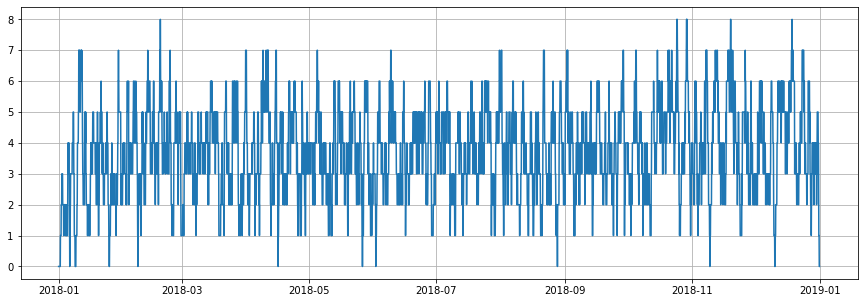

In [82]:
# simultaneidad buques
figure(figsize=(15,5))
plt.plot(sim_ships.iloc[:,4:].sum())
plt.grid(True)

(array([0.0078339 , 0.05856164, 0.15757705, 0.26596747, 0.29755993,
        0.21061644, 0.09850171, 0.02607021, 0.00231164]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <a list of 9 Patch objects>)

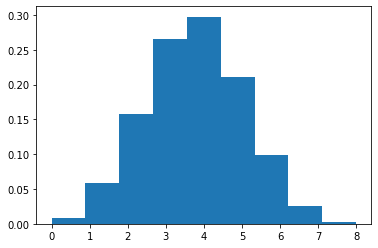

In [84]:
x = sim_ships.iloc[:,4:].sum()

plt.hist(x=x,bins=9,density=True)

## Valencia

### Cruceros

In [85]:
escalas_VESSEL.columns

Index(['Id.Escala', 'Buque', 'Tipo Buque', 'Entrada a puerto',
       'Salida de Puerto', 'Suma tiempo amarres (horas)', 'IMO', 'VesselName',
       'DWT', 'GT', 'TEU', 'ReeferTEU', 'Main/Auxiliary', 'EngineName',
       'PowerPerEngine'],
      dtype='object')

In [103]:
cruise = escalas_VESSEL[escalas_VESSEL['Tipo Buque'] == 'CRUCERO TURÍSTICO        ']

In [104]:
cruise['Entrada a puerto'].describe()

count                     194
unique                    193
top       2018-11-19 07:50:00
freq                        2
first     2018-01-10 08:45:00
last      2018-12-31 07:40:00
Name: Entrada a puerto, dtype: object

In [105]:
ini_escala = cruise['Entrada a puerto']
duracion = pd.to_timedelta(cruise['Suma tiempo amarres (horas)'], unit='hour').dt.round('1s')
fin_escala = (ini_escala + duracion).dt.round('1s')
fin_escala = cruise['Salida de Puerto']

In [106]:
cruise.sort_values(by=['Entrada a puerto'])

,Id.Escala,Buque,Tipo Buque,Entrada a puerto,Salida de Puerto,Suma tiempo amarres (horas),IMO,VesselName,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine
197,1 2018 203,VIKING STAR,CRUCERO TURÍSTICO,2018-01-10 08:45:00,2018-01-10 17:45:00,9.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,1 2018 69,MSC ORCHESTRA,CRUCERO TURÍSTICO,2018-01-12 08:45:00,2018-01-12 18:05:00,9.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,1 2018 445,VIKING STAR,CRUCERO TURÍSTICO,2018-01-24 08:45:00,2018-01-24 17:50:00,9.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
644,1 2018 684,VIKING STAR,CRUCERO TURÍSTICO,2018-02-07 09:10:00,2018-02-07 18:20:00,9.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
847,1 2018 899,VIKING STAR,CRUCERO TURÍSTICO,2018-02-21 08:40:00,2018-02-21 18:00:00,9.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,1 2018 6423,MSC SINFONIA,CRUCERO TURÍSTICO,2018-12-20 08:35:00,2018-12-20 18:15:00,9.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6019,1 2018 6571,AIDASOL,CRUCERO TURÍSTICO,2018-12-21 11:20:00,2018-12-21 20:10:00,9.000000,9490040.0,AIDASOL,7892.0,71304.0,0.0,0.0,Main,9_M43C,9000.0
5815,1 2018 6343,VIKING SKY,CRUCERO TURÍSTICO,2018-12-22 08:23:00,2018-12-22 17:35:00,9.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5998,1 2018 6548,AIDAMAR,CRUCERO TURÍSTICO,2018-12-27 08:20:00,2018-12-27 18:10:00,10.000000,9490052.0,AIDAMAR,7757.0,71304.0,0.0,0.0,Main,9_M43C,9000.0


In [107]:
sim_ships = pd.DataFrame(np.zeros(shape=(len(cruise),8760)),index = cruise.index, 
                         columns = pd.date_range('2018-01-01', '2019-01-01', freq='1H', closed='left'))

sim_ships.insert(0, 'ini_escala', ini_escala)
sim_ships.insert(1, 'duracion', duracion)
sim_ships.insert(2, 'fin_escala', fin_escala)
# sim_ships.insert(3,'pot_media',potencia_media)

sim_ships = sim_ships.reset_index(drop=True)
sim_ships

,ini_escala,duracion,fin_escala,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,...,2018-12-31 14:00:00,2018-12-31 15:00:00,2018-12-31 16:00:00,2018-12-31 17:00:00,2018-12-31 18:00:00,2018-12-31 19:00:00,2018-12-31 20:00:00,2018-12-31 21:00:00,2018-12-31 22:00:00,2018-12-31 23:00:00
0,2018-01-12 08:45:00,09:20:00,2018-01-12 18:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-10 08:45:00,09:20:00,2018-01-10 17:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-24 08:45:00,09:05:00,2018-01-24 17:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-02-07 09:10:00,09:20:00,2018-02-07 18:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-02-21 08:40:00,09:25:00,2018-02-21 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,2018-12-14 09:40:00,08:35:00,2018-12-14 18:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,2018-12-22 08:23:00,09:20:00,2018-12-22 17:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191,2018-12-20 08:35:00,09:40:00,2018-12-20 18:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,2018-12-27 08:20:00,10:00:00,2018-12-27 18:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
for i in range(0,len(sim_ships.index)):
    for j in sim_ships.columns.values[3:]:
        if ((j+1) >= sim_ships.ini_escala[i]) & (j < sim_ships.fin_escala[i]): 
            sim_ships.loc[i,j] = 1

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



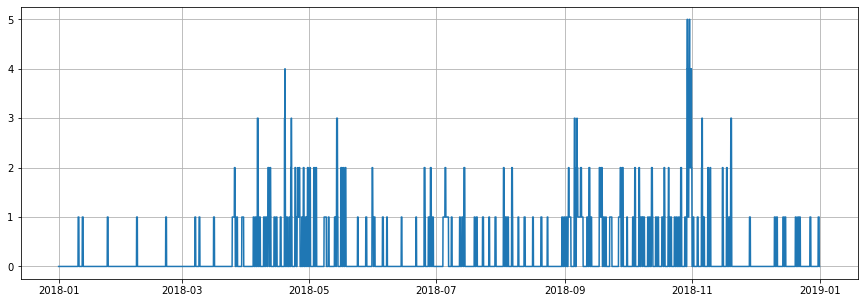

In [109]:
# simultaneidad RoPax Valencia
figure(figsize=(15,5))
plt.plot(sim_ships.iloc[:,3:].sum())
plt.grid(True)

(array([0.79372146, 0.14988584, 0.04589041, 0.00684932, 0.00239726,
        0.00125571]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

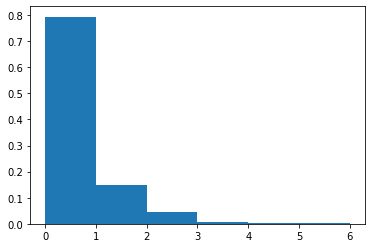

In [139]:
x = sim_ships.iloc[:,3:].sum()

plt.hist(x=x,bins=range(0,7),density=True)

In [130]:
0.79372146+0.14988584+0.04589041+0.00684932+0.00239726+0.00125571

1.0

In [136]:
0.79372146+0.14988584+0.04589041+0.00684932+0.00365297

1.0000000000000002

In [141]:
len(x[x==4])/len(x)

0.002397260273972603

In [183]:
(np.array([0.14988584, 0.04589041, 0.00684932, 0.00239726, 0.00125571])/(1-0.79372146)).cumsum()*100


array([ 72.66186778,  94.90868512,  98.22910808,  99.39125514,
       100.        ])

### RoPax

In [86]:
escalas_VESSEL['Tipo Buque'].unique()

array(['PORTACONTENEDOR          ', 'POLIV. GENERAL CONTENEDOR',
       'RO/RO VEHÍCULO           ', 'MERCANT. CONVENCIONAL    ',
       'RO/RO CONTAINER          ', 'RO/RO  LO/LO             ',
       'CRUCERO TURÍSTICO        ', 'FERRYS RO/RO PASAJEROS   ',
       'PETROLERO REFINADO       ', 'OTROS GRANELEROS         ',
       'CEMENTERO                ', 'RO/RO CARGA GENERAL      ',
       'OTROS TANQUES            ', 'PRODUCTOS QUÍMICOS       ',
       'GRANELERO/CONTENEDOR     ', 'ASFÁLTICO                ',
       'MERCANT. ESPECIAL        ', 'GAS LICUADO              ',
       'OTROS MERCANTES          ', 'OTROS BUQUES             ',
       'CEREALERO                ', 'ACEITEROS                '],
      dtype=object)

In [87]:
ropax = escalas_VESSEL[escalas_VESSEL['Tipo Buque'] == 'FERRYS RO/RO PASAJEROS   ']

In [88]:
ropax['Entrada a puerto'].describe()

count                    1458
unique                   1391
top       2018-10-03 18:50:00
freq                        2
first     2018-01-02 07:53:00
last      2018-12-31 20:45:00
Name: Entrada a puerto, dtype: object

In [142]:
ini_escala = ropax['Entrada a puerto']
duracion = pd.to_timedelta(ropax['Suma tiempo amarres (horas)'], unit='hour').dt.round('1s')
fin_escala = (ini_escala + duracion).dt.round('1s')
fin_escala = ropax['Salida de Puerto']

In [96]:
ropax.sort_values(by=['Entrada a puerto'])

,Id.Escala,Buque,Tipo Buque,Entrada a puerto,Salida de Puerto,Suma tiempo amarres (horas),IMO,VesselName,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine
89,1 2018 86,FORZA,FERRYS RO/RO PASAJEROS,2018-01-02 07:53:00,2018-01-02 23:00:00,15.333333,9458523.0,FORZA,7500.0,25518.0,NaN,NaN,Main,12_V46,12600.0
139,1 2018 139,VISEMAR ONE,FERRYS RO/RO PASAJEROS,2018-01-02 19:00:00,2018-01-02 22:25:00,3.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,1 2018 92,CIUDAD DE IBIZA,FERRYS RO/RO PASAJEROS,2018-01-02 19:00:00,2018-01-02 22:35:00,3.833333,9263370.0,CIUDAD DE IBIZA,7209.0,16686.0,NaN,NaN,Main,12_V46C,12600.0
134,1 2018 134,NAPOLES,FERRYS RO/RO PASAJEROS,2018-01-02 19:30:00,2018-01-02 21:55:00,2.333333,9243423.0,NAPOLES,7500.0,24409.0,0.0,0.0,Main,9_L48/60,9450.0
116,1 2018 115,REGINA BALTICA,FERRYS RO/RO PASAJEROS,2018-01-03 16:35:00,2018-01-04 18:30:00,26.083333,7827225.0,REGINA BALTICA,2830.0,18345.0,0.0,0.0,Main,12_PC2-5V-400,4781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,1 2018 6553,FORZA,FERRYS RO/RO PASAJEROS,2018-12-31 08:01:00,2019-01-01 23:00:00,39.000000,9458523.0,FORZA,7500.0,25518.0,NaN,NaN,Main,12_V46,12600.0
6031,1 2018 6585,REGINA BALTICA,FERRYS RO/RO PASAJEROS,2018-12-31 08:35:00,2019-01-01 18:05:00,33.500000,7827225.0,REGINA BALTICA,2830.0,18345.0,0.0,0.0,Main,12_PC2-5V-400,4781.0
5944,1 2018 6486,ABEL MATUTES,FERRYS RO/RO PASAJEROS,2018-12-31 19:00:00,2019-01-01 21:50:00,26.916667,9441130.0,ABEL MATUTES,5300.0,29670.0,0.0,0.0,Auxiliary,6_M20C,1140.0
6027,1 2018 6581,HEDY LAMARR,FERRYS RO/RO PASAJEROS,2018-12-31 19:30:00,2019-01-01 22:15:00,26.916667,9498743.0,HEDY LAMARR,8702.0,26375.0,0.0,0.0,Main,9_L48/60B,10800.0


In [143]:
sim_ropax = pd.DataFrame(np.zeros(shape=(len(ropax),8760)),index = ropax.index, 
                         columns = pd.date_range('2018-01-01', '2019-01-01', freq='1H', closed='left'))

sim_ropax.insert(0, 'ini_escala', ini_escala)
sim_ropax.insert(1, 'duracion', duracion)
sim_ropax.insert(2, 'fin_escala', fin_escala)
# sim_ropax.insert(3,'pot_media',potencia_media)

sim_ropax = sim_ropax.reset_index(drop=True)
sim_ropax

,ini_escala,duracion,fin_escala,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,...,2018-12-31 14:00:00,2018-12-31 15:00:00,2018-12-31 16:00:00,2018-12-31 17:00:00,2018-12-31 18:00:00,2018-12-31 19:00:00,2018-12-31 20:00:00,2018-12-31 21:00:00,2018-12-31 22:00:00,2018-12-31 23:00:00
0,2018-01-04 08:20:00,0 days 03:50:00,2018-01-04 12:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-02 07:53:00,0 days 15:20:00,2018-01-02 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-01-03 19:25:00,0 days 03:45:00,2018-01-03 23:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-01-04 19:50:00,0 days 03:20:00,2018-01-04 23:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-01-05 19:20:00,0 days 03:45:00,2018-01-05 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2018-12-24 09:25:00,1 days 03:35:00,2018-12-25 13:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1454,2018-12-27 09:20:00,0 days 09:10:00,2018-12-27 18:25:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,2018-12-29 09:25:00,0 days 08:55:00,2018-12-29 18:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,2018-12-31 08:35:00,1 days 09:30:00,2019-01-01 18:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
for i in range(0,len(sim_ropax.index)):
    for j in sim_ropax.columns.values[3:]:
        if ((j+1) >= sim_ropax.ini_escala[i]) & (j < sim_ropax.fin_escala[i]): 
            sim_ropax.loc[i,j] = 1

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



(736695.0, 736726.0)

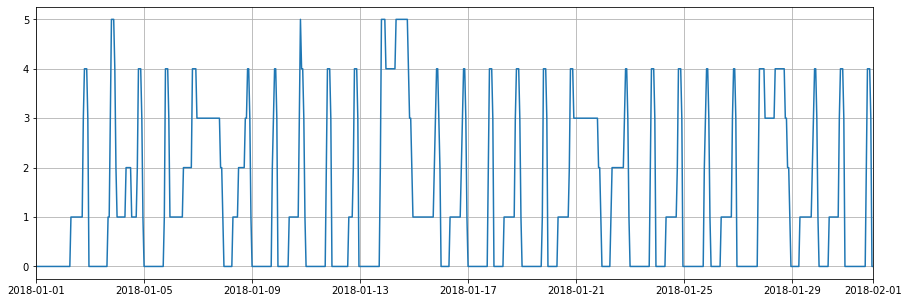

In [185]:
# simultaneidad RoPax Valencia
figure(figsize=(15,5))
plt.plot(sim_ropax.iloc[:,3:].sum())
plt.grid(True)
plt.xlim(['2018-01','2018-02'])


(array([0.42648402, 0.22534247, 0.09406393, 0.12009132, 0.12203196,
        0.0119863 ]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

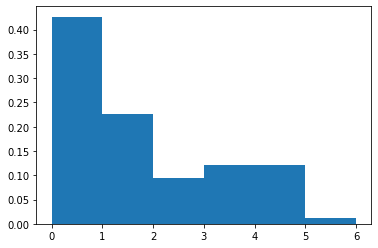

In [154]:
x = sim_ropax.iloc[:,3:].sum()

plt.hist(x=x,bins=range(0,7),density=True)

In [184]:
(np.array([0.22534247, 0.09406393, 0.12009132, 0.12203196,0.0119863])/(1-0.42648402)).cumsum()*100


array([ 39.29140213,  55.6926766 ,  76.63216638,  97.91003208,
       100.        ])

In [156]:
len(x[x==5])/len(x)

0.011986301369863013

In [152]:
x.describe()

count    8760.000000
mean        1.321804
std         1.479079
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max         5.000000
dtype: float64

In [159]:
ropax.describe(include='all')

,Id.Escala,Buque,Tipo Buque,Entrada a puerto,Salida de Puerto,Suma tiempo amarres (horas),IMO,VesselName,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine
count,1458,1458,1458,1458,1458,1458.000000,1.205000e+03,1205,1205.000000,1205.000000,586.0,586.0,1205,1205,1205.000000
unique,1458,15,1,1391,1425,NaN,NaN,11,NaN,NaN,NaN,NaN,2,9,NaN
top,1 2018 2766,FORZA,FERRYS RO/RO PASAJEROS,2018-10-03 18:50:00,2018-12-13 23:15:00,NaN,NaN,FORZA,NaN,NaN,NaN,NaN,Main,12_V46,NaN
freq,1,311,1458,2,2,NaN,NaN,311,NaN,NaN,NaN,NaN,990,311,NaN
first,NaN,NaN,NaN,2018-01-02 07:53:00,2018-01-02 21:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-12-31 20:45:00,2019-01-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.958962,9.126606e+06,NaN,6328.487137,22736.098755,0.0,0.0,NaN,NaN,8931.795021
std,NaN,NaN,NaN,NaN,NaN,7.813490,5.671617e+05,NaN,1761.544922,4877.061373,0.0,0.0,NaN,NaN,4531.617912
min,NaN,NaN,NaN,NaN,NaN,0.250000,7.827225e+06,NaN,340.000000,4662.000000,0.0,0.0,NaN,NaN,1120.000000
25%,NaN,NaN,NaN,NaN,NaN,3.083333,9.261542e+06,NaN,5300.000000,16686.000000,0.0,0.0,NaN,NaN,4781.000000


In [200]:
escalas_VESSEL['Tipo Buque'].unique()

AttributeError: 'numpy.ndarray' object has no attribute 'strip'

In [214]:
print ("-------- Atraques 2018 --------")
print ("-------------------------------")
for each in escalas_VESSEL['Tipo Buque'].unique():
    print(each, len(escalas_VESSEL[escalas_VESSEL['Tipo Buque'] == each]))

-------- Atraques 2018 --------
-------------------------------
PORTACONTENEDOR           3016
POLIV. GENERAL CONTENEDOR 183
RO/RO VEHÍCULO            488
MERCANT. CONVENCIONAL     60
RO/RO CONTAINER           28
RO/RO  LO/LO              138
CRUCERO TURÍSTICO         194
FERRYS RO/RO PASAJEROS    1458
PETROLERO REFINADO        4
OTROS GRANELEROS          54
CEMENTERO                 15
RO/RO CARGA GENERAL       193
OTROS TANQUES             136
PRODUCTOS QUÍMICOS        55
GRANELERO/CONTENEDOR      5
ASFÁLTICO                 10
MERCANT. ESPECIAL         1
GAS LICUADO               1
OTROS MERCANTES           4
OTROS BUQUES              1
CEREALERO                 5
ACEITEROS                 1


In [215]:
423/1458*24

6.962962962962964

In [216]:
75779.77/24

3157.490416666667

In [217]:
10146.17/24

422.75708333333336

In [219]:
%store

Stored variables and their in-db values:


In [220]:
%store escalas_VESSEL

Stored 'escalas_VESSEL' (DataFrame)


In [221]:
escalas_VESSEL

NameError: name 'escalas_VESSEL' is not defined

In [7]:
MSC2018_VESSEL.head()

,Message Date,Vessel,Shore power equipped,Retrofitted,California Commissioned,Segment (TEUs),Port,Country,Consolidated AUX,Consolidated BOILER,...,EndDate,DWT,GT,TEU,ReeferTEU,Main/Auxiliary,EngineName,PowerPerEngine,Sfoc,RetrofiftingYear
0,2018-01-06 02:06:00,VEGA SIGMA,NO,-,-,1100,VALENCIA,SPAIN,1.52,0.69,...,2018-12-31,13689.0,9940.0,1118.0,240.0,Main,7_L58/64,9730.0,176.0,0.0
1,2018-01-03 09:00:00,MSC CAMILLE,YES,-,NO,14000,VALENCIA,SPAIN,10.50,6.50,...,2017-06-01,165644.0,153092.0,14036.0,1000.0,Main,12_K98MC-C,72240.0,165.0,0.0
2,2018-01-04 10:18:00,MSC AJACCIO,YES,-,-,9500,VALENCIA,SPAIN,17.00,6.00,...,2017-06-30,112230.0,94402.0,9403.0,1000.0,Main,9_S90ME-C9,52290.0,162.0,0.0
3,2018-01-04 17:06:00,MSC MELINE,YES,-,-,8500,VALENCIA,SPAIN,19.72,2.60,...,2017-06-30,110029.0,95497.0,8819.0,1462.0,Main,9_S90ME-C10,47430.0,161.5,0.0
4,2018-01-05 14:00:00,E.R. YOKOHAMA,NO,-,-,7500,VALENCIA,SPAIN,15.50,3.90,...,2017-05-01,93659.0,83133.0,7849.0,500.0,Main,12_RTA96C,68640.0,171.0,0.0


# Análisis Buques (17-18-19)

In [217]:
buques['Tipo Buque'].unique()

array(['PORTACONTENEDOR          ', 'POLIV. GENERAL CONTENEDOR',
       'MERCANT. CONVENCIONAL    ', 'RO/RO VEHÍCULO           ',
       'OTROS GRANELEROS         ', 'FERRYS RO/RO PASAJEROS   ',
       'RO/RO  LO/LO             ', 'RO/RO CARGA GENERAL      ',
       'PRODUCTOS QUÍMICOS       ', 'ASFÁLTICO                ',
       'CEMENTERO                ', 'CRUCERO TURÍSTICO        ',
       'PETROLERO REFINADO       ', 'GRANELERO/CONTENEDOR     ',
       'RO/RO CONTAINER          ', 'CEREALERO                ',
       'OTROS PORTACONTENEDORES  ', 'OTROS MERCANTES          ',
       'BUQUE TANQUE/MG          ', 'OTROS DE PASAJE          ',
       'MERCANT. ESPECIAL        ', 'OTROS BUQUES             ',
       'GAS LICUADO              ', 'PETROLERO NO REFINADO    ',
       'ACEITEROS                ', 'OTROS RO/RO              '],
      dtype=object)

In [222]:
ro = buques[
    (buques['Tipo Buque'] == 'FERRYS RO/RO PASAJEROS   ') | (buques['Tipo Buque'] == 'RO/RO VEHÍCULO           ') |
    (buques['Tipo Buque'] == 'RO/RO  LO/LO             ') | (buques['Tipo Buque'] == 'RO/RO CARGA GENERAL      ') |
    (buques['Tipo Buque'] == 'RO/RO CONTAINER          ') | (buques['Tipo Buque'] == 'OTROS RO/RO              ') ]

In [228]:
ro.describe()
ro['Potencia'].describe()

count     7038.000000
mean     25367.514351
std       7883.184698
min       1000.000000
25%      20070.000000
50%      25696.000000
75%      32184.000000
max      45000.000000
Name: Potencia, dtype: float64

In [239]:
año = 2019

In [241]:
ro[ro['Año Servicio'] == año].describe()

,Año Servicio,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25
count,2330.0,2330.000000,2330.000000,0.0,2330.000000,2330.000000,2330.000000,2324.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,2019.0,28062.801288,1.062232,NaN,26077.405579,1531.604721,1511.723176,12.440706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.0,10471.401969,0.354070,NaN,8321.208884,568.885429,566.424765,53.488513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2019.0,6554.000000,1.000000,NaN,1600.000000,5.000000,0.000000,-0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2019.0,18345.000000,1.000000,NaN,20070.000000,1000.000000,945.000000,3.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2019.0,26375.000000,1.000000,NaN,27638.000000,1855.000000,1845.000000,6.458333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2019.0,32645.000000,1.000000,NaN,32184.000000,1930.000000,1920.000000,13.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2019.0,76420.000000,8.000000,NaN,45000.000000,2359.000000,2355.000000,1926.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Portacontenedores

### MSC

#### Descripción general

In [47]:
MSC2018_IHS.TotalPower.describe()

count     1119.000000
mean     39675.884718
std      22381.522944
min       6930.000000
25%      10400.000000
50%      41145.000000
75%      57100.000000
max      74760.000000
Name: TotalPower, dtype: float64

In [48]:
# MSC2018_IHS.rename(columns={'Unnamed: 21':'Factor_carga'}, inplace=True)
MSC2018_IHS.columns

Index(['Message Date', 'Vessel', 'Shore power equipped', 'Retrofitted',
       'California Commissioned', 'Segment (TEUs)', 'Port', 'Country',
       'Consolidated AUX', 'Consolidated BOILER', 'Estimated Power',
       'Consumo quitando tiempo de conexión/desconexión', 'Average Power',
       'Consolidated Port Stay (Hours)', 'LOA', 'IMO',
       'Fecha escala en Business Objects',
       'Duración amarrado en Business Objects',
       'Duración fondeado en Business Objects', 'Average Power (OPS)',
       'Muelle', 'Factor_carga', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'TotalPower', 'GT'],
      dtype='object')

In [332]:
MSC2018_IHS[['Vessel','Estimated Power','Average Power (OPS)','Total KW Main Eng','Reefer Points']]

,Vessel,Estimated Power,Average Power (OPS),Total KW Main Eng,Reefer Points
0,VEGA SIGMA,6909.090909,275.445485,9730.0,220.0
1,MSC CAMILLE,47727.272727,1735.537190,72240.0,1000.0
2,MSC AJACCIO,77272.727273,1923.802339,52290.0,1400.0
3,MSC MELINE,89636.363636,3309.650350,47430.0,1462.0
4,E.R. YOKOHAMA,70454.545455,3226.925746,68640.0,500.0
...,...,...,...,...,...
1114,MSC JOANNA,32818.181818,1168.599946,68520.0,700.0
1115,MSC DYMPHNA,29545.454545,1322.930801,54814.0,390.0
1116,MSC RACHELE,36363.636364,1781.076067,68666.0,700.0
1117,MSC DON GIOVANNI,5954.545455,567.099567,16860.0,180.0


NameError: name 'ree' is not defined

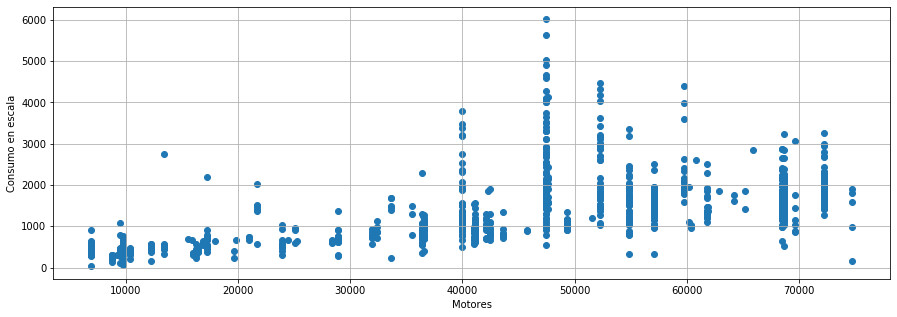

In [49]:
#ree = MSC2018_IHS['Reefer Points']
pot = MSC2018_IHS['Average Power (OPS)']
#f_car = MSC2018_IHS['Factor_carga']
#gt = MSC2018_IHS['GT']
#teu = MSC2018_IHS['TEU']
engine = MSC2018_IHS['TotalPower']

fig = figure(figsize=(15,5))
plt.scatter(engine, pot)
plt.grid(True)
plt.xlabel('Motores')
plt.ylabel('Consumo en escala')
# plt.ylim([0,100])

del ree, pot, f_car, gt, teu, engine

In [80]:
ree[ree.isna()==True]

371    NaN
498    NaN
632    NaN
735    NaN
810    NaN
898    NaN
992    NaN
1110   NaN
Name: Reefer Points, dtype: float64

In [82]:
MSC2018_IHS.columns

Index(['Message Date', 'Vessel', 'Shore power equipped', 'Retrofitted',
       'California Commissioned', 'Segment (TEUs)', 'Port', 'Country',
       'Consolidated AUX', 'Consolidated BOILER', 'Estimated Power',
       'Consumo quitando tiempo de conexión/desconexión', 'Average Power',
       'Consolidated Port Stay (Hours)', 'LOA', 'IMO',
       'Fecha escala en Business Objects',
       'Duración amarrado en Business Objects',
       'Duración fondeado en Business Objects', 'Average Power (OPS)',
       'Muelle', 'Factor_carga', 'IMO/LR/IHS No.', 'Name of Ship', 'Ship Type',
       'GT', 'Service Speed', 'Total KW Main Eng', 'Aux. Engine Model',
       'Aux. Engine Total KW', 'Year', 'Reefer Points', 'TEU'],
      dtype='object')

In [453]:
MSC2018_IHS.corr().round(2)

,Segment (TEUs),Consolidated AUX,Consolidated BOILER,Estimated Power,Consumo quitando tiempo de conexión/desconexión,Consolidated Port Stay (Hours),IMO,Amarre calculado (horas),Potencia_kW,Factor_carga,Unnamed: 22,IMO/LR/IHS No.,GT,Service Speed,Total KW Main Eng,Aux. Engine Total KW,Year,Reefer Points,TEU
Segment (TEUs),1.00,0.73,0.66,0.73,0.73,0.07,0.53,0.14,0.74,NaN,-0.30,0.53,1.00,0.63,0.89,0.89,0.54,0.80,1.00
Consolidated AUX,0.73,1.00,0.76,1.00,1.00,0.42,0.46,0.43,0.84,NaN,-0.42,0.46,0.74,0.43,0.65,0.73,0.45,0.72,0.74
Consolidated BOILER,0.66,0.76,1.00,0.76,0.76,0.50,0.21,0.52,0.50,NaN,-0.11,0.21,0.68,0.53,0.65,0.57,0.22,0.48,0.67
Estimated Power,0.73,1.00,0.76,1.00,1.00,0.42,0.46,0.43,0.84,NaN,-0.42,0.46,0.74,0.43,0.65,0.73,0.45,0.72,0.74
Consumo quitando tiempo de conexión/desconexión,0.73,1.00,0.76,1.00,1.00,0.43,0.46,0.45,0.83,NaN,-0.41,0.46,0.73,0.43,0.64,0.72,0.45,0.71,0.74
Consolidated Port Stay (Hours),0.07,0.42,0.50,0.42,0.43,1.00,-0.01,0.92,0.05,NaN,0.30,-0.01,0.08,-0.02,0.02,0.06,-0.02,0.07,0.08
IMO,0.53,0.46,0.21,0.46,0.46,-0.01,1.00,0.00,0.51,NaN,-0.37,1.00,0.51,0.09,0.32,0.69,0.97,0.72,0.54
Amarre calculado (horas),0.14,0.43,0.52,0.43,0.45,0.92,0.00,1.00,0.04,NaN,0.29,0.00,0.14,0.02,0.09,0.10,-0.01,0.11,0.14
Potencia_kW,0.74,0.84,0.50,0.84,0.83,0.05,0.51,0.04,1.00,NaN,-0.64,0.51,0.74,0.49,0.69,0.77,0.49,0.76,0.74
Factor_carga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
MSC2018_IHS['Average Power (OPS)']

0        275.445485
1       1735.537190
2       1923.802339
3       3309.650350
4       3226.925746
           ...     
1114    1168.599946
1115    1322.930801
1116    1781.076067
1117     567.099567
1118     908.268202
Name: Average Power (OPS), Length: 1119, dtype: float64

no stored variable MSC2018_IHS
no stored variable MSC_2018


In [16]:
MSC2018_IHS.TotalPower.describe()

count     1119.000000
mean     39675.884718
std      22381.522944
min       6930.000000
25%      10400.000000
50%      41145.000000
75%      57100.000000
max      74760.000000
Name: TotalPower, dtype: float64

In [50]:
bins =[0,20000,40000,60000,80000]
bins =[0,10000,20000,30000,40000,50000,60000,70000,80000]

MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()

,Segment (TEUs),Consolidated AUX,Consolidated BOILER,Estimated Power,Consumo quitando tiempo de conexión/desconexión,Consolidated Port Stay (Hours),IMO,Duración amarrado en Business Objects,Average Power (OPS),Factor_carga,Unnamed: 22,TotalPower,GT
TotalPower,,,,,,,,,,,,,
"(0, 10000]",1069.144981,1.819405,0.869368,8270.023657,7799.928494,27.954337,9.269456e+06,26.337423,313.396775,NaN,24.0,9369.033457,10042.855019
"(10000, 20000]",1895.454545,3.760606,2.215455,17093.663912,16292.079986,36.127273,9.123105e+06,34.689394,534.389284,NaN,NaN,14428.878788,22893.469697
"(20000, 30000]",2967.391304,4.428043,2.056087,20127.470356,18975.354293,28.842754,9.215993e+06,26.731884,768.077375,NaN,42.0,25783.065217,31512.891304
"(30000, 40000]",4996.212121,6.127955,3.084015,27854.338843,26073.143229,23.952904,9.317713e+06,24.089646,1187.463743,NaN,30.0,37513.090909,49183.765152
"(40000, 50000]",6851.485149,10.033861,4.105149,45608.460846,43133.018686,27.974670,9.415932e+06,27.455858,1650.294773,NaN,0.0,45121.950495,75909.242574
"(50000, 60000]",8890.243902,12.053841,5.205549,54790.188470,52023.803658,30.193293,9.471625e+06,29.780996,1844.256541,NaN,36.0,55443.865854,94946.969512
"(60000, 70000]",8694.444444,10.813086,5.597222,49150.392817,46631.084680,28.301235,9.309035e+06,29.014815,1679.538758,NaN,15.0,67482.975309,94687.611111
"(70000, 80000]",13608.974359,14.244103,6.751795,64745.920746,61859.767129,33.311752,9.440228e+06,34.162393,1924.102411,NaN,NaN,72401.538462,148518.500000


(array([269.,  66.,  46., 132., 202., 164., 162.,  78.]),
 array([    0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000]),
 <a list of 8 Patch objects>)

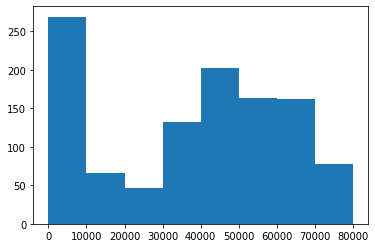

In [52]:
plt.hist(MSC2018_IHS['TotalPower'],
        bins=[0,10000,20000,30000,40000,50000,60000,70000,80000])

In [53]:
len(MSC2018_IHS) - np.array([269.,  66.,  46., 132., 202., 164., 162.,  78.]).sum() 

0.0

#### Simultaneidad y potencia acumulada

In [8]:
MSC_2018 = MSC2018_IHS

In [9]:
# Clasificación escalas por muelle y por tipo de buque

for each1 in MSC_2018.Muelle.unique(): 
    print(str(each1) + ' ' +(str(len(MSC_2018[MSC_2018.Muelle==each1]))))
    

PRINCIPE FELIPE           581
TRANSVERSAL COSTA         447
MUELLE DE COSTA           91


In [10]:
MSC_2018.rename(columns={'Fecha escala en Business Objects':'FH. Amarre Calc'}, inplace=True)
MSC_2018.rename(columns={'Duración amarrado en Business Objects':'Amarre calculado (horas)'}, inplace=True)
MSC_2018.rename(columns={'Average Power (OPS)':'Potencia_kW'}, inplace=True)

In [11]:
MSC_2018.columns

Index(['Message Date', 'Vessel', 'Shore power equipped', 'Retrofitted',
       'California Commissioned', 'Segment (TEUs)', 'Port', 'Country',
       'Consolidated AUX', 'Consolidated BOILER', 'Estimated Power',
       'Consumo quitando tiempo de conexión/desconexión', 'Average Power',
       'Consolidated Port Stay (Hours)', 'LOA', 'IMO', 'FH. Amarre Calc',
       'Amarre calculado (horas)', 'Duración fondeado en Business Objects',
       'Potencia_kW', 'Muelle', 'Factor_carga', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'TotalPower', 'GT'],
      dtype='object')

In [12]:
desamarre = MSC_2018['FH. Amarre Calc'] + pd.to_timedelta(MSC_2018['Amarre calculado (horas)'], 
                                                          unit='hour').dt.round('1s')

In [13]:
MSC_2018.insert(18, "FH. Desamarre Calc", desamarre, True)

In [14]:
MSC_2018.Potencia_kW.describe()

count    1119.000000
mean     1223.979519
std       878.858269
min        28.092080
25%       452.127660
50%      1090.909091
75%      1729.490022
max      6007.248565
Name: Potencia_kW, dtype: float64

In [15]:
dfIN = MSC_2018[['FH. Amarre Calc','Potencia_kW']]
dfOUT = MSC_2018[['FH. Desamarre Calc','Potencia_kW']]
dfIN['direction'] = 1
dfOUT['direction'] = -1

2020-11-10 09:40:40,271 [3224] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until

2020-11-10 09:40:40,282 [3224] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after

In [16]:
dfIN.columns = ('TS','pot_media','direction')
dfOUT.columns = ('TS','pot_media','direction')

In [17]:
traffic_MSC_2018 = pd.concat([dfIN, dfOUT]).sort_values('TS')

In [18]:
traffic_MSC_2018.pot_media = traffic_MSC_2018.pot_media*traffic_MSC_2018.direction

In [19]:
traffic_MSC_2018['ships'] = traffic_MSC_2018['direction'].cumsum()
traffic_MSC_2018['cum_pot'] = traffic_MSC_2018['pot_media'].cumsum()

In [20]:
traffic_MSC_2018 = traffic_MSC_2018.round()

(array(17532.), array(17897.))

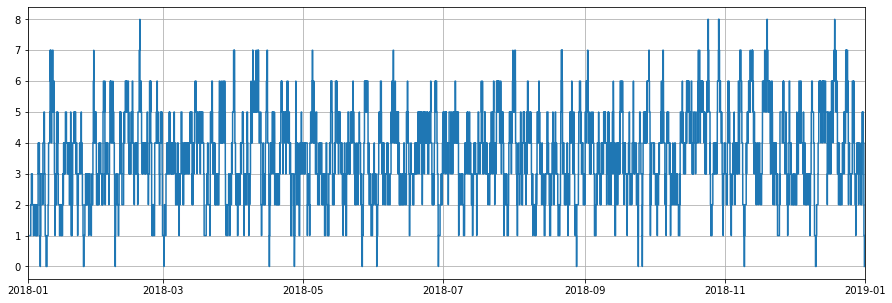

In [21]:
figure(figsize=(15,5))

plt.step(traffic_MSC_2018.TS,traffic_MSC_2018.ships, where='post')
plt.grid(True)
plt.xlim(['2018-01-01','2019-01-01'])
# plt.xlim(['2018-09-24 00','2018-09-24 12'])


In [22]:
traffic_MSC_2018[traffic_MSC_2018.TS=='2018-03-01 08:35:00']

,TS,pot_media,direction,ships,cum_pot
167,2018-03-01 08:35:00,755.0,1,1,755.0


(array(17532.), array(17897.))

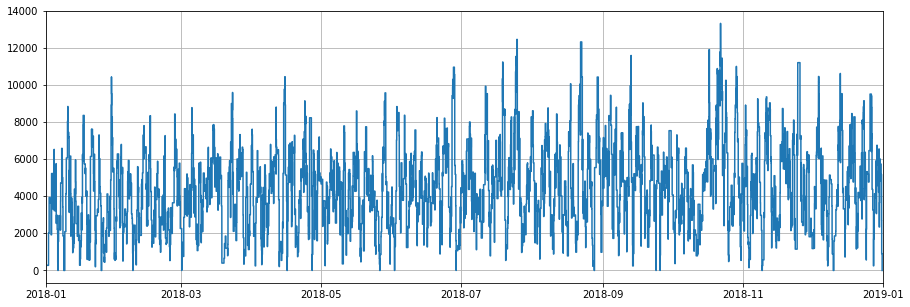

In [23]:
a = figure(figsize=(15,5))

plt.step(traffic_MSC_2018.TS,traffic_MSC_2018.cum_pot, where='post')
plt.grid(True)
plt.xlim(['2018-01-01','2019-01-01'])

# plt.xlim(['2019-01-01','2019-12-13'])
# plt.xlim(['2017-01-20 18','2017-01-20 22'])
# plt.ylim([10000,30000])

In [ ]:
# --------------------------#

# Ejercicio de cálculo de cobertura energética para naviera MSC

In [24]:
traffic_MSC_2018.reset_index(inplace=True)

In [37]:
traffic_MSC_2018

,index,TS,pot_media,direction,ships,cum_pot,coverage
0,0,2018-01-01 20:48:00,275.0,1,1,275.0,
1,1,2018-01-02 05:28:00,1736.0,1,2,2011.0,
2,2,2018-01-02 12:03:00,1924.0,1,3,3935.0,
3,0,2018-01-02 21:53:00,-275.0,-1,2,3659.0,
4,1,2018-01-03 08:58:00,-1736.0,-1,1,1924.0,
...,...,...,...,...,...,...,...
2233,1117,2018-12-31 06:34:00,-567.0,-1,4,5181.0,
2234,1114,2018-12-31 11:59:00,-1169.0,-1,3,4012.0,
2235,1115,2018-12-31 12:54:00,-1323.0,-1,2,2689.0,
2236,1116,2018-12-31 13:28:00,-1781.0,-1,1,908.0,


In [40]:
# number of stopovers with full, partial or no energy coverage

installed_power = 7500

dir_1 = (traffic_MSC_2018.direction==1)   #
greater = (traffic_MSC_2018.cum_pot>installed_power) # greater than 7.5
smaller = (traffic_MSC_2018.cum_pot<=installed_power)# 7.5 or less

traffic_MSC_2018['coverage'][dir_1 & smaller] = 'full'
traffic_MSC_2018['coverage'][dir_1 & greater & (traffic_MSC_2018.cum_pot.shift()<installed_power)] = 'partial'
traffic_MSC_2018['coverage'][dir_1 & greater & (traffic_MSC_2018.cum_pot.shift()>=installed_power)] = 'none'
    #traffic_MSC_2018.coverage[dir_1 & greater & 
     #                         (traffic_MSC_2018.cum_pot[traffic_MSC_2018.index == (index-1)]>=installed_power) &
      #                       (traffic_MSC_2018.index==index)] = 'none'

2020-11-10 18:19:07,316 [3224] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':

2020-11-10 18:19:07,327 [3224] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.

2020-11-10 18:19:07,336 [3224] WARNING  py.warnings:110: [JupyterRequire] C:\Users\badria\AppData\Local\Continuum\anac

In [48]:
traffic_MSC_2018['coverage']

0       full
1       full
2       full
3           
4           
        ... 
2233        
2234        
2235        
2236        
2237        
Name: coverage, Length: 2238, dtype: object

In [52]:
len(traffic_MSC_2018[dir_1 & (traffic_MSC_2018['coverage'] == 'partial')])*100/len(traffic_MSC_2018[dir_1])

8.757819481680071

In [74]:
# milisegundos para evitar duplicados en las time series

traffic_MSC_2018.TS = traffic_MSC_2018.TS + pd.to_timedelta(traffic_MSC_2018.groupby('TS').cumcount(), unit='ms')

In [75]:
traffic_MSC_2018.TS.is_unique

True

In [76]:
print(len(traffic_MSC_2018[traffic_MSC_2018.TS.duplicated()==True]))

0


In [77]:
traffic_MSC_2018 = traffic_MSC_2018.set_index('TS')#.resample('h')

In [78]:
### ---------------------------------------------------------- ###
### función que da el valor acumulado de potencias por horas
### ---------------------------------------------------------- ###

traffic_MSC_2018.resample('1H').ffill().fillna(0).head(10)#.groupby('TS').sum()

,pot_media,direction,ships,cum_pot
TS,,,,
2018-01-01 20:00:00,0.0,0.0,0.0,0.0
2018-01-01 21:00:00,275.0,1.0,1.0,275.0
2018-01-01 22:00:00,275.0,1.0,1.0,275.0
2018-01-01 23:00:00,275.0,1.0,1.0,275.0
2018-01-02 00:00:00,275.0,1.0,1.0,275.0
2018-01-02 01:00:00,275.0,1.0,1.0,275.0
2018-01-02 02:00:00,275.0,1.0,1.0,275.0
2018-01-02 03:00:00,275.0,1.0,1.0,275.0
2018-01-02 04:00:00,275.0,1.0,1.0,275.0


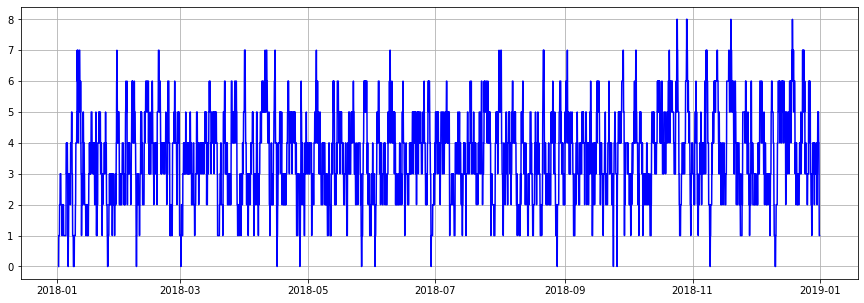

In [79]:
a = figure(figsize=(15,5))

x = traffic_MSC_2018.resample('1H').ffill().index
y = traffic_MSC_2018.resample('1H').ffill().fillna(0).ships

plt.plot(x,y,'b')
plt.grid(True)
# plt.xlim(['2019-12-10','2019-12-13'])
# plt.xlim(['2019-01-01','2019-12-13'])

(array([0.00595306, 0.06021752, 0.15775615, 0.24384659, 0.26227819,
        0.17515741, 0.07521465, 0.01820263, 0.00137378]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Patch objects>)

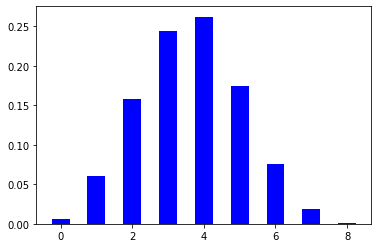

In [80]:
x = traffic_MSC_2018.resample('1H').ffill().fillna(0).ships

plt.hist(x=x,bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],density=True, rwidth=0.5, color='b')
# plt.grid(True)

In [356]:
np.sum([0.00595306, 0.06021752, 0.15775615, 0.24384659, 0.26227819, 0.17515741, 0.07521465, 0.01820263, 0.00137378])

0.9999999800000001

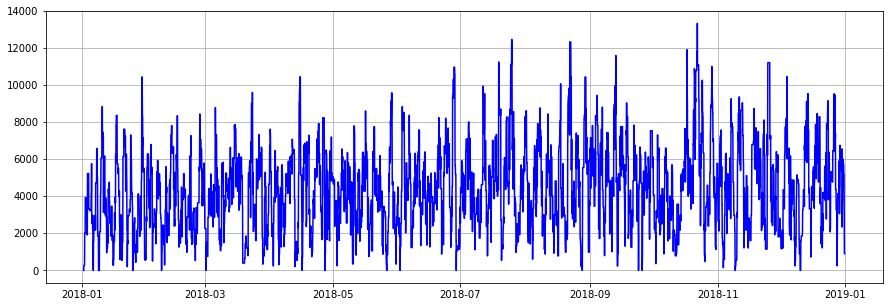

In [81]:
a = figure(figsize=(15,5))

x = traffic_MSC_2018.resample('1H').ffill().index
y = traffic_MSC_2018.resample('1H').ffill().fillna(0).cum_pot

plt.plot(x,y,'b')
plt.grid(True)
# plt.xlim(['2019-12-10','2019-12-13'])
# plt.xlim(['2019-01-01','2019-12-13'])

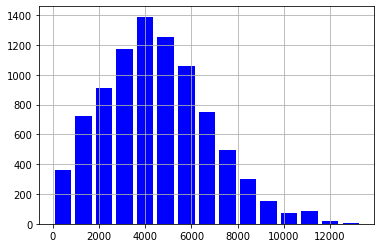

In [82]:
x = traffic_MSC_2018.resample('1H').ffill().fillna(0).cum_pot

plt.hist(x=x,bins=15, rwidth= 0.8, color='b')
plt.grid(True)

In [83]:
print('Power MSC_2018')
print('-------------------')
# print('\n')
print(str(round(len(x[x==0])*100/len(x),2)) + ' % del tiempo sin cruceros atracados')
print(str(round(len(x[(x>0) & (x<=2000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1 y 2000 kW')
print(str(round(len(x[(x>2000) & (x<=4000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 2000 y 4000 kW')
print(str(round(len(x[(x>4000) & (x<=6000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 4000 y 6000 kW')
print(str(round(len(x[(x>6000) & (x<=8000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 6000 y 8000 kW')
print(str(round(len(x[(x>8000) & (x<=10000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 8000 y 10000 kW')
print(str(round(len(x[(x>10000) & (x<=12000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 10000 y 12000 kW')
print(str(round(len(x[x>12000])*100/len(x),2)) + ' % de horas con pot acumulada mayor de 12000 kW')

# print('-------------------')
# print('Considerando solo el tiempo que hay al menos un crucero:')
# print(str(round(len(x[(x>0) & (x<=500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1 y 500 kW')
# print(str(round(len(x[(x>500) & (x<=1000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 500 y 1000 kW')
# print(str(round(len(x[(x>1000) & (x<=1500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1000 y 1500 kW')
# print(str(round(len(x[(x>1500) & (x<=2000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1500 y 2000 kW')
# print(str(round(len(x[x>2000])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada mayor de 2000 kW')

Power MSC_2018
-------------------
0.6 % del tiempo sin cruceros atracados
14.21 % de horas con pot acumulada entre 1 y 2000 kW
29.07 % de horas con pot acumulada entre 2000 y 4000 kW
31.7 % de horas con pot acumulada entre 4000 y 6000 kW
17.15 % de horas con pot acumulada entre 6000 y 8000 kW
5.4 % de horas con pot acumulada entre 8000 y 10000 kW
1.66 % de horas con pot acumulada entre 10000 y 12000 kW
0.22 % de horas con pot acumulada mayor de 12000 kW


In [ ]:
x[x<100]

In [84]:
traffic_MSC_2018.resample('1H').ffill().fillna(0).cum_pot

TS
2018-01-01 20:00:00      0.0
2018-01-01 21:00:00    275.0
2018-01-01 22:00:00    275.0
2018-01-01 23:00:00    275.0
2018-01-02 00:00:00    275.0
                       ...  
2018-12-31 14:00:00    908.0
2018-12-31 15:00:00    908.0
2018-12-31 16:00:00    908.0
2018-12-31 17:00:00    908.0
2018-12-31 18:00:00    908.0
Freq: H, Name: cum_pot, Length: 8735, dtype: float64

In [361]:
traffic_MSC_2018.tail(11)

,pot_media,direction,ships,cum_pot
TS,,,,
2018-12-30 11:36:00,-2188.0,-1,2,2345.0
2018-12-30 14:34:00,1323.0,1,3,3668.0
2018-12-30 17:03:00,1781.0,1,4,5449.0
2018-12-30 20:04:00,567.0,1,5,6016.0
2018-12-30 22:23:00,-1176.0,-1,4,4840.0
2018-12-30 23:37:00,908.0,1,5,5748.0
2018-12-31 06:34:00,-567.0,-1,4,5181.0
2018-12-31 11:59:00,-1169.0,-1,3,4012.0
2018-12-31 12:54:00,-1323.0,-1,2,2689.0


In [362]:
traffic_MSC_2018.head(8)

,pot_media,direction,ships,cum_pot
TS,,,,
2018-01-01 20:48:00,275.0,1,1,275.0
2018-01-02 05:28:00,1736.0,1,2,2011.0
2018-01-02 12:03:00,1924.0,1,3,3935.0
2018-01-02 21:53:00,-275.0,-1,2,3659.0
2018-01-03 08:58:00,-1736.0,-1,1,1924.0
2018-01-03 13:37:00,3310.0,1,2,5233.0
2018-01-04 04:13:00,-1924.0,-1,1,3310.0
2018-01-04 16:15:00,3227.0,1,2,6537.0


In [ ]:
traffic_MSC_2018['TS',]

In [363]:
sim = pd.concat([traffic_MSC_2018.resample('1H').ffill().fillna(0).ships,
                 traffic_MSC_2018.resample('1H').ffill().fillna(0).cum_pot], axis=1)
sim.to_excel("sim_MSC_2018.xlsx")

In [60]:
MSC_2018.Potencia_kW

0        275.445485
1       1735.537190
2       1923.802339
3       3309.650350
4       3226.925746
           ...     
1114    1168.599946
1115    1322.930801
1116    1781.076067
1117     567.099567
1118     908.268202
Name: Potencia_kW, Length: 1119, dtype: float64

### Todos los portacontenedores

In [76]:
%store -r buques_vessl_ihs

In [79]:
buques_vessl_ihs.Potencia.count()

19845

In [80]:
contenedor = (buques_vessl_ihs.buque_def=='contenedor')
buques_vessl_ihs[contenedor].describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,IMO,TotalPower,GT
count,11780.000000,1.178000e+04,11780.000000,11780.000000,0.0,11780.000000,11780.000000,11780.000000,11780.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.150000e+04,11500.000000,11500.000000
mean,2017.971307,9.321783e+06,44504.040068,1.351783,NaN,29940.462818,1156.725722,1140.005942,20.188473,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.323190e+06,30521.039217,45399.576609
std,0.814708,1.893715e+05,40637.699821,0.642881,NaN,22174.151804,682.097658,683.223289,11.939128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.881273e+05,22091.014291,40657.373562
min,2017.000000,7.810222e+06,998.000000,1.000000,NaN,600.000000,0.000000,0.000000,1.583333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,8.201648e+06,2942.000000,2906.000000
25%,2017.000000,9.210074e+06,9957.000000,1.000000,NaN,9730.000000,625.000000,610.000000,12.833333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.210098e+06,9730.000000,9957.000000
50%,2018.000000,9.316347e+06,27915.000000,1.000000,NaN,24880.000000,1210.000000,1200.000000,18.041667,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.316347e+06,25228.000000,30051.000000
75%,2019.000000,9.403440e+06,72884.000000,2.000000,NaN,47430.000000,1755.000000,1745.000000,24.500000,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.403463e+06,47600.000000,73819.000000
max,2019.000000,9.842097e+06,194849.000000,6.000000,NaN,80905.000000,2359.000000,2355.000000,236.833333,5015400.0,NaN,5015400.0,11480.0,NaN,447720.0,NaN,NaN,9.842097e+06,80905.000000,194849.000000


In [37]:
# PRE PROCESSING
# cuando no tenemos Total KW Main Eng (619 de 11583), asignamos a esa columna el valor de Potencia 
# ------------------------------------------------------------------------------------------------#

cont_ihs['Total KW Main Eng'][cont_ihs['Total KW Main Eng'].isna()==True
                       ] = cont_ihs.Potencia[cont_ihs['Total KW Main Eng'].isna()==True]

In [87]:
cont_ihs.head()

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Ship Type,GT,Service Speed,Total KW Main Eng,Aux. Engine Model,Aux. Engine Total KW,Year,Reefer Points,TEU,Potencia_kW
0,2017,1 2016 6487,9356309,CMA CGM HYDRA,PORTACONTENEDOR,128600,1,NaN,98218,LLOVERA,...,Container Ship (Fully Cellular),128600.0,24.3,72240.0,NaN,NaN,2009.0,700.0,11040.0,1924.1
1,2017,1 2016 6632,9509138,FLEUR N,PORTACONTENEDOR,35887,1,NaN,34044,LEVANTE 1,...,Container Ship (Fully Cellular),35887.0,22.3,25040.0,8L28/32H,1980.0,2012.0,540.0,2758.0,671.742
2,2017,1 2016 6635,9449118,MARTHA SCHULTE,PORTACONTENEDOR,38364,1,NaN,43494,LEVANTE 3,...,Container Ship (Fully Cellular),38364.0,23.0,31990.0,7H25/33,2100.0,2012.0,550.0,3635.0,1190.09
3,2017,1 2016 6674,9230490,MSC LORETTA,PORTACONTENEDOR,73819,1,NaN,12000,PRINCIPE FELIPE,...,Container Ship (Fully Cellular),73819.0,24.0,57075.0,8L27/38,2200.0,2002.0,400.0,6402.0,1844.26
4,2017,1 2016 6681,9007817,MSC NAMIBIA II,PORTACONTENEDOR,23953,1,NaN,14400,PRINCIPE FELIPE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.397


#### Descripción general

In [39]:
cont_ihs.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'IMO/LR/IHS No.', 'Name of Ship', 'Ship Type', 'GT', 'Service Speed',
       'Total KW Main Eng', 'Aux. Engine Model', 'Aux. Engine Total KW',
       'Year', 'Reefer Points', 'TEU', 'Potencia_kW'],
      dtype='object')

In [40]:
cont_ihs['Total KW Main Eng'].describe()
# len(cont_ihs['Total KW Main Eng'].isna())
cont_ihs[cont_ihs['Total KW Main Eng'].isna() == False].describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),IMO/LR/IHS No.,GT,Service Speed,Total KW Main Eng,Aux. Engine Total KW,Year,Reefer Points,TEU
count,11583.000000,1.158300e+04,11583.000000,11583.000000,0.0,11583.000000,11583.000000,11583.000000,11583.000000,1.096400e+04,10964.000000,10964.000000,11583.000000,10240.000000,10964.000000,10964.000000,10964.000000
mean,2017.969611,9.322864e+06,45141.950186,1.355694,NaN,36915.552879,1155.238798,1138.238885,19.653878,9.334644e+06,47221.445093,21.446149,30398.839679,1920.322363,2005.277271,493.671379,4389.200657
std,0.815331,1.879050e+05,40615.743488,0.645946,NaN,29452.251352,680.790576,681.899863,10.179127,1.768258e+05,40729.961451,2.931905,22088.327159,1191.571487,5.953919,359.927506,3738.667591
min,2017.000000,8.201648e+06,2415.000000,1.000000,NaN,54.000000,0.000000,0.000000,1.583333,8.201648e+06,2906.000000,14.000000,1160.000000,0.000000,1982.000000,40.000000,340.000000
25%,2017.000000,9.210086e+06,9957.000000,1.000000,NaN,12000.000000,625.000000,610.000000,12.750000,9.226504e+06,9962.000000,19.400000,9730.000000,700.000000,2001.000000,220.000000,1118.000000
50%,2018.000000,9.316347e+06,29181.000000,1.000000,NaN,29313.000000,1210.000000,1200.000000,17.916667,9.320447e+06,35708.000000,22.000000,25040.000000,1800.000000,2006.000000,400.000000,3091.000000
75%,2019.000000,9.403437e+06,73819.000000,2.000000,NaN,58274.000000,1755.000000,1745.000000,24.250000,9.406635e+06,74656.000000,24.000000,47430.000000,2720.000000,2009.000000,656.000000,6648.000000
max,2019.000000,9.842097e+06,194849.000000,6.000000,NaN,114239.000000,2359.000000,2355.000000,103.250000,9.842097e+06,194849.000000,26.500000,80905.000000,4500.000000,2019.000000,1800.000000,19472.000000


In [42]:
cont_ihs.Potencia_kW.astype("int64").describe()

count    11583.000000
mean       968.069930
std        635.063107
min        313.000000
25%        313.000000
50%        671.000000
75%       1680.000000
max       1924.000000
Name: Potencia_kW, dtype: float64

In [97]:
%store -r cont_ihs

In [101]:
print(cont_ihs.Potencia_kW.astype('float').describe())
print(buques_vessl_ihs[contenedor].Potencia_kW.astype('float').describe())

count    11583.000000
mean       968.485782
std        635.037363
min        313.396775
25%        313.396775
50%        671.742100
75%       1680.596446
max       1924.102411
Name: Potencia_kW, dtype: float64
count    11780.000000
mean       968.683785
std        625.556910
min        313.396775
25%        313.396775
50%        768.077375
75%       1650.294773
max       1924.102411
Name: Potencia_kW, dtype: float64


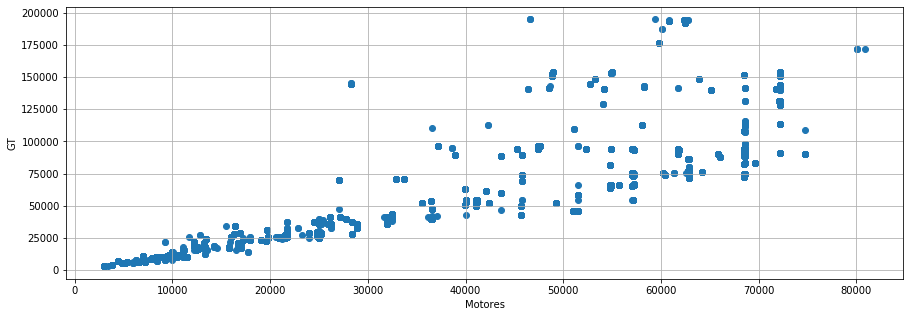

In [123]:

pot = MSC2018_IHS['Average Power (OPS)']
f_car = MSC2018_IHS['Factor_carga']
gt = contenedores['Det. G.T. Buque']
# teu = MSC2018_IHS['TEU']
engine = contenedores['Potencia']
m_engine = cont_ihs['Total KW Main Eng']

fig = figure(figsize=(15,5))
plt.scatter(m_engine, gt)
plt.grid(True)
plt.xlabel('Motores')
plt.ylabel('GT')
# plt.ylim([0,100])

del pot, f_car, gt, engine

In [81]:
bins =[0,20000,40000,60000,81000]
bins =[0,10000,20000,30000,40000,50000,60000,70000,81000]

buques_vessl_ihs.Potencia.groupby(pd.cut(buques_vessl_ihs.Potencia, bins)).mean()

Potencia
(0, 10000]         7268.936678
(10000, 20000]    15613.096709
(20000, 30000]    23595.397438
(30000, 40000]    36430.071249
(40000, 50000]    44481.515043
(50000, 60000]    55493.904503
(60000, 70000]    66328.131504
(70000, 81000]    72600.830108
Name: Potencia, dtype: float64

In [517]:
cont_ihs.Potencia_kW = cont_ihs.Potencia_kW.astype('int64')
cont_ihs.corr()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),IMO/LR/IHS No.,GT,Service Speed,Total KW Main Eng,Aux. Engine Total KW,Year,Reefer Points,TEU,Potencia_kW
Año Servicio,1.000000,0.026586,0.058632,0.006591,NaN,0.065438,-0.014580,-0.006190,0.029434,-0.008292,0.054320,0.052572,0.065845,0.046288,-0.001589,0.048979,0.054975,0.064399
Clave Lloyd o Num. OMI,0.026586,1.000000,0.455701,-0.108429,NaN,0.290636,-0.014957,-0.011640,0.217655,1.000000,0.442857,0.148353,0.299020,0.544234,0.958276,0.596997,0.465995,0.306276
Det. G.T. Buque,0.058632,0.455701,1.000000,-0.168934,NaN,0.849658,-0.016828,-0.018882,0.514163,0.442250,0.999993,0.694097,0.909001,0.881879,0.462319,0.788190,0.996375,0.881849
Num. Atraque,0.006591,-0.108429,-0.168934,1.000000,NaN,-0.165818,0.058689,0.061934,-0.159571,-0.115123,-0.171366,-0.174910,-0.183242,-0.193724,-0.127600,-0.134180,-0.167238,-0.182351
Power (kW),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Potencia,0.065438,0.290636,0.849658,-0.165818,NaN,1.000000,-0.025722,-0.027548,0.435432,0.253923,0.841643,0.794643,0.915425,0.757998,0.312034,0.649316,0.830532,0.881508
Hora de Fin del Servicio,-0.014580,-0.014957,-0.016828,0.058689,NaN,-0.025722,1.000000,0.954307,0.020078,-0.019822,-0.016456,-0.021178,-0.022552,-0.024788,-0.013898,-0.018661,-0.015313,-0.024520
Hora de Inicio del Servicio,-0.006190,-0.011640,-0.018882,0.061934,NaN,-0.027548,0.954307,1.000000,0.015288,-0.016984,-0.018778,-0.023948,-0.025340,-0.028101,-0.010363,-0.018994,-0.016935,-0.027642
Amarre calculado (horas),0.029434,0.217655,0.514163,-0.159571,NaN,0.435432,0.020078,0.015288,1.000000,0.204730,0.516170,0.412042,0.468007,0.448899,0.235701,0.380303,0.514970,0.439975
IMO/LR/IHS No.,-0.008292,1.000000,0.442250,-0.115123,NaN,0.253923,-0.019822,-0.016984,0.204730,1.000000,0.442857,0.148353,0.260768,0.544234,0.958276,0.596997,0.465995,0.275902


In [69]:
año = 2019

In [82]:
buques_vessl_ihs[contenedor].Potencia[buques_vessl_ihs[contenedor]['Año Servicio'] == año].mean()

31727.01041388518

In [539]:
# consumo promedio en escala (cada año)
cont_ihs.Potencia_kW[cont_ihs['Año Servicio'] == año].mean() # en kW

1017.370481108997

In [540]:
# consumo total anual
(cont_ihs['Amarre calculado (horas)'][cont_ihs['Año Servicio']==año]*cont_ihs.Potencia_kW[cont_ihs['Año Servicio']==año]).sum()/1000

86067.15583332551

In [574]:
# consumo total anual promedio de los tres años en MWh
(cont_ihs['Amarre calculado (horas)']*cont_ihs.Potencia_kW).sum()/(1000*3) # /1000 xa pasar de kWh a MWh, /3 x el nº de años

84389.80178333103

#### Consumos en escala

In [219]:
# EMEP/EEA air pollutant emission inventory guidebook 2019 - 
# International maritime navigation, international inland navigation, national navigation (shipping), 
# national fishing, military (shipping), and recreational boats

# parametros EEA para portacontenedores, 2010 fleet 

Pmain = 14871  # kW, total power of all engines, estimated average for container ship in 2010
LFmain = 0.2   #     load of main engine when hotelling 
Fmain = 0.05   #     part of time that main engine is operating

ratio_auxmain = 0.25  # estimated average vessel ratio of Aux Engines / Main engines

Paux = Pmain * ratio_auxmain # kW, estimated power of Auxiliary engines
LFaux = 0.4    #    load of Aux engine when hotelling

Pescala = (Pmain * LFmain * Fmain) + (Paux * LFaux)   # kW, potencia media estimada en escala (hotelling)
Pescala = round(Pescala,2)
Pescala        

1635.81

In [92]:
# asignando potencia en escala a portacont. según las medias de MSC por 10000 kW bins de potencia de motor

# buques_vessl_ihs["Potencia_kW"][buques_vessl_ihs['Potencia'].isna()==True
#                        ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['Potencia'], bins)).mean()['Potencia_kW'][0]

buques_vessl_ihs[contenedor]["Potencia_kW"][buques_vessl_ihs['Potencia']<=10000
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][0]

buques_vessl_ihs[contenedor]["Potencia_kW"][(buques_vessl_ihs['Potencia']>10000) & (buques_vessl_ihs['Potencia']<=20000)
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][15000]

buques_vessl_ihs[contenedor]["Potencia_kW"][(buques_vessl_ihs['Potencia']>20000) & (buques_vessl_ihs['Potencia']<=30000)
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][25000]

buques_vessl_ihs[contenedor]["Potencia_kW"][(buques_vessl_ihs['Potencia']>30000) & (buques_vessl_ihs['Potencia']<=40000)
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][35000]

buques_vessl_ihs[contenedor]["Potencia_kW"][(buques_vessl_ihs['Potencia']>40000) & (buques_vessl_ihs['Potencia']<=50000)
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][45000]

buques_vessl_ihs[contenedor]["Potencia_kW"][(buques_vessl_ihs['Potencia']>50000) & (buques_vessl_ihs['Potencia']<=60000)
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][55000]

buques_vessl_ihs[contenedor]["Potencia_kW"][(buques_vessl_ihs['Potencia']>60000) & (buques_vessl_ihs['Potencia']<=70000)
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][65000]

buques_vessl_ihs[contenedor]["Potencia_kW"][(buques_vessl_ihs['Potencia']>70000) & (buques_vessl_ihs['Potencia']<=81000)
                       ] = MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][75000]

In [93]:
buques_vessl_ihs[contenedor].Potencia_kW.astype('float').describe()

count    11780.000000
mean       968.683785
std        625.556910
min        313.396775
25%        313.396775
50%        768.077375
75%       1650.294773
max       1924.102411
Name: Potencia_kW, dtype: float64

In [96]:
buques_vessl_ihs[contenedor]["Potencia_kW"][buques_vessl_ihs['Potencia']<=100000]
buques_vessl_ihs["Potencia_kW"][contenedor][buques_vessl_ihs['Potencia']<=100000]
MSC2018_IHS.groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()['Potencia_kW'][25000]

768.0773750565389

In [541]:
MSC2018_IHS['Potencia_kW'].groupby(pd.cut(MSC2018_IHS['Total KW Main Eng'], bins)).mean()[11000]

534.3892841870453

In [102]:
bins =[0,10000,20000,30000,40000,50000,60000,70000,81000]
MSC2018_IHS['TotalPower'].groupby(pd.cut(MSC2018_IHS['TotalPower'], bins)).mean()

TotalPower
(0, 10000]         9369.033457
(10000, 20000]    14428.878788
(20000, 30000]    25783.065217
(30000, 40000]    37513.090909
(40000, 50000]    45121.950495
(50000, 60000]    55443.865854
(60000, 70000]    67482.975309
(70000, 81000]    72401.538462
Name: TotalPower, dtype: float64

In [104]:
MSC2018_IHS.TotalPower.mean()

39675.88471849866

In [105]:
# contenedores["Potencia_kW"] = cont_ihs.Potencia_kW
# contenedores.Potencia_kW
buques_vessl_ihs[contenedor].Potencia_kW

0         1924.1
1        768.077
2        1187.46
3        1844.26
4        534.389
          ...   
19826    313.397
19827    313.397
19835    534.389
19841    534.389
19842    313.397
Name: Potencia_kW, Length: 11780, dtype: object

#### Simultaneidad

In [544]:
dfIN = cont_ihs[['FH. Amarre Calc','Potencia_kW']]
dfOUT = cont_ihs[['FH. Desamarre Calc','Potencia_kW']]
dfIN['direction'] = 1
dfOUT['direction'] = -1

In [545]:
dfIN.columns = ('TS','pot_media','direction')
dfOUT.columns = ('TS','pot_media','direction')

In [546]:
traffic_cont_ihs = pd.concat([dfIN, dfOUT]).sort_values('TS')

In [547]:
traffic_cont_ihs.pot_media = traffic_cont_ihs.pot_media*traffic_cont_ihs.direction

In [548]:
traffic_cont_ihs['ships'] = traffic_cont_ihs['direction'].cumsum()
traffic_cont_ihs['cum_pot'] = traffic_cont_ihs['pot_media'].cumsum()

In [549]:
traffic_cont_ihs = traffic_cont_ihs.round()

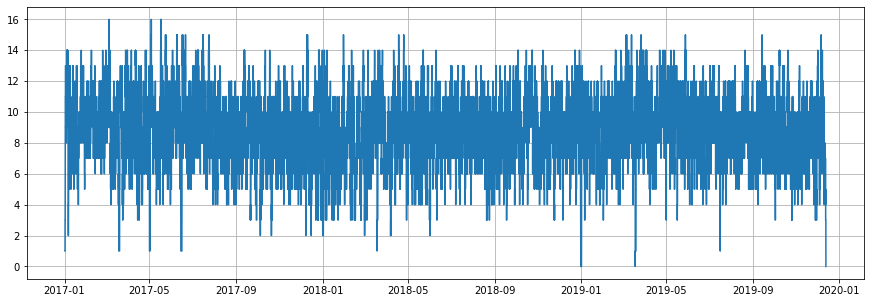

In [550]:
figure(figsize=(15,5))

plt.step(traffic_cont_ihs.TS,traffic_cont_ihs.ships, where='post')
plt.grid(True)
# plt.xlim(['2018-01-01','2019-01-01'])
# plt.xlim(['2018-09-24 00','2018-09-24 12'])


In [551]:
traffic_cont_ihs.ships.tail()

11571    4
11577    3
11513    2
11530    1
11551    0
Name: ships, dtype: int64

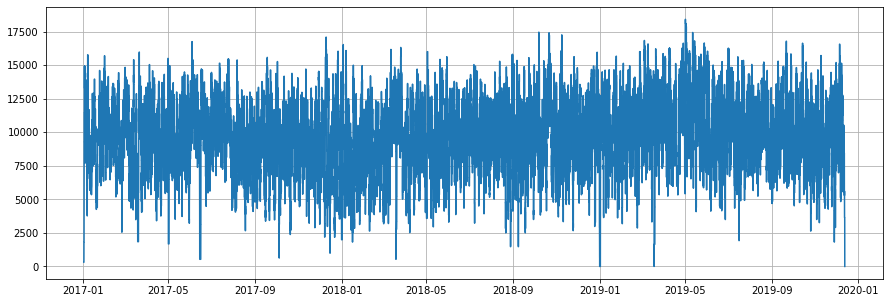

In [552]:
a = figure(figsize=(15,5))

plt.step(traffic_cont_ihs.TS,traffic_cont_ihs.cum_pot, where='post')
plt.grid(True)
# plt.xlim(['2018-01-01','2019-01-01'])

# plt.xlim(['2019-01-01','2019-12-13'])
# plt.xlim(['2017-01-20 18','2017-01-20 22'])
# plt.ylim([10000,30000])

In [553]:
# milisegundos para evitar duplicados en las time series

traffic_cont_ihs.TS = traffic_cont_ihs.TS + pd.to_timedelta(traffic_cont_ihs.groupby('TS').cumcount(), unit='ms')

In [554]:
traffic_cont_ihs.TS.is_unique

True

In [555]:
print(len(traffic_cont_ihs[traffic_cont_ihs.TS.duplicated()==True]))

0


In [556]:
traffic_cont_ihs = traffic_cont_ihs.set_index('TS')#.resample('h')

In [557]:
### ---------------------------------------------------------- ###
### función que da el valor acumulado de potencias por horas
### ---------------------------------------------------------- ###

traffic_cont_ihs.resample('1H').ffill().fillna(0).head(10)#.groupby('TS').sum()

,pot_media,direction,ships,cum_pot
TS,,,,
2017-01-01 15:00:00,0.0,0.0,0.0,0.0
2017-01-01 16:00:00,313.0,1.0,1.0,313.0
2017-01-01 17:00:00,313.0,1.0,2.0,626.0
2017-01-01 18:00:00,1190.0,1.0,3.0,1816.0
2017-01-01 19:00:00,1190.0,1.0,3.0,1816.0
2017-01-01 20:00:00,1190.0,1.0,3.0,1816.0
2017-01-01 21:00:00,1679.0,1.0,4.0,3495.0
2017-01-01 22:00:00,1650.0,1.0,5.0,5145.0
2017-01-01 23:00:00,313.0,1.0,7.0,7382.0


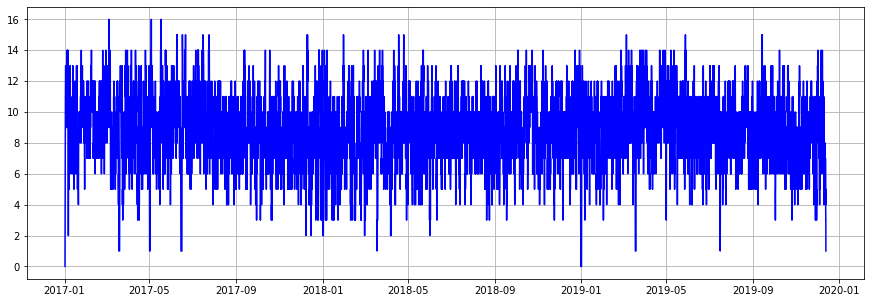

In [558]:
a = figure(figsize=(15,5))

x = traffic_cont_ihs.resample('1H').ffill().index
y = traffic_cont_ihs.resample('1H').ffill().fillna(0).ships

plt.plot(x,y,'b')
plt.grid(True)
# plt.xlim(['2019-12-10','2019-12-13'])
# plt.xlim(['2019-01-01','2019-12-13'])

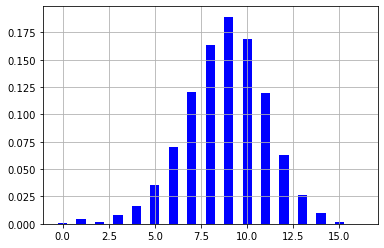

In [559]:
x = traffic_cont_ihs.resample('1H').ffill().fillna(0).ships

plt.hist(x=x,bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,
                        9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5],density=True, rwidth=0.5, color='b')
plt.grid(True)

In [560]:
np.sum([0.00096824, 0.00410534, 0.00197521, 0.0077072 , 0.01669249,
        0.035244  , 0.07013943, 0.12041053, 0.16328428, 0.18927188,
        0.16917119, 0.11979086, 0.06320682, 0.02621998, 0.01026336,
        0.00135554, 0.00019365])

1.0

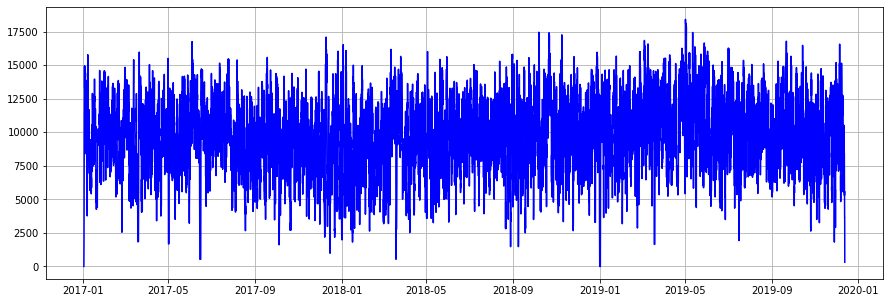

In [561]:
a = figure(figsize=(15,5))

x = traffic_cont_ihs.resample('1H').ffill().index
y = traffic_cont_ihs.resample('1H').ffill().fillna(0).cum_pot

plt.plot(x,y,'b')
plt.grid(True)
# plt.xlim(['2019-12-10','2019-12-13'])
# plt.xlim(['2019-01-01','2019-12-13'])

(array([  68.,  112.,  118.,  265.,  654., 1043., 1832., 2542., 3463.,
        3870., 3892., 3295., 2431., 1368.,  604.,  200.,   34.,   29.]),
 array([    0. ,  1022.5,  2045. ,  3067.5,  4090. ,  5112.5,  6135. ,
         7157.5,  8180. ,  9202.5, 10225. , 11247.5, 12270. , 13292.5,
        14315. , 15337.5, 16360. , 17382.5, 18405. ]),
 <a list of 18 Patch objects>)

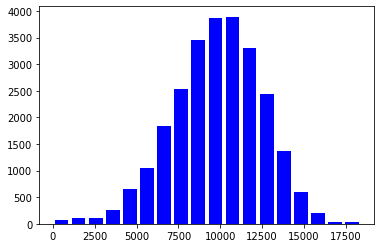

In [562]:
x = traffic_cont_ihs.resample('1H').ffill().fillna(0).cum_pot

plt.hist(x=x,bins=18, rwidth= 0.8, color='b')
# plt.grid(True)

In [563]:
print('Power cont_ihs')
print('-------------------')
# print('\n')
print(str(round(len(x[x==0])*100/len(x),2)) + ' % del tiempo sin cruceros atracados')
print(str(round(len(x[(x>0) & (x<=3000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1 y 3000 kW')
print(str(round(len(x[(x>3000) & (x<=6000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 3000 y 6000 kW')
print(str(round(len(x[(x>6000) & (x<=9000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 6000 y 9000 kW')
print(str(round(len(x[(x>9000) & (x<=12000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 9000 y 12000 kW')
print(str(round(len(x[(x>12000) & (x<=15000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 12000 y 15000 kW')
print(str(round(len(x[(x>15000) & (x<=18000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 15000 y 18000 kW')
# print(str(round(len(x[x>12000])*100/len(x),2)) + ' % de horas con pot acumulada mayor de 12000 kW')

# print('-------------------')
# print('Considerando solo el tiempo que hay al menos un crucero:')
# print(str(round(len(x[(x>0) & (x<=500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1 y 500 kW')
# print(str(round(len(x[(x>500) & (x<=1000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 500 y 1000 kW')
# print(str(round(len(x[(x>1000) & (x<=1500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1000 y 1500 kW')
# print(str(round(len(x[(x>1500) & (x<=2000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1500 y 2000 kW')
# print(str(round(len(x[x>2000])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada mayor de 2000 kW')

Power cont_ihs
-------------------
0.1 % del tiempo sin cruceros atracados
1.05 % de horas con pot acumulada entre 1 y 3000 kW
7.04 % de horas con pot acumulada entre 3000 y 6000 kW
28.07 % de horas con pot acumulada entre 6000 y 9000 kW
42.53 % de horas con pot acumulada entre 9000 y 12000 kW
19.69 % de horas con pot acumulada entre 12000 y 15000 kW
1.44 % de horas con pot acumulada entre 15000 y 18000 kW


In [ ]:
x[x<100]

In [564]:
traffic_cont_ihs.resample('1H').ffill().fillna(0).cum_pot

TS
2017-01-01 15:00:00       0.0
2017-01-01 16:00:00     313.0
2017-01-01 17:00:00     626.0
2017-01-01 18:00:00    1816.0
2017-01-01 19:00:00    1816.0
                        ...  
2019-12-13 06:00:00    3642.0
2019-12-13 07:00:00    3642.0
2019-12-13 08:00:00    1963.0
2019-12-13 09:00:00    1963.0
2019-12-13 10:00:00     313.0
Freq: H, Name: cum_pot, Length: 25820, dtype: float64

In [565]:
traffic_cont_ihs.head(8)

,pot_media,direction,ships,cum_pot
TS,,,,
2017-01-01 15:05:00,313,1,1,313
2017-01-01 16:30:00,313,1,2,626
2017-01-01 17:50:00,1190,1,3,1816
2017-01-01 21:00:00,1679,1,4,3495
2017-01-01 21:15:00,1650,1,5,5145
2017-01-01 22:30:00,1924,1,6,7069
2017-01-01 22:55:00,313,1,7,7382
2017-01-02 00:20:00,1190,1,8,8572


In [430]:
2346*3

7038

In [566]:
sim = pd.concat([traffic_cont_ihs.resample('1H').ffill().fillna(0).ships,
                 traffic_cont_ihs.resample('1H').ffill().fillna(0).cum_pot], axis=1)
sim.to_excel("sim_cont_ihs.xlsx")

#### Descriptivo (outdated)

In [220]:
contenedores['Muelle Atraque Real'].unique()

array(['LLOVERA                  ', 'LEVANTE 1                ',
       'LEVANTE 3                ', 'PRINCIPE FELIPE          ',
       'LEVANTE 2                ', 'TRANSVERSAL COSTA        ',
       'LEVANTE 4                ', 'M. ESTE (PRINCIPE FELIPE)',
       'MUELLE DE COSTA          '], dtype=object)

In [190]:
# no funciona el merge de potencias MSC porque las horas de atraque no coinciden, y el IMO es ambiguo (duplicados)

# pd.merge(contenedores, MSC_2018[['IMO', 'Potencia_kW','FH. Amarre Calc']], 
#                        left_on=['FH. Amarre Calc','Clave Lloyd o Num. OMI'],right_on=['FH. Amarre Calc','IMO'],
#                        how='left').Potencia_kW.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Potencia_kW, dtype: float64

In [205]:
contenedores[contenedores['Año Servicio']==2018].sort_values(by=['FH. Amarre Calc'])#.isin(MSC_2018['FH. Amarre Calc'])
# MSC_2018['FH. Amarre Calc']

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,Tipo Maniobra,Fecha de Fin del Servicio,Hora de Fin del Servicio,Fecha de Inicio de Servicio,Hora de Inicio del Servicio,FH. Amarre Calc,FH. Desamarre Calc,Amarre calculado (horas)
3936,2018,1 2017 6570,9491850,GÜLBENIZ A,PORTACONTENEDOR,26195,1,NaN,12000,PRINCIPE FELIPE,Amarre,2018-01-01,2235,2018-01-01,2215,2018-01-01 22:35:00,2018-01-02 18:20:00,19.750000
4087,2018,1 2018 44,9389708,ZIM MONACO,PORTACONTENEDOR,40030,1,NaN,49707,LEVANTE 1,Amarre,2018-01-01,2355,2018-01-01,2335,2018-01-01 23:55:00,2018-01-03 12:50:00,36.916667
4021,2018,1 2017 6713,9216987,RIO BLACKWATER,PORTACONTENEDOR,65059,1,NaN,74700,LEVANTE 1,Amarre,2018-01-02,115,2018-01-02,50,2018-01-02 01:15:00,2018-01-03 11:15:00,34.000000
4055,2018,1 2018 11,9622590,OOCL BRUSSELS,POLIV. GENERAL CONTENEDOR,141003,1,NaN,94788,PRINCIPE FELIPE,Amarre,2018-01-02,545,2018-01-02,505,2018-01-02 05:45:00,2018-01-03 17:50:00,36.083333
4109,2018,1 2018 66,9404651,MSC CAMILLE,PORTACONTENEDOR,153092,1,NaN,98218,PRINCIPE FELIPE,Amarre,2018-01-02,650,2018-01-02,615,2018-01-02 06:50:00,2018-01-03 09:30:00,26.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8078,2018,1 2019 183,9252864,MARINA,PORTACONTENEDOR,6409,1,NaN,7342,PRINCIPE FELIPE,Amarre,2019-01-02,550,2019-01-02,530,2019-01-02 05:50:00,2019-01-03 00:10:00,18.333333
7846,2018,1 2018 6438,9134139,SVEN,PORTACONTENEDOR,6362,2,NaN,2500,PRINCIPE FELIPE,Amarre,2019-01-02,1710,2019-01-02,1700,2019-01-02 17:10:00,2019-01-03 02:05:00,8.916667
7899,2018,1 2018 6569,9327580,KANTATA,PORTACONTENEDOR,9957,3,NaN,13229,TRANSVERSAL COSTA,Amarre,2019-01-02,1805,2019-01-02,1750,2019-01-02 18:05:00,2019-01-03 12:00:00,17.916667
7898,2018,1 2018 6569,9327580,KANTATA,PORTACONTENEDOR,9957,2,NaN,13229,PRINCIPE FELIPE,Amarre,2019-01-03,1250,2019-01-03,1235,2019-01-03 12:50:00,2019-01-03 22:35:00,9.750000


In [206]:
MSC_2018.sort_values(by='FH. Amarre Calc')

,Message Date,Vessel,Shore power equipped,Retrofitted,California Commissioned,Segment (TEUs),Port,Country,Consolidated AUX,Consolidated BOILER,...,Average Power,Consolidated Port Stay (Hours),LOA,IMO,FH. Amarre Calc,Amarre calculado (horas),FH. Desamarre Calc,Duración fondeado en Business Objects,Potencia_kW,Muelle
1035,2018-01-06 02:06:00,VEGA SIGMA,NO,-,-,1100,VALENCIA,SPAIN,1.52,0.69,...,282.004,24.5,Unknown,9330240,2018-01-01 20:48:00,25.083333,2018-01-02 21:53:00,76.5167,275.445485,PRINCIPE FELIPE
32,2018-01-03 09:00:00,MSC CAMILLE,YES,-,NO,14000,VALENCIA,SPAIN,10.50,6.50,...,1821.65,26.2,366,9404651,2018-01-02 05:28:00,27.500000,2018-01-03 08:58:00,-,1735.537190,PRINCIPE FELIPE
105,2018-01-04 10:18:00,MSC AJACCIO,YES,-,-,9500,VALENCIA,SPAIN,17.00,6.00,...,1705.8,45.3,300,9605267,2018-01-02 12:03:00,40.166667,2018-01-04 04:13:00,-,4730.290456,TRANSVERSAL COSTA
335,2018-01-04 17:06:00,MSC MELINE,YES,-,-,8500,VALENCIA,SPAIN,19.72,2.60,...,3421.24,26.2,300,9702077,2018-01-03 13:37:00,27.083333,2018-01-04 16:42:00,-,3309.650350,PRINCIPE FELIPE
417,2018-01-05 14:00:00,E.R. YOKOHAMA,NO,-,-,7500,VALENCIA,SPAIN,15.50,3.90,...,3420.12,20.6,Unknown,9285665,2018-01-04 16:15:00,21.833333,2018-01-05 14:05:00,-,3226.925746,PRINCIPE FELIPE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2018-12-31 12:00:00,MSC JOANNA,NO,-,-,9500,VALENCIA,SPAIN,7.22,5.34,...,1224.56,26.8,Unknown,9304435,2018-12-30 07:54:00,28.083333,2018-12-31 11:59:00,-,1168.599946,PRINCIPE FELIPE
545,2018-12-31 13:18:00,MSC DYMPHNA,NO,-,-,5500,VALENCIA,SPAIN,6.50,4.70,...,1355.3,21.8,Unknown,9110391,2018-12-30 14:34:00,22.333333,2018-12-31 12:54:00,-,1322.930801,PRINCIPE FELIPE
358,2018-12-31 13:54:00,MSC RACHELE,NO,-,-,8500,VALENCIA,SPAIN,8.00,5.00,...,1818.18,20.0,Unknown,9290282,2018-12-30 17:03:00,20.416667,2018-12-31 13:28:00,-,1781.076067,MUELLE DE COSTA
802,2018-12-31 06:54:00,MSC DON GIOVANNI,NO,-,-,2500,VALENCIA,SPAIN,1.31,0.65,...,601.469,9.9,Unknown,9102746,2018-12-30 20:04:00,10.500000,2018-12-31 06:34:00,-,567.099567,TRANSVERSAL COSTA


In [176]:
contenedores[((contenedores['Muelle Atraque Real']=='TRANSVERSAL COSTA        ')|
             (contenedores['Muelle Atraque Real']=='PRINCIPE FELIPE          ')|
             (contenedores['Muelle Atraque Real']=='MUELLE DE COSTA          ')) &
             (contenedores['Año Servicio']==2018)
            ]


,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,Tipo Maniobra,Fecha de Fin del Servicio,Hora de Fin del Servicio,Fecha de Inicio de Servicio,Hora de Inicio del Servicio,FH. Amarre Calc,FH. Desamarre Calc,Amarre calculado (horas)
3896,2018,1 2017 6504,9311880,LETO,PORTACONTENEDOR,35881,2,NaN,35717,PRINCIPE FELIPE,Amarre,2018-01-03,1945,2018-01-03,1925,2018-01-03 19:45:00,2018-01-04 11:55:00,16.166667
3907,2018,1 2017 6539,9605267,MSC AJACCIO,PORTACONTENEDOR,94402,2,NaN,54180,PRINCIPE FELIPE,Amarre,2018-01-03,1120,2018-01-03,1050,2018-01-03 11:20:00,2018-01-04 10:30:00,23.166667
3908,2018,1 2017 6539,9605267,MSC AJACCIO,PORTACONTENEDOR,94402,1,NaN,54180,TRANSVERSAL COSTA,Amarre,2018-01-02,1255,2018-01-02,1235,2018-01-02 12:55:00,2018-01-03 04:40:00,15.750000
3936,2018,1 2017 6570,9491850,GÜLBENIZ A,PORTACONTENEDOR,26195,1,NaN,12000,PRINCIPE FELIPE,Amarre,2018-01-01,2235,2018-01-01,2215,2018-01-01 22:35:00,2018-01-02 18:20:00,19.750000
3964,2018,1 2017 6628,9285665,E.R. YOKOHAMA,PORTACONTENEDOR,83133,2,NaN,93358,PRINCIPE FELIPE,Amarre,2018-01-04,1725,2018-01-04,1655,2018-01-04 17:25:00,2018-01-05 14:30:00,21.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7914,2018,1 2018 6593,9123166,MSC ALABAMA,PORTACONTENEDOR,37518,1,NaN,38542,MUELLE DE COSTA,Amarre,2018-12-24,100,2018-12-24,40,2018-12-24 01:00:00,2018-12-24 18:40:00,17.666667
7915,2018,1 2018 6599,9330238,VEGA EPSILON,PORTACONTENEDOR,9940,3,NaN,13229,PRINCIPE FELIPE,Amarre,2019-01-01,2250,2019-01-01,2230,2019-01-01 22:50:00,2019-01-03 11:15:00,36.416667
7919,2018,1 2018 6611,9403437,VEGA AZURIT,PORTACONTENEDOR,9957,2,NaN,9730,MUELLE DE COSTA,Amarre,2019-01-04,1450,2019-01-04,1435,2019-01-04 14:50:00,2019-01-05 17:10:00,26.333333
7920,2018,1 2018 6613,9279965,MSC FABIENNE,PORTACONTENEDOR,54774,1,NaN,55889,TRANSVERSAL COSTA,Amarre,2018-12-31,40,2018-12-31,15,2018-12-31 00:40:00,2018-12-31 18:30:00,17.833333


In [174]:
MSC_2018.Potencia_kW.mean()

1239.8594133312793

In [226]:
# portacontenedores, consumo en escala, EEA

(14871*0.2*0.05) + (14871*0.25*0.4)

1635.8100000000002

In [208]:
contenedores.Potencia.describe()

count     11583.000000
mean      36915.552879
std       29452.251352
min          54.000000
25%       12000.000000
50%       29313.000000
75%       58274.000000
max      114239.000000
Name: Potencia, dtype: float64

In [49]:
contenedores['Tipo Buque'].unique()

array(['PORTACONTENEDOR          ', 'POLIV. GENERAL CONTENEDOR',
       'MERCANT. CONVENCIONAL    ', 'OTROS PORTACONTENEDORES  ',
       'MERCANT. ESPECIAL        ', 'OTROS MERCANTES          '],
      dtype=object)

In [289]:
for each in contenedores['Año Servicio'].unique():
    print(str(each) + str(' ') + 
          str(len(contenedores[contenedores['Año Servicio']==each])))

2017 4031
2018 3873
2019 3679


In [50]:
# Clasificación escalas por muelle y por tipo de buque

for each1 in contenedores['Muelle Atraque Real'].unique():
    for each2 in contenedores['Tipo Buque'].unique():
        print(str(each1) + str(' ') +
              str(each2) + 
              (str(len(contenedores[(contenedores['Muelle Atraque Real']==each1)&(contenedores['Tipo Buque']==each2)]))))
    print(str('\n'))    

LLOVERA                   PORTACONTENEDOR          662
LLOVERA                   POLIV. GENERAL CONTENEDOR17
LLOVERA                   MERCANT. CONVENCIONAL    1
LLOVERA                   OTROS PORTACONTENEDORES  0
LLOVERA                   MERCANT. ESPECIAL        0
LLOVERA                   OTROS MERCANTES          1


LEVANTE 1                 PORTACONTENEDOR          1121
LEVANTE 1                 POLIV. GENERAL CONTENEDOR76
LEVANTE 1                 MERCANT. CONVENCIONAL    8
LEVANTE 1                 OTROS PORTACONTENEDORES  0
LEVANTE 1                 MERCANT. ESPECIAL        0
LEVANTE 1                 OTROS MERCANTES          2


LEVANTE 3                 PORTACONTENEDOR          426
LEVANTE 3                 POLIV. GENERAL CONTENEDOR72
LEVANTE 3                 MERCANT. CONVENCIONAL    7
LEVANTE 3                 OTROS PORTACONTENEDORES  0
LEVANTE 3                 MERCANT. ESPECIAL        0
LEVANTE 3                 OTROS MERCANTES          1


PRINCIPE FELIPE           PORT

In [145]:
ewrwefwef

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,Tipo Maniobra,Fecha de Fin del Servicio,Hora de Fin del Servicio,Fecha de Inicio de Servicio,Hora de Inicio del Servicio,FH. Amarre Calc,FH. Desamarre Calc,Amarre calculado (horas)
0,2017,1 2016 6487,9356309,CMA CGM HYDRA,PORTACONTENEDOR,128600,1,NaN,98218,LLOVERA,Amarre,2017-01-01,2230,2017-01-01,2200,2017-01-01 22:30:00,2017-01-03 13:30:00,39.000000
1,2017,1 2016 6632,9509138,FLEUR N,PORTACONTENEDOR,35887,1,NaN,34044,LEVANTE 1,Amarre,2017-01-02,35,2017-01-02,15,2017-01-02 00:35:00,2017-01-03 20:00:00,43.416667
2,2017,1 2016 6635,9449118,MARTHA SCHULTE,PORTACONTENEDOR,38364,1,NaN,43494,LEVANTE 3,Amarre,2017-01-01,1750,2017-01-01,1725,2017-01-01 17:50:00,2017-01-02 23:10:00,29.333333
3,2017,1 2016 6674,9230490,MSC LORETTA,PORTACONTENEDOR,73819,1,NaN,12000,PRINCIPE FELIPE,Amarre,2017-01-02,610,2017-01-02,550,2017-01-02 06:10:00,2017-01-03 10:35:00,28.416667
4,2017,1 2016 6681,9007817,MSC NAMIBIA II,PORTACONTENEDOR,23953,1,NaN,14400,PRINCIPE FELIPE,Amarre,2017-01-04,1430,2017-01-04,1410,2017-01-04 14:30:00,2017-01-05 16:20:00,25.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11578,2019,1 2019 6374,9306251,MAUREN,PORTACONTENEDOR,9957,1,NaN,9730,TRANSVERSAL COSTA,Amarre,2019-12-09,615,2019-12-09,600,2019-12-09 06:15:00,2019-12-09 15:40:00,9.416667
11579,2019,1 2019 6375,9330240,VEGA SIGMA,PORTACONTENEDOR,9940,2,NaN,13229,TRANSVERSAL COSTA,Amarre,2019-12-10,1210,2019-12-10,1150,2019-12-10 12:10:00,2019-12-10 21:20:00,9.166667
11580,2019,1 2019 6399,9673666,VIOLETA B,PORTACONTENEDOR,18826,1,NaN,14280,M. ESTE (PRINCIPE FELIPE),Amarre,2019-12-11,225,2019-12-11,205,2019-12-11 02:25:00,2019-12-11 17:05:00,14.666667
11581,2019,1 2019 6430,9232656,CHARLIE,PORTACONTENEDOR,16661,1,NaN,18121,M. ESTE (PRINCIPE FELIPE),Amarre,2019-12-07,2000,2019-12-07,1940,2019-12-07 20:00:00,2019-12-08 20:05:00,24.083333


In [158]:
año =2018

In [159]:
(cont_ihs['Amarre calculado (horas)'][cont_ihs['Año Servicio']==año]*cont_ihs.Potencia_kW[cont_ihs['Año Servicio']==año]).sum()/1000

84222.32994643073

In [136]:
cont_ihs.head(1)

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Ship Type,GT,Service Speed,Total KW Main Eng,Aux. Engine Model,Aux. Engine Total KW,Year,Reefer Points,TEU,Potencia_kW
0,2017,1 2016 6487,9356309,CMA CGM HYDRA,PORTACONTENEDOR,128600,1,NaN,98218,LLOVERA,...,Container Ship (Fully Cellular),128600.0,24.3,72240.0,NaN,NaN,2009.0,700.0,11040.0,1924.1


In [143]:
cont_ihs['Amarre calculado (horas)']

0        39.000000
1        43.416667
2        29.333333
3        28.416667
4        25.833333
           ...    
11578     9.416667
11579     9.166667
11580    14.666667
11581    24.083333
11582    41.916667
Name: Amarre calculado (horas), Length: 11583, dtype: float64

#### Histogramas (escalas y potencia motores)

In [567]:
cont_ihs['Amarre calculado (horas)'].describe()

count    11583.000000
mean        19.653878
std         10.179127
min          1.583333
25%         12.750000
50%         17.916667
75%         24.250000
max        103.250000
Name: Amarre calculado (horas), dtype: float64

In [375]:
cont_ihs.Potencia.describe()

count     11583.000000
mean      36915.552879
std       29452.251352
min          54.000000
25%       12000.000000
50%       29313.000000
75%       58274.000000
max      114239.000000
Name: Potencia, dtype: float64

In [593]:
año = 2019

In [594]:
len(cont_ihs[cont_ihs['Año Servicio']==año])

3679

(array([  69.,  709., 1001.,  885.,  496.]),
 array([ 0,  6, 12, 18, 24, 30]),
 <a list of 5 Patch objects>)

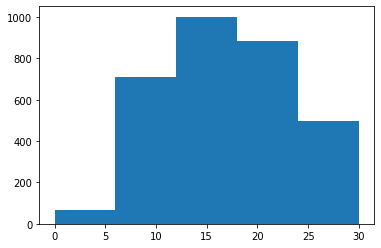

In [595]:
plt.hist(cont_ihs['Amarre calculado (horas)'][(cont_ihs['Año Servicio']==año) & 
                                              (cont_ihs['Total KW Main Eng'].isna() == False)],
        bins=[0,6,12,18,24,30])

In [596]:
len(cont_ihs[cont_ihs['Año Servicio']==año]) - np.array([  69.,  709., 1001.,  885.,  496.]).sum() 

519.0

(array([1172.,  333.,  356.,  365.,  485.,  410.,  428.,  129.]),
 array([    0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000]),
 <a list of 8 Patch objects>)

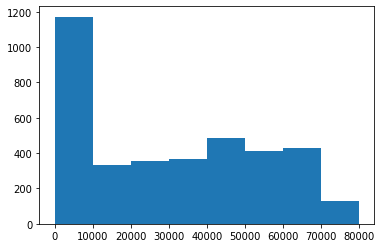

In [597]:
plt.hist(cont_ihs['Total KW Main Eng'][cont_ihs['Año Servicio']==año],
        bins=[0,10000,20000,30000,40000,50000,60000,70000,80000])

In [598]:
len(cont_ihs[cont_ihs['Año Servicio']==año]) - np.array([1172.,  333.,  356.,  365.,  485.,  410.,  428.,  129.]).sum() 

1.0

## Cruceros

### De Josep a --> buques DB

In [4]:
%store -r buques
%store -r c

In [6]:
buques.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 25', 'Potencia_kW',
       'terminal', 'buque_def', 'IMO', 'TotalPower', 'GT', 'Manoeuvring'],
      dtype='object')

In [8]:
path = r'C:\Users\badria\FUNDACIÓN VALENCIAPORT\Eva Pérez García - PLAN ENERGÉTICO 0 EMISIONES APV\Estimacion emisiones de buques\BUQUES\CRUCEROS'
os.chdir(path)

In [27]:
c2017 = pd.read_excel("CRUCEROS 2017-2018-2019_v2.xlsx",sheet_name='2017')
c2018 = pd.read_excel("CRUCEROS 2017-2018-2019_v2.xlsx",sheet_name='2018')
c2019 = pd.read_excel("CRUCEROS 2017-2018-2019_v2.xlsx",sheet_name='2019')

In [18]:
c2017.head(1)

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Unnamed: 4,Grupo Naviera,Det. G.T. Buque,Year,Power (kW),Potencia,...,kW/pax,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33
0,2017.0,1 2017 242,9237345.0,COSTA MEDITERRANEA,=BUSCARV(D2;Hoja1!A2:E138;4;FALSO),COSTA CRUCEROS,85619.0,NaN,62370.0,84798.0,...,5.33395,NaN,NaN,NaN,Duración de la escala (h),Frecuencia,NaN,NaN,NaN,NaN


In [25]:
c2019.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Grupo Naviera', 'Det. G.T. Buque', 'Year', 'Power (kW)', 'Potencia',
       'Total  Pasajeros', 'Muelle Atraque Real', 'FH. Amarre Calc',
       'FH. Desamarre Calc', 'Amarre calculado (horas)', 'GT*t', 'Pax*h',
       'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 22', 'kW/pax',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32'],
      dtype='object')

In [32]:
c2017 = c2017[['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Det. G.T. Buque','Power (kW)','Potencia','Total  Pasajeros', 'Muelle Atraque Real',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Pax*h', 'Paux_a(kW)','Paux_b(kW)', 'Paux_a*t (kWh)', 'Paux_b*t (kWh)','kW/pax']][0:203]

c2018 = c2018[['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Det. G.T. Buque','Power (kW)','Potencia','Total  Pasajeros', 'Muelle Atraque Real',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Pax*h','Paux_a(kW)','Paux_b(kW)', 'Paux_a*t (kWh)', 'Paux_b*t (kWh)','kW/pax']][0:193]

c2019 = c2019[['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Det. G.T. Buque','Power (kW)','Potencia','Total  Pasajeros', 'Muelle Atraque Real',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Pax*h','Paux_a(kW)','Paux_b(kW)', 'Paux_a*t (kWh)', 'Paux_b*t (kWh)','kW/pax']][0:203]

In [34]:
c = pd.concat([c2017, c2018, c2019])
del c2017, c2018, c2019

In [8]:
c['Clave Lloyd o Num. OMI'] = c['Clave Lloyd o Num. OMI'].astype('int32')

In [9]:
c.dtypes

Año Servicio                       float64
Id.Escala                           object
Clave Lloyd o Num. OMI               int32
Buque                               object
Det. G.T. Buque                    float64
Power (kW)                         float64
Potencia                           float64
Total  Pasajeros                   float64
Muelle Atraque Real                 object
FH. Amarre Calc             datetime64[ns]
FH. Desamarre Calc          datetime64[ns]
Amarre calculado (horas)           float64
GT*t                               float64
Pax*h                              float64
Paux_a(kW)                         float64
Paux_b(kW)                         float64
Paux_a*t (kWh)                     float64
Paux_b*t (kWh)                     float64
kW/pax                             float64
dtype: object

In [28]:
buques[(buques['Id.Escala'].duplicated()==True) & (buques.buque_def=='crucero')]
buques[buques['Clave Lloyd o Num. OMI'] == 7822457]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW)_x,Potencia,Muelle Atraque Real,...,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT,Manoeuvring,Power (kW)_y,Paux_b(kW)_y,Paux_b*t (kWh)_y
5860,2017,1 2017 5830,7822457,SAGA SAPPHIRE,CRUCERO TURÍSTICO,37049.0,1,NaN,28918.0,TRANSVERSALES,...,5147.4,trasme_cru,crucero,NaN,NaN,NaN,6477.63,21270.0,3786.06,37229.589998
18936,2019,1 2019 5361,7822457,SAGA SAPPHIRE,CRUCERO TURÍSTICO,37049.0,1,NaN,28918.0,TRANSVERSALES,...,5147.4,trasme_cru,crucero,NaN,NaN,NaN,6477.63,21270.0,3786.06,36283.075003
18937,2019,1 2019 5361,7822457,SAGA SAPPHIRE,CRUCERO TURÍSTICO,37049.0,2,NaN,28918.0,TRANSVERSALES,...,5147.4,trasme_cru,crucero,NaN,NaN,NaN,6477.63,21270.0,3786.06,36283.075003


In [23]:
buques = pd.merge(buques, c[['Id.Escala','Clave Lloyd o Num. OMI','Power (kW)','Paux_b(kW)','Paux_b*t (kWh)']],
         on = ['Clave Lloyd o Num. OMI','Id.Escala'], how = 'left')

In [41]:
buques[(buques['Power (kW)_y'].isna()) & ([buques.buque_def=='crucero'])]

ValueError: setting an array element with a sequence.

In [48]:
buques[buques['Power (kW)_y'].notna()==True]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW)_x,Potencia,Muelle Atraque Real,...,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT,Manoeuvring,Power (kW)_y,Paux_b(kW)_y,Paux_b*t (kWh)_y
299,2017,1 2017 242,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,84798.0,PONIENTE-1,...,18231.6,trasme_cru,crucero,NaN,NaN,NaN,18994.8,62370.0,13409.55,108393.862486
389,2017,1 2017 338,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,79944.0,PONIENTE-2,...,17188,trasme_cru,crucero,NaN,NaN,NaN,17907.5,58800.0,12642.00,110617.500010
505,2017,1 2017 460,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,84798.0,CRUCEROS DOS,...,18231.6,ampli_norte,crucero,NaN,NaN,NaN,18994.8,62370.0,13409.55,357587.999985
666,2017,1 2017 625,9725421,VIKING SEA,CRUCERO TURÍSTICO,47842.0,1,NaN,23520.0,PONIENTE-1,...,4186.56,trasme_cru,crucero,NaN,23520.0,NaN,5268.48,23520.0,4186.56,35934.639999
743,2017,1 2017 700,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,79944.0,PONIENTE-1,...,17188,trasme_cru,crucero,NaN,NaN,NaN,17907.5,58800.0,12642.00,126419.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19628,2019,1 2019 6083,9228356,JEWEL OF THE SEAS,CRUCERO TURÍSTICO,90090.0,1,NaN,78177.0,CRUCEROS UNO,...,16808.1,ampli_norte,crucero,NaN,NaN,NaN,17511.6,57500.0,12362.50,119504.166674
19659,2019,1 2019 6115,8700280,AMERA,CRUCERO TURÍSTICO,39051.0,1,NaN,28720.0,PONIENTE-2,...,5112.16,trasme_cru,crucero,NaN,NaN,NaN,6433.28,21120.0,3759.36,38220.159997
19709,2019,1 2019 6175,9239795,COSTA MAGICA,CRUCERO TURÍSTICO,102587.0,1,NaN,86146.0,PONIENTE-2,...,13008,trasme_cru,crucero,NaN,NaN,NaN,19296.7,63360.0,9567.36,89295.360000
19724,2019,1 2019 6192,9678408,MEIN SCHIFF 4,CRUCERO TURÍSTICO,99526.0,1,NaN,45200.0,PONIENTE-2,...,9718,trasme_cru,crucero,9678408.0,45200.0,99526.0,10124.8,45200.0,9718.00,94750.499992


In [59]:
buques['Potencia'] = np.where(buques['Power (kW)_y'].notna()==True,buques['Power (kW)_y'],buques['Potencia'])

In [60]:
buques[buques.buque_def=='crucero']

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW)_x,Potencia,Muelle Atraque Real,...,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT,Manoeuvring,Power (kW)_y,Paux_b(kW)_y,Paux_b*t (kWh)_y
299,2017,1 2017 242,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,62370.0,PONIENTE-1,...,18231.6,trasme_cru,crucero,NaN,NaN,NaN,18994.8,62370.0,13409.55,108393.862486
389,2017,1 2017 338,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,58800.0,PONIENTE-2,...,17188,trasme_cru,crucero,NaN,NaN,NaN,17907.5,58800.0,12642.00,110617.500010
505,2017,1 2017 460,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,62370.0,CRUCEROS DOS,...,18231.6,ampli_norte,crucero,NaN,NaN,NaN,18994.8,62370.0,13409.55,357587.999985
666,2017,1 2017 625,9725421,VIKING SEA,CRUCERO TURÍSTICO,47842.0,1,NaN,23520.0,PONIENTE-1,...,4186.56,trasme_cru,crucero,NaN,23520.0,NaN,5268.48,23520.0,4186.56,35934.639999
743,2017,1 2017 700,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,58800.0,PONIENTE-1,...,17188,trasme_cru,crucero,NaN,NaN,NaN,17907.5,58800.0,12642.00,126419.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19628,2019,1 2019 6083,9228356,JEWEL OF THE SEAS,CRUCERO TURÍSTICO,90090.0,1,NaN,57500.0,CRUCEROS UNO,...,16808.1,ampli_norte,crucero,NaN,NaN,NaN,17511.6,57500.0,12362.50,119504.166674
19659,2019,1 2019 6115,8700280,AMERA,CRUCERO TURÍSTICO,39051.0,1,NaN,21120.0,PONIENTE-2,...,5112.16,trasme_cru,crucero,NaN,NaN,NaN,6433.28,21120.0,3759.36,38220.159997
19709,2019,1 2019 6175,9239795,COSTA MAGICA,CRUCERO TURÍSTICO,102587.0,1,NaN,63360.0,PONIENTE-2,...,13008,trasme_cru,crucero,NaN,NaN,NaN,19296.7,63360.0,9567.36,89295.360000
19724,2019,1 2019 6192,9678408,MEIN SCHIFF 4,CRUCERO TURÍSTICO,99526.0,1,NaN,45200.0,PONIENTE-2,...,9718,trasme_cru,crucero,9678408.0,45200.0,99526.0,10124.8,45200.0,9718.00,94750.499992


In [61]:
buques.describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW)_x,Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,...,Paux_b(kW)_x,Paux_a*t (kWh),Paux_b*t (kWh)_x,Unnamed: 25,IMO,TotalPower,GT,Power (kW)_y,Paux_b(kW)_y,Paux_b*t (kWh)_y
count,19845.000000,1.984500e+04,19845.000000,19845.000000,0.0,19845.000000,19845.000000,19845.000000,19845.000000,1.0,...,0.0,1.0,0.0,0.0,1.829200e+04,18387.000000,18292.000000,597.000000,597.000000,597.000000
mean,2017.978987,9.290158e+06,38622.561804,1.226405,NaN,26387.190476,1282.882439,1264.011791,17.560833,5015400.0,...,NaN,447720.0,NaN,NaN,9.291466e+06,26892.508294,38649.518915,41051.244556,7177.966296,70582.156440
std,0.815907,3.241433e+05,34654.764685,0.540804,NaN,18798.009760,660.081046,660.296239,18.577895,NaN,...,NaN,NaN,NaN,NaN,3.108645e+05,18358.917894,33980.415920,24772.019002,4213.951067,50373.872166
min,2017.000000,5.142657e+06,682.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.166667,5015400.0,...,NaN,447720.0,NaN,NaN,7.360617e+06,1980.000000,2906.000000,1060.000000,145.530000,1320.000000
25%,2017.000000,9.214202e+06,16686.000000,1.000000,NaN,11060.000000,740.000000,725.000000,8.083333,5015400.0,...,NaN,447720.0,NaN,NaN,9.220328e+06,12200.000000,16686.000000,21600.000000,3844.800000,38596.799999
50%,2018.000000,9.323637e+06,26375.000000,1.000000,NaN,21600.000000,1325.000000,1310.000000,14.500000,5015400.0,...,NaN,447720.0,NaN,NaN,9.320441e+06,21600.000000,26375.000000,36000.000000,7740.000000,71876.000004
75%,2019.000000,9.458523e+06,51714.000000,1.000000,NaN,36560.000000,1910.000000,1855.000000,22.416667,5015400.0,...,NaN,447720.0,NaN,NaN,9.458523e+06,36560.000000,51714.000000,67200.000000,10781.400000,93940.666673
max,2019.000000,9.842097e+06,228081.000000,8.000000,NaN,88200.000000,2359.000000,2355.000000,438.333333,5015400.0,...,NaN,447720.0,NaN,NaN,9.842097e+06,96800.000000,194849.000000,88200.000000,15317.030000,530990.373320


In [62]:
buques2 = buques

In [63]:
%store buques
%store buques2

Stored 'buques' (DataFrame)
Stored 'buques2' (DataFrame)


### Outdated 

In [64]:
crucero = (buques.buque_def == 'crucero')

In [69]:
buques[crucero].Potencia_kW.mean()

7166.797269230766

In [5]:
cruceros.describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),GT*t,GT*atraque,Paux_a(kW),Paux_a*t (kWh),Unnamed: 25
count,598.000000,5.980000e+02,598.000000,598.000000,0.0,598.000000,598.000000,598.000000,598.000000,1.000000,1.000000,1.0,1.000000,0.0
mean,2017.996656,9.217854e+06,73418.469900,1.010033,NaN,49035.322742,833.871237,798.913043,10.490942,692086.916665,692086.916665,11480.0,92796.666666,NaN
std,0.822621,5.607620e+05,47294.192567,0.099747,NaN,38043.618771,176.638835,182.629195,5.526879,NaN,NaN,NaN,NaN,NaN
min,2017.000000,5.142657e+06,693.000000,1.000000,NaN,1.000000,0.000000,555.000000,0.666667,692086.916665,692086.916665,11480.0,92796.666666,NaN
25%,2017.000000,9.160304e+06,33930.750000,1.000000,NaN,11700.000000,750.000000,730.000000,8.083333,692086.916665,692086.916665,11480.0,92796.666666,NaN
50%,2018.000000,9.320556e+06,71304.000000,1.000000,NaN,38917.500000,805.000000,740.000000,9.750000,692086.916665,692086.916665,11480.0,92796.666666,NaN
75%,2019.000000,9.585285e+06,114288.000000,1.000000,NaN,96860.000000,840.000000,820.000000,10.416667,692086.916665,692086.916665,11480.0,92796.666666,NaN
max,2019.000000,9.814040e+06,228081.000000,2.000000,NaN,119916.000000,2120.000000,2345.000000,62.750000,692086.916665,692086.916665,11480.0,92796.666666,NaN


In [109]:
buques[crucero]['Potencia_kW']=""


In [146]:
import random
l = [random.randint(0,10) for i in range(12)]
l

[8, 5, 7, 5, 9, 5, 0, 3, 0, 5, 2, 9]

In [68]:
# asignamos consumo medio en escala a partir de las potencias instalada y el rango de GT
# ------------------------------------------------------------------------------------ #

buques[crucero]['Potencia_kW']=""

# GT<2000
buques.Potencia_kW[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']<2000)
                            ] = buques.Potencia[(buques.buque_def=='crucero')&
                                                          (buques['Det. G.T. Buque']<2000)]*0.492
# 2000<GT<10000
buques.Potencia_kW[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']>=2000)&
                                      (buques['Det. G.T. Buque']<10000)
] = buques.Potencia[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']>=2000)&
                                      (buques['Det. G.T. Buque']<10000)]*0.099
# 10000<GT<60000
buques.Potencia_kW[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']>=10000)&
                                      (buques['Det. G.T. Buque']<60000)
] = buques.Potencia[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']>=10000)&
                                      (buques['Det. G.T. Buque']<60000)]*0.178
# 60000<GT<100000
buques.Potencia_kW[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']>=60000)&
                                      (buques['Det. G.T. Buque']<100000)
] = buques.Potencia[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']>=60000)&
                                      (buques['Det. G.T. Buque']<100000)]*0.215
# GT>100000
buques.Potencia_kW[(buques.buque_def=='crucero')&(buques['Det. G.T. Buque']>=100000)
                            ] = buques.Potencia[(buques.buque_def=='crucero')&
                                                          (buques['Det. G.T. Buque']>=100000)]*0.151

In [175]:
buques[crucero]
#buques[crucero].Potencia[buques['Det. G.T. Buque']<2000]*0.492

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
299,2017,1 2017 242,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,84798.0,PONIENTE-1,...,NaN,NaN,NaN,NaN,18231.6,trasme_cru,crucero,NaN,NaN,NaN
389,2017,1 2017 338,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,79944.0,PONIENTE-2,...,NaN,NaN,NaN,NaN,17188,trasme_cru,crucero,NaN,NaN,NaN
505,2017,1 2017 460,9237345,COSTA MEDITERRANEA,CRUCERO TURÍSTICO,85619.0,1,NaN,84798.0,CRUCEROS DOS,...,NaN,NaN,NaN,NaN,18231.6,ampli_norte,crucero,NaN,NaN,NaN
666,2017,1 2017 625,9725421,VIKING SEA,CRUCERO TURÍSTICO,47842.0,1,NaN,23520.0,PONIENTE-1,...,NaN,NaN,NaN,NaN,4186.56,trasme_cru,crucero,NaN,23520.0,NaN
743,2017,1 2017 700,9141065,NORWEGIAN SPIRIT,CRUCERO TURÍSTICO,75904.0,1,NaN,79944.0,PONIENTE-1,...,NaN,NaN,NaN,NaN,17188,trasme_cru,crucero,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19628,2019,1 2019 6083,9228356,JEWEL OF THE SEAS,CRUCERO TURÍSTICO,90090.0,1,NaN,78177.0,CRUCEROS UNO,...,NaN,NaN,NaN,NaN,16808.1,ampli_norte,crucero,NaN,NaN,NaN
19659,2019,1 2019 6115,8700280,AMERA,CRUCERO TURÍSTICO,39051.0,1,NaN,28720.0,PONIENTE-2,...,NaN,NaN,NaN,NaN,5112.16,trasme_cru,crucero,NaN,NaN,NaN
19709,2019,1 2019 6175,9239795,COSTA MAGICA,CRUCERO TURÍSTICO,102587.0,1,NaN,86146.0,PONIENTE-2,...,NaN,NaN,NaN,NaN,13008,trasme_cru,crucero,NaN,NaN,NaN
19724,2019,1 2019 6192,9678408,MEIN SCHIFF 4,CRUCERO TURÍSTICO,99526.0,1,NaN,45200.0,PONIENTE-2,...,NaN,NaN,NaN,NaN,9718,trasme_cru,crucero,9678408.0,45200.0,99526.0


In [108]:
cruceros.Potencia_kW

0      18231.6
1        17188
2      18231.6
3           89
4        17188
        ...   
593    16808.1
594    5112.16
595      13008
596    13839.3
597     897.12
Name: Potencia_kW, Length: 598, dtype: object

In [109]:
cruceros.Potencia

0      84798
1      79944
2      84798
3        500
4      79944
       ...  
593    78177
594    28720
595    86146
596    64369
597     5040
Name: Potencia, Length: 598, dtype: int64

In [110]:
cruceros['Det. G.T. Buque']

0       85619
1       75904
2       85619
3       47842
4       75904
        ...  
593     90090
594     39051
595    102587
596     99526
597     47842
Name: Det. G.T. Buque, Length: 598, dtype: int64

## Ferris 

In [177]:
buques_vessl_ihs[buques_vessl_ihs.buque_def=='ropax'].Potencia_kW.describe()

count     4375.000000
unique       3.000000
top        768.077375
freq      2905.000000
Name: Potencia_kW, dtype: float64

In [181]:
%store -r buques_vessl_ihs2

In [186]:
buques_vessl_ihs.Potencia_kW[buques_vessl_ihs.buque_def=='ropax'
                            ] = buques_vessl_ihs2.Potencia_kW[buques_vessl_ihs2.buque_def=='ropax']

In [192]:
buques_vessl_ihs.Potencia_kW[buques_vessl_ihs.buque_def=='roro'
                            ] = buques_vessl_ihs2.Potencia_kW[buques_vessl_ihs2.buque_def=='roro']

In [195]:
buques_vessl_ihs.Potencia_kW[buques_vessl_ihs.buque_def=='roro'
                            ].mean()

500.0

### Versiones anteriores

In [28]:
ferris_ro['Año Servicio'].unique()

array([2017, 2018, 2019], dtype=int64)

In [35]:
for each1 in ferris_ro['Año Servicio'].unique():
    for each2 in ferris_ro['Tipo Buque'].unique():
        print(str(each1) + str(' ') +
              str(each2) + 
              (str(len(ferris_ro[(ferris_ro['Año Servicio']==each1)&(ferris_ro['Tipo Buque']==each2)]))))
    print(str('\n'))    
    

2017 RO/RO VEHÍCULO           504
2017 FERRYS RO/RO PASAJEROS   1317
2017 RO/RO  LO/LO             296
2017 RO/RO CARGA GENERAL      229
2017 RO/RO CONTAINER          20
2017 OTROS DE PASAJE          35
2017 OTROS RO/RO              0


2018 RO/RO VEHÍCULO           498
2018 FERRYS RO/RO PASAJEROS   1173
2018 RO/RO  LO/LO             450
2018 RO/RO CARGA GENERAL      195
2018 RO/RO CONTAINER          20
2018 OTROS DE PASAJE          0
2018 OTROS RO/RO              0


2019 RO/RO VEHÍCULO           452
2019 FERRYS RO/RO PASAJEROS   1155
2019 RO/RO  LO/LO             428
2019 RO/RO CARGA GENERAL      244
2019 RO/RO CONTAINER          43
2019 OTROS DE PASAJE          2
2019 OTROS RO/RO              1




In [40]:
for each1 in ferris_ro['Muelle Atraque Real'].unique():
    for each2 in ferris_ro['Tipo Buque'].unique():
        print(str(each1) + str(' ') +
              str(each2) + 
              (str(len(ferris_ro[(ferris_ro['Muelle Atraque Real']==each1)&(ferris_ro['Tipo Buque']==each2)]))))
    print(str('\n'))    
    

DIQUE DEL ESTE            RO/RO VEHÍCULO           983
DIQUE DEL ESTE            FERRYS RO/RO PASAJEROS   35
DIQUE DEL ESTE            RO/RO  LO/LO             38
DIQUE DEL ESTE            RO/RO CARGA GENERAL      418
DIQUE DEL ESTE            RO/RO CONTAINER          49
DIQUE DEL ESTE            OTROS DE PASAJE          0
DIQUE DEL ESTE            OTROS RO/RO              0


TURIA                     RO/RO VEHÍCULO           0
TURIA                     FERRYS RO/RO PASAJEROS   990
TURIA                     RO/RO  LO/LO             0
TURIA                     RO/RO CARGA GENERAL      0
TURIA                     RO/RO CONTAINER          0
TURIA                     OTROS DE PASAJE          28
TURIA                     OTROS RO/RO              0


ESP.TUR.SUR-1             RO/RO VEHÍCULO           2
ESP.TUR.SUR-1             FERRYS RO/RO PASAJEROS   1319
ESP.TUR.SUR-1             RO/RO  LO/LO             1
ESP.TUR.SUR-1             RO/RO CARGA GENERAL      2
ESP.TUR.SUR-1             RO/

In [41]:
for each1 in ferris_ro['Año Servicio'].unique():
    for each2 in ferris_ro['Muelle Atraque Real'].unique():
        print(str(each1) + str(' ') +
              str(each2) + 
              (str(len(ferris_ro[(ferris_ro['Año Servicio']==each1)&(ferris_ro['Muelle Atraque Real']==each2)]))))
    print(str('\n'))    
    

2017 DIQUE DEL ESTE           583
2017 TURIA                    371
2017 ESP.TUR.SUR-1            461
2017 ESP.TUR.SUR-2            2
2017 PONIENTE-1               287
2017 TRANSVERSALES            246
2017 TRANSV. DIQUE DEL ESTE   172
2017 LEVANTE 4                186
2017 SUR                      49
2017 NORTE(XITA)              10
2017 PONIENTE-2               3
2017 CRUCEROS TRES            3
2017 LEVANTE 1                27
2017 LEVANTE 3                1
2017 CRUCEROS UNO             0
2017 ESP.TUR.NORTE-2          0


2018 DIQUE DEL ESTE           489
2018 TURIA                    339
2018 ESP.TUR.SUR-1            439
2018 ESP.TUR.SUR-2            2
2018 PONIENTE-1               193
2018 TRANSVERSALES            310
2018 TRANSV. DIQUE DEL ESTE   140
2018 LEVANTE 4                269
2018 SUR                      35
2018 NORTE(XITA)              114
2018 PONIENTE-2               1
2018 CRUCEROS TRES            4
2018 LEVANTE 1                1
2018 LEVANTE 3                0
2018

In [27]:
ferris_ro[(ferris_ro['Año Servicio']==2018) & (ferris_ro['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,FH. Desamarre Calc,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25
2405,2018,1 2018 75,9019054,DENIA CIUTAT CREATIV,FERRYS RO/RO PASAJEROS,19308,1,NaN,21000,TURIA,...,2018-01-04 12:05:00,3.500000,67577.999998,NaN,67577.999998,3500,3738.000,12250.000000,13083.000000,NaN
2406,2018,1 2018 86,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,LEVANTE 4,...,2018-01-02 23:00:00,14.166667,361505.000002,NaN,361505.000002,3500,5728.752,49583.333334,81157.320000,NaN
2407,2018,1 2018 87,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,LEVANTE 4,...,2018-01-03 22:55:00,3.416667,87186.499999,NaN,87186.499999,3500,5728.752,11958.333333,19573.236000,NaN
2408,2018,1 2018 88,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,LEVANTE 4,...,2018-01-04 23:00:00,3.000000,76554.000000,NaN,76554.000000,3500,5728.752,10500.000000,17186.256000,NaN
2409,2018,1 2018 89,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,LEVANTE 4,...,2018-01-05 22:50:00,3.416667,87186.499999,NaN,87186.499999,3500,5728.752,11958.333333,19573.236000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727,2018,1 2018 6581,9498743,HEDY LAMARR,FERRYS RO/RO PASAJEROS,26375,1,NaN,29376,TURIA,...,2019-01-01 22:05:00,26.500000,698937.500003,NaN,698937.500003,3500,5228.928,92750.000000,138566.592001,NaN
4728,2018,1 2018 6582,7827225,REGINA BALTICA,FERRYS RO/RO PASAJEROS,18345,1,NaN,25645,ESP.TUR.SUR-1,...,2018-12-25 13:00:00,27.250000,499901.249999,NaN,499901.249999,3500,4564.810,95375.000000,124391.072500,NaN
4729,2018,1 2018 6583,7827225,REGINA BALTICA,FERRYS RO/RO PASAJEROS,18345,1,NaN,25645,ESP.TUR.SUR-1,...,2018-12-27 18:20:00,8.833333,162047.500000,NaN,162047.500000,3500,4564.810,30916.666667,40322.488333,NaN
4730,2018,1 2018 6584,7827225,REGINA BALTICA,FERRYS RO/RO PASAJEROS,18345,1,NaN,25645,TURIA,...,2018-12-29 18:05:00,8.500000,155932.499999,NaN,155932.499999,3500,4564.810,29750.000000,38800.885000,NaN


### Trasme

In [178]:
# definición variables Trasmediterranea

t_active_ropax = 4                 # horas
pot_ropax = 750                    # kW
pot_ropax_inac = 500               # kW

t_active_roro = 7                  # horas
pot_roro = 500                     # kW 
pot_roro_inac = pot_ropax_inac     # kW

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'Unnamed: 18', 'Unnamed: 19', 'Manoeuvring', 'Unnamed: 21', 'ROPAX',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32'],
      dtype='object')

#### Descripción general

In [93]:
trasme.sum()

Año Servicio                                                             4629314
Id.Escala                         1  2017        107   1  2017        108   1...
Clave Lloyd o Num. OMI                                               21303405792
Buque                          FORZA               FORZA               FORZA ...
Tipo Buque                     FERRYS RO/RO PASAJEROS   FERRYS RO/RO PASAJERO...
Det. G.T. Buque                                                         47833769
Num. Atraque                                                                2330
Power (kW)                                                                     0
Potencia                                                                71755313
Muelle Atraque Real            PONIENTE-1               PONIENTE-1           ...
Tipo Maniobra                  AmarreAmarreAmarreAmarreAmarreAmarreAmarreAmar...
Hora de Fin del Servicio                                                 3782348
Hora de Inicio del Servicio 

In [117]:
año = 2019

In [118]:
trasme.Potencia_kW[trasme['Año Servicio'] == año].mean()

670.5678862385689

In [119]:
# trasme[trasme['Año Servicio'] == año].sum()

In [120]:
(trasme['Amarre calculado (horas)'][trasme['Año Servicio']==año]*trasme.Potencia_kW[trasme['Año Servicio']==año]).sum()/1000

3891.5708333371003

In [132]:
trasme['Amarre calculado (horas)'][trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ']#.mean()

13      36.916667
28      12.083333
52      12.083333
53       2.333333
54      81.833333
          ...    
2268    12.916667
2269     9.333333
2270    60.583333
2285    12.083333
2286    12.583333
Name: Amarre calculado (horas), Length: 409, dtype: float64

In [151]:
trasme.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'Potencia_kW'],
      dtype='object')

In [149]:
trasme['Tipo Buque'].unique()

array(['FERRYS RO/RO PASAJEROS   ', 'RO/RO  LO/LO             ',
       'RO/RO CARGA GENERAL      '], dtype=object)

In [155]:
# Descripción general separada por tipo de buque y año

for each in trasme['Año Servicio'].unique():
    print(str(each) + "  ferris " + str(len(trasme[(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')])) + str(" escalas"))
    print(str(each) + "  ferris " + str(trasme['Amarre calculado (horas)'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')].sum()) + (str (" h")))
    print(str(each) + "  ferris " + str(trasme['Amarre calculado (horas)'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')].mean()) + (str (" h")))
    print(str(each) + "  ferris " + str(trasme['Potencia'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')].mean()) + (str (" kW")))
    print(str(each) + "  ferris " + str(trasme['Det. G.T. Buque'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')].mean()) + (str (" GT")) + str("\n")) 
    
    print(str(each) + "  roro " + str(len(trasme[(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')])) + str(" escalas"))
    print(str(each) + "  roro " + str(trasme['Amarre calculado (horas)'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')].sum()) + (str (" h")))
    print(str(each) + "  roro " + str(trasme['Amarre calculado (horas)'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')].mean()) + (str (" h")))
    print(str(each) + "  roro " + str(trasme['Potencia'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')].mean()) + (str (" kW")))
    print(str(each) + "  roro " + str(trasme['Det. G.T. Buque'][(trasme['Año Servicio']==each) & 
                                                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')].mean()) + (str (" GT")) + str("\n")) 


2017  ferris 629 escalas
2017  ferris 4155.333333345945 h
2017  ferris 6.606253312155715 h
2017  ferris 28645.20985691574 kW
2017  ferris 22655.488076311605 GT

2017  roro 120 escalas
2017  roro 2235.1666666668607 h
2017  roro 18.626388888890506 h
2017  roro 34300.0 kW
2017  roro 17505.0 GT

2018  ferris 645 escalas
2018  ferris 3906.7500000113505 h
2018  ferris 6.056976744203644 h
2018  ferris 32795.485271317826 kW
2018  ferris 21151.4496124031 GT

2018  roro 129 escalas
2018  roro 2289.1833333349787 h
2018  roro 17.745607235154875 h
2018  roro 34300.0 kW
2018  roro 17505.0 GT

2019  ferris 611 escalas
2019  ferris 3868.750000005006 h
2019  ferris 6.331833060564658 h
2019  ferris 32078.76595744681 kW
2019  ferris 21305.019639934533 GT

2019  roro 160 escalas
2019  roro 2864.6000000009662 h
2019  roro 17.90375000000604 h
2019  roro 27772.2625 kW
2019  roro 16029.1875 GT



In [157]:
print(trasme['Amarre calculado (horas)'].mean())
print(trasme['Amarre calculado (horas)'].sum())
print(trasme['Potencia'].mean())
print(trasme['Det. G.T. Buque'].mean())

8.421875908180082
19319.783333365107
31279.561028770706
20851.686573670446


In [263]:
((trasme.Potencia_kW*trasme['Amarre calculado (horas)']).sum()/3e3).round(2)

3760.98

In [264]:
((balearia.Potencia_kW*balearia['Amarre calculado (horas)']).sum()/3e3).round(2)

3926.43

#### Histogramas

In [246]:
año = 2019

In [247]:
# ROPAX

In [248]:
len(trasme[(trasme['Año Servicio']==año) & (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')])

611

(array([ 37., 458.,   8.,   2.,   1.,   1.]),
 array([ 0,  2,  4,  6,  8, 10, 12]),
 <a list of 6 Patch objects>)

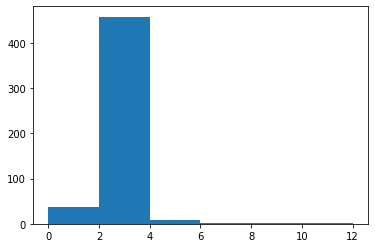

In [249]:
plt.hist(trasme['Amarre calculado (horas)'][(trasme['Año Servicio']==año) & (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')],
        bins=[0,2,4,6,8,10,12])

In [250]:
len(trasme[(trasme['Año Servicio']==año) & (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')]
   ) - np.array([ 37., 458.,   8.,   2.,   1.,   1.]).sum() 

104.0

(array([  1.,  10.,   0.,   0.,  47.,   2., 551.]),
 array([    0,  5000, 10000, 15000, 20000, 25000, 30000, 35000]),
 <a list of 7 Patch objects>)

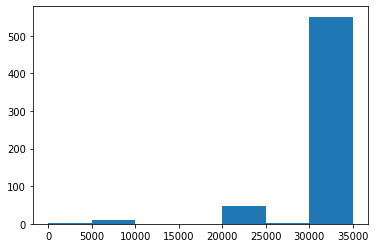

In [251]:
plt.hist(trasme['Potencia'][(trasme['Año Servicio']==año) & (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')],
        bins=[0,5000,10000,15000,20000,25000,30000,35000])

In [252]:
len(trasme[(trasme['Año Servicio']==año) & (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ')]
   ) - np.array([  1.,  10.,   0.,   0.,  47.,   2., 551.]).sum() 

0.0

In [237]:
# RoRo

In [253]:
len(trasme['Amarre calculado (horas)'][(trasme['Año Servicio']==año) & (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')])

160

(array([ 0.,  1.,  5.,  9.,  9., 40., 58.,  5.,  1.,  2.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
 <a list of 10 Patch objects>)

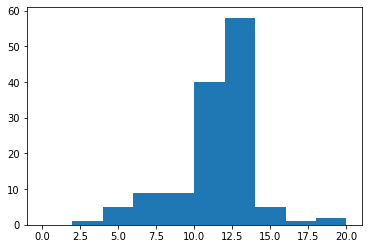

In [254]:
plt.hist(trasme['Amarre calculado (horas)'][(trasme['Año Servicio']==año) & (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')],
        bins=[0,2,4,6,8,10,12,14,16,18,20])

In [255]:
len(trasme[(trasme['Año Servicio']==año) & (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')]
   ) - np.array([ 0.,  1.,  5.,  9.,  9., 40., 58.,  5.,  1.,  2.]).sum() 

30.0

(array([  0.,  34.,   0.,   7.,   0.,   0., 119.]),
 array([    0,  5000, 10000, 15000, 20000, 25000, 30000, 35000]),
 <a list of 7 Patch objects>)

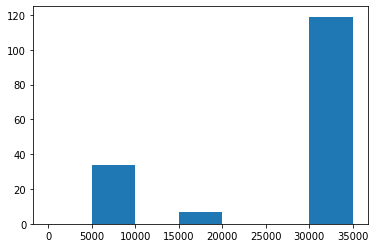

In [256]:
plt.hist(trasme['Potencia'][(trasme['Año Servicio']==año) & (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')],
        bins=[0,5000,10000,15000,20000,25000,30000,35000])

In [257]:
len(trasme[(trasme['Año Servicio']==año) & (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ')]
   ) - np.array([  0.,  34.,   0.,   7.,   0.,   0., 119.]).sum() 

0.0

#### Consums Trasme

In [179]:
buques_vessl_ihs['Tipo Buque'][buques_vessl_ihs.Buque=='CIUDAD DE IBIZA     ']

3135     FERRYS RO/RO PASAJEROS   
3199     FERRYS RO/RO PASAJEROS   
3201     FERRYS RO/RO PASAJEROS   
3214     FERRYS RO/RO PASAJEROS   
3215     FERRYS RO/RO PASAJEROS   
                   ...            
19758    FERRYS RO/RO PASAJEROS   
19759    FERRYS RO/RO PASAJEROS   
19761    FERRYS RO/RO PASAJEROS   
19821    FERRYS RO/RO PASAJEROS   
19822    FERRYS RO/RO PASAJEROS   
Name: Tipo Buque, Length: 756, dtype: object

In [22]:
# Conversión del Ciudad de Ibiza de RoRo a RoPax
trasme['Tipo Buque'][trasme.Buque=='CIUDAD DE IBIZA     '] = 'FERRYS RO/RO PASAJEROS   '

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
trasme.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'Unnamed: 18', 'Unnamed: 19', 'Manoeuvring', 'Unnamed: 21', 'ROPAX',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31', 'Unnamed: 32'],
      dtype='object')

In [98]:
# nombre de buques
trasme.Buque.unique()

array(['FORZA               ', 'JUAN J SISTER       ',
       'ZURBARAN            ', 'SUPER FAST LEVANTE  ',
       'EL DJAZAIR II       ', 'DIMONIOS            ',
       'NAPOLES             ', 'ALMARIYA            ',
       'SNAV ADRIATICO      ', 'CIUDAD DE IBIZA     ',
       'TENACIA             ', 'ALMUDAINA DOS       ',
       'CIUDAD DE PALMA     ', 'VOLCÁN DE TIJARAFE  ',
       'VOLCAN DE TENEGUIA  ', 'VOLCÁN DE TINAMAR   ',
       'CIUDAD DE MAHON     ', 'AL ANDALUS EXPRESS  ',
       'CIUDAD DE CADIZ     ', 'CIUDAD DE CEUTA     '], dtype=object)

In [99]:
# nombre de muelles
trasme['Muelle Atraque Real'].unique()

array(['PONIENTE-1               ', 'TRANSVERSALES            ',
       'LEVANTE 4                ', 'PONIENTE-2               ',
       'LEVANTE 1                ', 'LEVANTE 3                '],
      dtype=object)

In [100]:
# tipología buques
trasme['Tipo Buque'].unique()

array(['FERRYS RO/RO PASAJEROS   ', 'RO/RO  LO/LO             ',
       'RO/RO CARGA GENERAL      '], dtype=object)

In [180]:
buques_vessl_ihs[buques_vessl_ihs.buque_def=='ropax']

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25,Potencia_kW,terminal,buque_def,IMO,TotalPower,GT
55,2017,1 2017 16,9498743,VISEMAR ONE,FERRYS RO/RO PASAJEROS,26375.0,1,NaN,21600.0,TURIA,...,NaN,NaN,NaN,NaN,768.077,balea_otros,ropax,9498743.0,21600.0,26375.0
101,2017,1 2017 57,9019054,DENIA CIUTAT CREATIV,FERRYS RO/RO PASAJEROS,19308.0,1,NaN,18000.0,ESP.TUR.SUR-1,...,NaN,NaN,NaN,NaN,534.389,balea_otros,ropax,9019054.0,18000.0,19308.0
102,2017,1 2017 58,9019054,DENIA CIUTAT CREATIV,FERRYS RO/RO PASAJEROS,19308.0,1,NaN,18000.0,ESP.TUR.SUR-1,...,NaN,NaN,NaN,NaN,534.389,balea_otros,ropax,9019054.0,18000.0,19308.0
103,2017,1 2017 58,9019054,DENIA CIUTAT CREATIV,FERRYS RO/RO PASAJEROS,19308.0,2,NaN,18000.0,ESP.TUR.SUR-1,...,NaN,NaN,NaN,NaN,534.389,balea_otros,ropax,9019054.0,18000.0,19308.0
104,2017,1 2017 59,9019054,DENIA CIUTAT CREATIV,FERRYS RO/RO PASAJEROS,19308.0,1,NaN,18000.0,ESP.TUR.SUR-1,...,NaN,NaN,NaN,NaN,534.389,balea_otros,ropax,9019054.0,18000.0,19308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19837,2019,1 2019 6413,9498743,HEDY LAMARR,FERRYS RO/RO PASAJEROS,26375.0,1,NaN,21600.0,TURIA,...,NaN,NaN,NaN,NaN,768.077,balea_otros,ropax,9498743.0,21600.0,26375.0
19839,2019,1 2019 6416,9498743,HEDY LAMARR,FERRYS RO/RO PASAJEROS,26375.0,1,NaN,21600.0,TURIA,...,NaN,NaN,NaN,NaN,768.077,balea_otros,ropax,9498743.0,21600.0,26375.0
19840,2019,1 2019 6424,9237644,CIUDAD DE CEUTA,FERRYS RO/RO PASAJEROS,6554.0,1,NaN,28320.0,TRANSVERSALES,...,NaN,NaN,NaN,NaN,768.077,trasme_cru,ropax,9237644.0,28320.0,6554.0
19843,2019,1 2019 6462,9137997,ROSALIND FRANKLIN,FERRYS RO/RO PASAJEROS,33958.0,1,NaN,23040.0,TURIA,...,NaN,NaN,NaN,NaN,768.077,balea_otros,ropax,9137997.0,23040.0,33958.0


In [23]:
# Clasificación ferris Trasme según tipología de buque

for each in trasme.Buque.unique():
    print(str(each) + str(trasme['Tipo Buque'][trasme.Buque==each].max()))

FORZA               FERRYS RO/RO PASAJEROS   
JUAN J SISTER       FERRYS RO/RO PASAJEROS   
ZURBARAN            FERRYS RO/RO PASAJEROS   
SUPER FAST LEVANTE  RO/RO  LO/LO             
EL DJAZAIR II       FERRYS RO/RO PASAJEROS   
DIMONIOS            FERRYS RO/RO PASAJEROS   
NAPOLES             FERRYS RO/RO PASAJEROS   
ALMARIYA            FERRYS RO/RO PASAJEROS   
SNAV ADRIATICO      FERRYS RO/RO PASAJEROS   
CIUDAD DE IBIZA     FERRYS RO/RO PASAJEROS   
TENACIA             FERRYS RO/RO PASAJEROS   
ALMUDAINA DOS       FERRYS RO/RO PASAJEROS   
CIUDAD DE PALMA     FERRYS RO/RO PASAJEROS   
VOLCÁN DE TIJARAFE  FERRYS RO/RO PASAJEROS   
VOLCAN DE TENEGUIA  RO/RO CARGA GENERAL      
VOLCÁN DE TINAMAR   FERRYS RO/RO PASAJEROS   
CIUDAD DE MAHON     FERRYS RO/RO PASAJEROS   
AL ANDALUS EXPRESS  RO/RO  LO/LO             
CIUDAD DE CADIZ     FERRYS RO/RO PASAJEROS   
CIUDAD DE CEUTA     FERRYS RO/RO PASAJEROS   


In [114]:
# # for each1, each2 in trasme['Tipo Buque'],trasme['Amarre calculado (horas)']:
#     if trasme'FERRYS RO/RO PASAJEROS   ':
#         if each2 <= t_active_ropax:
#             trasme['Potencia_kW'] = pot_ropax
#         else:
#             trasme['Potencia_kW'] = pot_ropax*(t_active_ropax/each2
#                                               )+pot_ropax_inac*((each2
#                                                                  -t_active_ropax)/each2)
#     else:
#         if each2 <= t_active_roro:
#             trasme['Potencia_kW'] = pot_roro
#         else:
#             trasme['Potencia_kW'] = pot_roro*(t_active_roro/each2
#                                               )+pot_roro_inac*((each2
#                                                                  -t_active_roro)/each2)

In [26]:
trasme['Potencia_kW']=""

# potencias ropax
trasme.Potencia_kW[(trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ') &
                  (trasme['Amarre calculado (horas)']<=t_active_ropax)] = pot_ropax

trasme.Potencia_kW[(trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ') & 
                   (trasme['Amarre calculado (horas)']>t_active_ropax)] = pot_ropax*(t_active_ropax/trasme['Amarre calculado (horas)'][
                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ') &
                   (trasme['Amarre calculado (horas)']>t_active_ropax)]
                                              )+pot_ropax_inac*((trasme['Amarre calculado (horas)'][
                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ') &
                   (trasme['Amarre calculado (horas)']>t_active_ropax)]-t_active_ropax)/trasme['Amarre calculado (horas)'][
                   (trasme['Tipo Buque']=='FERRYS RO/RO PASAJEROS   ') & (trasme['Amarre calculado (horas)']>t_active_ropax)])

# potencias roro
trasme.Potencia_kW[(trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ') &
                  (trasme['Amarre calculado (horas)']<=t_active_roro)] = pot_roro

trasme.Potencia_kW[(trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ') & 
                   (trasme['Amarre calculado (horas)']>t_active_roro)] = pot_roro*(t_active_roro/trasme['Amarre calculado (horas)'][
                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ') &
                   (trasme['Amarre calculado (horas)']>t_active_roro)]
                                              )+pot_roro_inac*((trasme['Amarre calculado (horas)'][
                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ') &
                   (trasme['Amarre calculado (horas)']>t_active_roro)]-t_active_roro)/trasme['Amarre calculado (horas)'][
                   (trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ') & (trasme['Amarre calculado (horas)']>t_active_roro)])

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\badria\AppD

In [27]:
trasme.Potencia_kW = trasme.Potencia_kW.astype('float')

In [28]:
trasme[(trasme['Tipo Buque']!='FERRYS RO/RO PASAJEROS   ') & 
                   (trasme['Amarre calculado (horas)']>t_active_ropax)]

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,Tipo Maniobra,Fecha de Fin del Servicio,Hora de Fin del Servicio,Fecha de Inicio de Servicio,Hora de Inicio del Servicio,FH. Amarre Calc,FH. Desamarre Calc,Amarre calculado (horas),Potencia_kW
13,2017,1 2017 239,9204362,SUPER FAST LEVANTE,RO/RO LO/LO,17505,1,NaN,34300,TRANSVERSALES,Amarre,2017-01-09,705,2017-01-09,655,2017-01-09 07:05:00,2017-01-10 20:00:00,36.916667,500.0
28,2017,1 2017 312,9204362,SUPER FAST LEVANTE,RO/RO LO/LO,17505,1,NaN,34300,LEVANTE 4,Amarre,2017-01-12,810,2017-01-12,755,2017-01-12 08:10:00,2017-01-12 20:15:00,12.083333,500.0
52,2017,1 2017 437,9204362,SUPER FAST LEVANTE,RO/RO LO/LO,17505,1,NaN,34300,LEVANTE 4,Amarre,2017-01-17,805,2017-01-17,745,2017-01-17 08:05:00,2017-01-17 20:10:00,12.083333,500.0
54,2017,1 2017 441,9204362,SUPER FAST LEVANTE,RO/RO LO/LO,17505,3,NaN,34300,TRANSVERSALES,Amarre,2017-01-19,1410,2017-01-19,1315,2017-01-19 14:10:00,2017-01-23 00:00:00,81.833333,500.0
55,2017,1 2017 469,9204362,SUPER FAST LEVANTE,RO/RO LO/LO,17505,2,NaN,34300,LEVANTE 4,Amarre,2017-01-26,1950,2017-01-26,1935,2017-01-26 19:50:00,2017-01-27 02:00:00,6.166667,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2019,1 2019 6209,8512152,AL ANDALUS EXPRESS,RO/RO LO/LO,14411,1,NaN,18020,TRANSVERSALES,Amarre,2019-12-02,725,2019-12-02,705,2019-12-02 07:25:00,2019-12-02 20:20:00,12.916667,500.0
2269,2019,1 2019 6210,8512152,AL ANDALUS EXPRESS,RO/RO LO/LO,14411,1,NaN,18020,LEVANTE 4,Amarre,2019-12-04,1120,2019-12-04,1105,2019-12-04 11:20:00,2019-12-04 20:40:00,9.333333,500.0
2270,2019,1 2019 6211,8512152,AL ANDALUS EXPRESS,RO/RO LO/LO,14411,1,NaN,18020,TRANSVERSALES,Amarre,2019-12-06,715,2019-12-06,705,2019-12-06 07:15:00,2019-12-08 19:50:00,60.583333,500.0
2285,2019,1 2019 6328,8512152,AL ANDALUS EXPRESS,RO/RO LO/LO,14411,1,NaN,18020,TRANSVERSALES,Amarre,2019-12-10,745,2019-12-10,735,2019-12-10 07:45:00,2019-12-10 19:50:00,12.083333,500.0


In [37]:
trasme.sort_values(by=['FH. Amarre Calc'])

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,Tipo Maniobra,Fecha de Fin del Servicio,Hora de Fin del Servicio,Fecha de Inicio de Servicio,Hora de Inicio del Servicio,FH. Amarre Calc,FH. Desamarre Calc,Amarre calculado (horas),Potencia_kW
5,2017,1 2017 131,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-02,1855,2017-01-02,1845,2017-01-02 18:55:00,2017-01-02 22:25:00,3.500000,750
6,2017,1 2017 132,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-03,1855,2017-01-03,1845,2017-01-03 18:55:00,2017-01-03 22:40:00,3.750000,750
0,2017,1 2017 107,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,PONIENTE-1,Amarre,2017-01-03,1935,2017-01-03,1925,2017-01-03 19:35:00,2017-01-03 22:50:00,3.250000,750
7,2017,1 2017 133,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-04,1850,2017-01-04,1840,2017-01-04 18:50:00,2017-01-04 22:20:00,3.500000,750
1,2017,1 2017 108,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,PONIENTE-1,Amarre,2017-01-04,1935,2017-01-04,1925,2017-01-04 19:35:00,2017-01-04 22:50:00,3.250000,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,2019,1 2019 6350,9263370,CIUDAD DE IBIZA,FERRYS RO/RO PASAJEROS,16686,1,NaN,34262,TRANSVERSALES,Amarre,2019-12-11,1855,2019-12-11,1845,2019-12-11 18:55:00,2019-12-11 22:30:00,3.583333,750
2288,2019,1 2019 6333,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,LEVANTE 4,Amarre,2019-12-11,1920,2019-12-11,1905,2019-12-11 19:20:00,2019-12-11 22:55:00,3.583333,750
2286,2019,1 2019 6330,8512152,AL ANDALUS EXPRESS,RO/RO LO/LO,14411,1,NaN,18020,TRANSVERSALES,Amarre,2019-12-12,720,2019-12-12,705,2019-12-12 07:20:00,2019-12-12 19:55:00,12.583333,500
2291,2019,1 2019 6352,9263370,CIUDAD DE IBIZA,FERRYS RO/RO PASAJEROS,16686,1,NaN,34262,TRANSVERSALES,Amarre,2019-12-12,1900,2019-12-12,1840,2019-12-12 19:00:00,2019-12-12 22:45:00,3.750000,750


In [124]:
trasme[trasme['Amarre calculado (horas)']>t_active_ropax].describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),Potencia_kW
count,773.000000,7.730000e+02,773.000000,773.000000,0.0,773.000000,773.000000,773.000000,773.000000,773.000000
mean,2018.033635,9.237333e+06,19299.675291,1.038810,NaN,31280.619664,1114.927555,1087.289780,18.483851,536.891894
std,0.823179,2.122146e+05,4200.204201,0.218437,NaN,6910.790800,527.692003,525.142402,15.048110,57.805166
min,2017.000000,7.928811e+06,4662.000000,1.000000,NaN,1000.000000,10.000000,0.000000,4.000000,500.000000
25%,2017.000000,9.204362e+06,17505.000000,1.000000,NaN,32184.000000,750.000000,735.000000,11.750000,500.000000
50%,2018.000000,9.204362e+06,17505.000000,1.000000,NaN,34262.000000,810.000000,755.000000,14.166667,500.000000
75%,2019.000000,9.335161e+06,22940.000000,1.000000,NaN,34300.000000,1850.000000,1835.000000,24.416667,565.217391
max,2019.000000,9.506291e+06,31910.000000,3.000000,NaN,34300.000000,2359.000000,2345.000000,146.266667,750.000000


In [105]:
trasme.Potencia_kW.describe()

count    2294.000000
mean      677.862875
std       106.351904
min       500.000000
25%       564.603313
50%       750.000000
75%       750.000000
max       750.000000
Name: Potencia_kW, dtype: float64

In [126]:
balearia.describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas),Potencia_kW
count,2490.000000,2.490000e+03,2490.000000,2490.000000,0.0,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000
mean,2017.971084,9.087215e+06,24355.640562,1.047390,NaN,26568.002811,1715.574297,1694.148594,6.863487,697.460762
std,0.820077,6.596656e+05,5263.565387,0.286574,NaN,3095.634410,404.891758,405.069768,8.402413,79.232035
min,2017.000000,7.356252e+06,4112.000000,1.000000,NaN,13887.000000,35.000000,20.000000,0.166667,513.888889
25%,2017.000000,9.137997e+06,20238.000000,1.000000,NaN,25645.000000,1840.000000,1825.000000,2.250000,621.521336
50%,2018.000000,9.441130e+06,26375.000000,1.000000,NaN,25696.000000,1905.000000,1855.000000,3.250000,750.000000
75%,2019.000000,9.498743e+06,26375.000000,1.000000,NaN,29376.000000,1945.000000,1930.000000,8.229167,750.000000
max,2019.000000,9.498767e+06,33958.000000,8.000000,NaN,30897.000000,2355.000000,2335.000000,72.000000,750.000000


#### Simuntaneidad Trasme

##### For loop (deprecated)

In [236]:
ini_escala = trasme['FH. Amarre Calc']
duracion = trasme['Amarre calculado (horas)']
fin_escala = trasme['FH. Desamarre Calc']
# duracion = pd.to_timedelta(ropax['Suma tiempo amarres (horas)'], unit='hour').dt.round('1s')
# fin_escala = (ini_escala + duracion).dt.round('1s')
# fin_escala = ropax['Salida de Puerto']

In [198]:
trasme.sort_values(by=['FH. Amarre Calc'])

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,Tipo Maniobra,Fecha de Fin del Servicio,Hora de Fin del Servicio,Fecha de Inicio de Servicio,Hora de Inicio del Servicio,FH. Amarre Calc,FH. Desamarre Calc,Amarre calculado (horas),Potencia_kW
5,2017,1 2017 131,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-02,1855,2017-01-02,1845,2017-01-02 18:55:00,2017-01-02 22:25:00,3.500000,750.000000
6,2017,1 2017 132,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-03,1855,2017-01-03,1845,2017-01-03 18:55:00,2017-01-03 22:40:00,3.750000,750.000000
0,2017,1 2017 107,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,PONIENTE-1,Amarre,2017-01-03,1935,2017-01-03,1925,2017-01-03 19:35:00,2017-01-03 22:50:00,3.250000,750.000000
7,2017,1 2017 133,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-04,1850,2017-01-04,1840,2017-01-04 18:50:00,2017-01-04 22:20:00,3.500000,750.000000
1,2017,1 2017 108,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,PONIENTE-1,Amarre,2017-01-04,1935,2017-01-04,1925,2017-01-04 19:35:00,2017-01-04 22:50:00,3.250000,750.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,2019,1 2019 6350,9263370,CIUDAD DE IBIZA,FERRYS RO/RO PASAJEROS,16686,1,NaN,34262,TRANSVERSALES,Amarre,2019-12-11,1855,2019-12-11,1845,2019-12-11 18:55:00,2019-12-11 22:30:00,3.583333,750.000000
2288,2019,1 2019 6333,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,LEVANTE 4,Amarre,2019-12-11,1920,2019-12-11,1905,2019-12-11 19:20:00,2019-12-11 22:55:00,3.583333,750.000000
2286,2019,1 2019 6330,8512152,AL ANDALUS EXPRESS,RO/RO LO/LO,14411,1,NaN,18020,TRANSVERSALES,Amarre,2019-12-12,720,2019-12-12,705,2019-12-12 07:20:00,2019-12-12 19:55:00,12.583333,322.516556
2291,2019,1 2019 6352,9263370,CIUDAD DE IBIZA,FERRYS RO/RO PASAJEROS,16686,1,NaN,34262,TRANSVERSALES,Amarre,2019-12-12,1900,2019-12-12,1840,2019-12-12 19:00:00,2019-12-12 22:45:00,3.750000,750.000000


In [237]:
sim_trasme = pd.DataFrame(np.zeros(shape=(len(trasme),3*8760-19*24)),index = trasme.index, 
                         columns = pd.date_range('2017-01-01', '2019-12-13', freq='1H', closed='left'))

sim_trasme.insert(0, 'ini_escala', ini_escala)
sim_trasme.insert(1, 'duracion', duracion)
sim_trasme.insert(2, 'fin_escala', fin_escala)
# sim_trasme.insert(3,'pot_media',potencia_media)

sim_trasme = sim_trasme.reset_index(drop=True)
sim_trasme

,ini_escala,duracion,fin_escala,2017-01-01 00:00:00,2017-01-01 01:00:00,2017-01-01 02:00:00,2017-01-01 03:00:00,2017-01-01 04:00:00,2017-01-01 05:00:00,2017-01-01 06:00:00,...,2019-12-12 14:00:00,2019-12-12 15:00:00,2019-12-12 16:00:00,2019-12-12 17:00:00,2019-12-12 18:00:00,2019-12-12 19:00:00,2019-12-12 20:00:00,2019-12-12 21:00:00,2019-12-12 22:00:00,2019-12-12 23:00:00
0,2017-01-03 19:35:00,3.250000,2017-01-03 22:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-04 19:35:00,3.250000,2017-01-04 22:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-06 19:20:00,3.416667,2017-01-06 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-07 19:30:00,1.750000,2017-01-07 21:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-05 19:35:00,3.166667,2017-01-05 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,2019-12-12 19:30:00,3.666667,2019-12-12 23:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2290,2019-12-11 18:55:00,3.583333,2019-12-11 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2291,2019-12-12 19:00:00,3.750000,2019-12-12 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2292,2019-12-05 08:45:00,97.166667,2019-12-09 09:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [238]:
for i in range(0,len(sim_trasme.index)):
    for j in sim_trasme.columns.values[3:]:
        if ((j+1) >= sim_trasme.ini_escala[i]) & (j < sim_trasme.fin_escala[i]): 
            sim_trasme.loc[i,j] = 1

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`



(737060.0, 737406.0)

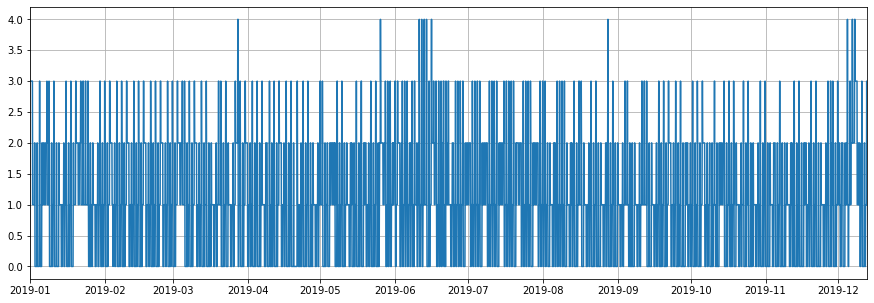

In [239]:
# simultaneidad Trasme
figure(figsize=(15,5))
plt.plot(sim_trasme.iloc[:,3:].sum())
plt.grid(True)
plt.xlim(['2019-01-01','2019-12-13'])


(array([0.42255266, 0.35625774, 0.18293061, 0.0363228 , 0.00193618]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

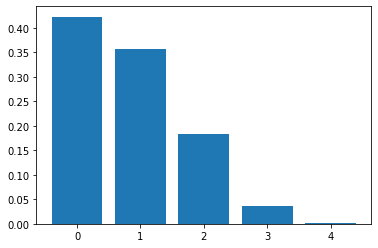

In [391]:
x = sim_trasme.iloc[:,3:].sum()

plt.hist(x=x,bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.8, density=True)

In [380]:
0.42255266+ 0.35625774+ 0.18293061+ 0.0363228 + 0.00193618

0.99999999

In [379]:
print('nº ferris Trasme')
print('-------------')
# print('\n')
print(str(round(len(x[x==0])*100/len(x),2)) + ' % del tiempo sin cruceros atracados')
print(str(round(len(x[x==1])*100/len(x),2)) + ' % de horas con 1 crucero')
print(str(round(len(x[x==2])*100/len(x),2)) + ' % de horas con 2 simultaneos')
print(str(round(len(x[x==3])*100/len(x),2)) + ' % de horas con 3 simultaneos')
print(str(round(len(x[x==4])*100/len(x),2)) + ' % de horas con 4 simultaneos')

print('-------------')
print('Considerando solo el tiempo que hay al menos un crucero:')
print(str(round(len(x[x==1])*100/len(x[x!=0]),2)) + ' % de horas con 1 crucero')
print(str(round(len(x[x==2])*100/len(x[x!=0]),2)) + ' % de horas con 2 simultaneos')
print(str(round(len(x[x==3])*100/len(x[x!=0]),2)) + ' % de horas con 3 simultaneos')
print(str(round(len(x[x==4])*100/len(x[x!=0]),2)) + ' % de horas con 4 simultaneos')

nº ferris Trasme
-------------
42.26 % del tiempo sin cruceros atracados
35.63 % de horas con 1 crucero
18.29 % de horas con 2 simultaneos
3.63 % de horas con 3 simultaneos
0.19 % de horas con 4 simultaneos
-------------
Considerando solo el tiempo que hay al menos un crucero:
61.7 % de horas con 1 crucero
31.68 % de horas con 2 simultaneos
6.29 % de horas con 3 simultaneos
0.34 % de horas con 4 simultaneos


In [393]:
# with loop, les accurate
x.loc['2017-01-03']

2017-01-03 00:00:00    0.0
2017-01-03 01:00:00    0.0
2017-01-03 02:00:00    0.0
2017-01-03 03:00:00    0.0
2017-01-03 04:00:00    0.0
2017-01-03 05:00:00    0.0
2017-01-03 06:00:00    0.0
2017-01-03 07:00:00    0.0
2017-01-03 08:00:00    0.0
2017-01-03 09:00:00    0.0
2017-01-03 10:00:00    0.0
2017-01-03 11:00:00    0.0
2017-01-03 12:00:00    0.0
2017-01-03 13:00:00    0.0
2017-01-03 14:00:00    0.0
2017-01-03 15:00:00    0.0
2017-01-03 16:00:00    0.0
2017-01-03 17:00:00    0.0
2017-01-03 18:00:00    1.0
2017-01-03 19:00:00    2.0
2017-01-03 20:00:00    2.0
2017-01-03 21:00:00    2.0
2017-01-03 22:00:00    2.0
2017-01-03 23:00:00    0.0
dtype: float64

In [390]:
# NO loop
x.loc['2017-01-03']

TS
2017-01-03 00:00:00    0.0
2017-01-03 01:00:00    0.0
2017-01-03 02:00:00    0.0
2017-01-03 03:00:00    0.0
2017-01-03 04:00:00    0.0
2017-01-03 05:00:00    0.0
2017-01-03 06:00:00    0.0
2017-01-03 07:00:00    0.0
2017-01-03 08:00:00    0.0
2017-01-03 09:00:00    0.0
2017-01-03 10:00:00    0.0
2017-01-03 11:00:00    0.0
2017-01-03 12:00:00    0.0
2017-01-03 13:00:00    0.0
2017-01-03 14:00:00    0.0
2017-01-03 15:00:00    0.0
2017-01-03 16:00:00    0.0
2017-01-03 17:00:00    0.0
2017-01-03 18:00:00    0.0
2017-01-03 19:00:00    1.0
2017-01-03 20:00:00    2.0
2017-01-03 21:00:00    2.0
2017-01-03 22:00:00    2.0
2017-01-03 23:00:00    0.0
Freq: H, Name: ships, dtype: float64

In [395]:
# traffic_trasme.loc['2017-01-03']

In [ ]:
# simultaneidad Trasme
figure(figsize=(15,5))
plt.plot(sim_trasme.iloc[:,3:].sum())
plt.grid(True)
plt.xlim(['2019-01-01','2019-12-13'])


##### dfIN, dfOUT

In [29]:
dfIN = trasme[['FH. Amarre Calc','Potencia_kW']]
dfOUT = trasme[['FH. Desamarre Calc','Potencia_kW']]
dfIN['direction'] = 1
dfOUT['direction'] = -1

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
dfIN.columns = ('TS','pot_media','direction')
dfOUT.columns = ('TS','pot_media','direction')

In [31]:
traffic_trasme = pd.concat([dfIN, dfOUT]).sort_values('TS')

In [32]:
traffic_trasme.pot_media = traffic_trasme.pot_media*traffic_trasme.direction

In [33]:
traffic_trasme['ships'] = traffic_trasme['direction'].cumsum()
traffic_trasme['cum_pot'] = traffic_trasme['pot_media'].cumsum()

In [34]:
traffic_trasme = traffic_trasme.round()

(737060.0, 737406.0)

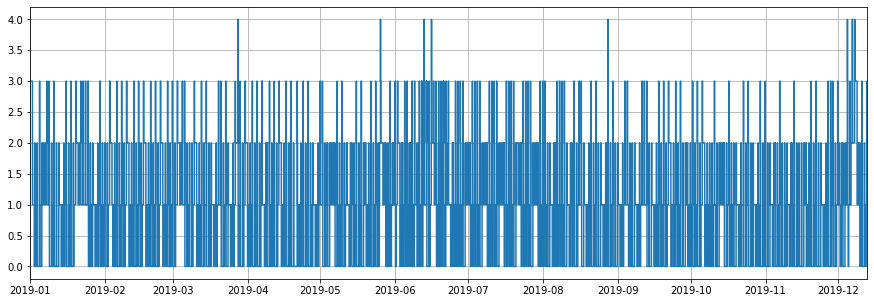

In [35]:
figure(figsize=(15,5))

plt.step(traffic_trasme.TS,traffic_trasme.ships, where='post')
plt.grid(True)
# plt.xlim(['2017-01-20','2017-01-21'])
plt.xlim(['2019-01-01','2019-12-13'])


(737060.0, 737406.0)

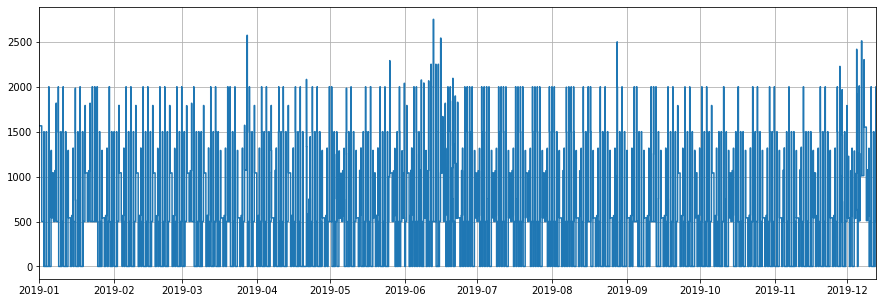

In [36]:
a = figure(figsize=(15,5))

plt.step(traffic_trasme.TS,traffic_trasme.cum_pot, where='post')
plt.grid(True)
plt.xlim(['2019-01-01','2019-12-13'])
# plt.xlim(['2017-01-20 18','2017-01-20 22'])
# plt.ylim([10000,30000])

In [37]:
traffic_trasme.describe()

,pot_media,direction,ships,cum_pot
count,4588.000000,4588.000000,4588.000000,4588.000000
mean,0.000000,0.000000,1.302528,852.078248
std,686.228158,1.000109,0.893023,601.290740
min,-750.000000,-1.000000,0.000000,0.000000
25%,-750.000000,-1.000000,1.000000,500.000000
50%,0.000000,0.000000,1.000000,750.000000
75%,750.000000,1.000000,2.000000,1291.000000
max,750.000000,1.000000,4.000000,2750.000000


In [38]:
trasme.sort_values(by='FH. Amarre Calc')

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,Tipo Maniobra,Fecha de Fin del Servicio,Hora de Fin del Servicio,Fecha de Inicio de Servicio,Hora de Inicio del Servicio,FH. Amarre Calc,FH. Desamarre Calc,Amarre calculado (horas),Potencia_kW
5,2017,1 2017 131,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-02,1855,2017-01-02,1845,2017-01-02 18:55:00,2017-01-02 22:25:00,3.500000,750.0
6,2017,1 2017 132,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-03,1855,2017-01-03,1845,2017-01-03 18:55:00,2017-01-03 22:40:00,3.750000,750.0
0,2017,1 2017 107,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,PONIENTE-1,Amarre,2017-01-03,1935,2017-01-03,1925,2017-01-03 19:35:00,2017-01-03 22:50:00,3.250000,750.0
7,2017,1 2017 133,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,Amarre,2017-01-04,1850,2017-01-04,1840,2017-01-04 18:50:00,2017-01-04 22:20:00,3.500000,750.0
1,2017,1 2017 108,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,PONIENTE-1,Amarre,2017-01-04,1935,2017-01-04,1925,2017-01-04 19:35:00,2017-01-04 22:50:00,3.250000,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,2019,1 2019 6350,9263370,CIUDAD DE IBIZA,FERRYS RO/RO PASAJEROS,16686,1,NaN,34262,TRANSVERSALES,Amarre,2019-12-11,1855,2019-12-11,1845,2019-12-11 18:55:00,2019-12-11 22:30:00,3.583333,750.0
2288,2019,1 2019 6333,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,LEVANTE 4,Amarre,2019-12-11,1920,2019-12-11,1905,2019-12-11 19:20:00,2019-12-11 22:55:00,3.583333,750.0
2286,2019,1 2019 6330,8512152,AL ANDALUS EXPRESS,RO/RO LO/LO,14411,1,NaN,18020,TRANSVERSALES,Amarre,2019-12-12,720,2019-12-12,705,2019-12-12 07:20:00,2019-12-12 19:55:00,12.583333,500.0
2291,2019,1 2019 6352,9263370,CIUDAD DE IBIZA,FERRYS RO/RO PASAJEROS,16686,1,NaN,34262,TRANSVERSALES,Amarre,2019-12-12,1900,2019-12-12,1840,2019-12-12 19:00:00,2019-12-12 22:45:00,3.750000,750.0


In [39]:


traffic_trasme.TS = traffic_trasme.TS + pd.to_timedelta(traffic_trasme.groupby('TS').cumcount(), unit='ms')

In [43]:
traffic_trasme.TS
# pd.to_timedelta(traffic_trasme.groupby('TS').cumcount(), unit='ms')

5      2017-01-02 18:55:00
5      2017-01-02 22:25:00
6      2017-01-03 18:55:00
0      2017-01-03 19:35:00
6      2017-01-03 22:40:00
               ...        
2291   2019-12-12 19:00:00
2289   2019-12-12 19:30:00
2286   2019-12-12 19:55:00
2291   2019-12-12 22:45:00
2289   2019-12-12 23:10:00
Name: TS, Length: 4588, dtype: datetime64[ns]

In [40]:
traffic_trasme.TS.is_unique

True

In [71]:
print(len(traffic_trasme[traffic_trasme.TS.duplicated()==True]))

0


In [72]:
traffic_trasme = traffic_trasme.set_index('TS')#.resample('h')

In [73]:
### ---------------------------------------------------------- ###
### función que da el valor acumulado de potencias por horas
### ---------------------------------------------------------- ###

traffic_trasme.resample('1H').ffill().fillna(0).head(10)#.groupby('TS').sum()

,pot_media,direction,ships,cum_pot
TS,,,,
2017-01-02 18:00:00,0.0,0.0,0.0,0.0
2017-01-02 19:00:00,750.0,1.0,1.0,750.0
2017-01-02 20:00:00,750.0,1.0,1.0,750.0
2017-01-02 21:00:00,750.0,1.0,1.0,750.0
2017-01-02 22:00:00,750.0,1.0,1.0,750.0
2017-01-02 23:00:00,-750.0,-1.0,0.0,0.0
2017-01-03 00:00:00,-750.0,-1.0,0.0,0.0
2017-01-03 01:00:00,-750.0,-1.0,0.0,0.0
2017-01-03 02:00:00,-750.0,-1.0,0.0,0.0


(737060.0, 737406.0)

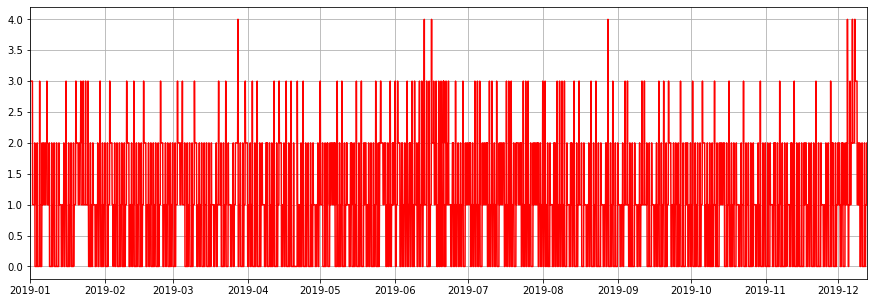

In [74]:
a = figure(figsize=(15,5))

x = traffic_trasme.resample('1H').ffill().index
y = traffic_trasme.resample('1H').ffill().fillna(0).ships

plt.plot(x,y,'r')
plt.grid(True)
plt.xlim(['2019-12-10','2019-12-13'])
plt.xlim(['2019-01-01','2019-12-13'])

(array([0.4552013 , 0.36114343, 0.1618959 , 0.02071212, 0.00104724]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

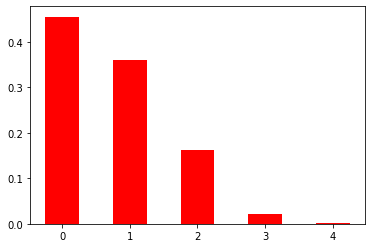

In [75]:
x = traffic_trasme.resample('1H').ffill().fillna(0).ships

plt.hist(x=x,bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5],density=True, rwidth=0.5, color='r')
# plt.grid(True)

In [344]:
0.4552013 + 0.36114343+ 0.1618959 + 0.02071212+ 0.00104724

0.99999999

In [68]:
print('nº ferris Trasme')
print('-------------')
# print('\n')
print(str(round(len(x[x==0])*100/len(x),2)) + ' % del tiempo sin cruceros atracados')
print(str(round(len(x[x==1])*100/len(x),2)) + ' % de horas con 1 crucero')
print(str(round(len(x[x==2])*100/len(x),2)) + ' % de horas con 2 simultaneos')
print(str(round(len(x[x==3])*100/len(x),2)) + ' % de horas con 3 simultaneos')
print(str(round(len(x[x==4])*100/len(x),2)) + ' % de horas con 4 simultaneos')

print('-------------')
print('Considerando solo el tiempo que hay al menos un crucero:')
print(str(round(len(x[x==1])*100/len(x[x!=0]),2)) + ' % de horas con 1 crucero')
print(str(round(len(x[x==2])*100/len(x[x!=0]),2)) + ' % de horas con 2 simultaneos')
print(str(round(len(x[x==3])*100/len(x[x!=0]),2)) + ' % de horas con 3 simultaneos')
print(str(round(len(x[x==4])*100/len(x[x!=0]),2)) + ' % de horas con 4 simultaneos')

nº ferris Trasme
-------------
45.52 % del tiempo sin cruceros atracados
36.11 % de horas con 1 crucero
16.19 % de horas con 2 simultaneos
2.07 % de horas con 3 simultaneos
0.1 % de horas con 4 simultaneos
-------------
Considerando solo el tiempo que hay al menos un crucero:
66.29 % de horas con 1 crucero
29.72 % de horas con 2 simultaneos
3.8 % de horas con 3 simultaneos
0.19 % de horas con 4 simultaneos


(737060.0, 737406.0)

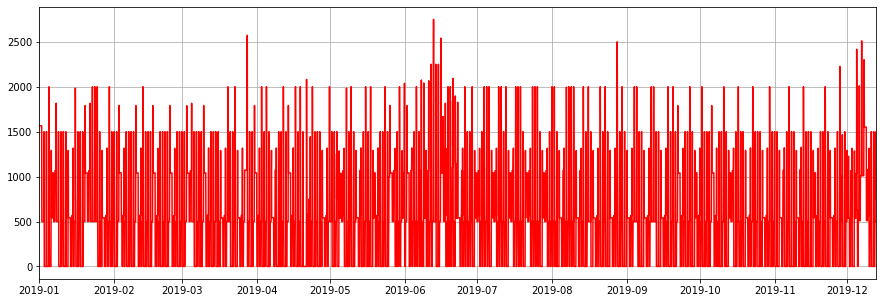

In [76]:
a = figure(figsize=(15,5))

x = traffic_trasme.resample('1H').ffill().index
y = traffic_trasme.resample('1H').ffill().fillna(0).cum_pot

plt.plot(x,y,'r')
plt.grid(True)
plt.xlim(['2019-12-10','2019-12-13'])
plt.xlim(['2019-01-01','2019-12-13'])

In [77]:
sim = pd.concat([traffic_trasme.resample('1H').ffill().fillna(0).ships,
                 traffic_trasme.resample('1H').ffill().fillna(0).cum_pot], axis=1)
sim.to_excel("sim_trasme.xlsx")

(array([1.1736e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9950e+03,
        3.6590e+03, 3.1000e+01, 6.2600e+02, 0.0000e+00, 9.0000e+01,
        1.6920e+03, 3.9000e+01, 8.7300e+02, 2.5000e+01, 1.4550e+03,
        8.6000e+01, 8.0000e+00, 1.6100e+02, 1.0000e+01, 2.2000e+02,
        2.7000e+01, 5.0000e+00, 2.0000e+01, 5.0000e+00, 1.0000e+01,
        5.0000e+00, 4.0000e+00]),
 array([   0.        ,  101.85185185,  203.7037037 ,  305.55555556,
         407.40740741,  509.25925926,  611.11111111,  712.96296296,
         814.81481481,  916.66666667, 1018.51851852, 1120.37037037,
        1222.22222222, 1324.07407407, 1425.92592593, 1527.77777778,
        1629.62962963, 1731.48148148, 1833.33333333, 1935.18518519,
        2037.03703704, 2138.88888889, 2240.74074074, 2342.59259259,
        2444.44444444, 2546.2962963 , 2648.14814815, 2750.        ]),
 <a list of 27 Patch objects>)

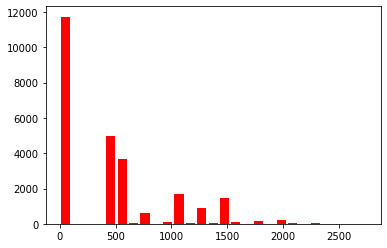

In [75]:
x = traffic_trasme.resample('1H').ffill().fillna(0).cum_pot

plt.hist(x=x,bins=27, rwidth= 0.8, color='r')
# plt.grid(True)

In [76]:
print('Power Trasme')
print('-------------------')
# print('\n')
print(str(round(len(x[x==0])*100/len(x),2)) + ' % del tiempo sin cruceros atracados')
print(str(round(len(x[(x>0) & (x<=500)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1 y 500 kW')
print(str(round(len(x[(x>500) & (x<=1000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 500 y 1000 kW')
print(str(round(len(x[(x>1000) & (x<=1500)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1000 y 1500 kW')
print(str(round(len(x[(x>1500) & (x<=2000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1500 y 2000 kW')
print(str(round(len(x[x>2000])*100/len(x),2)) + ' % de horas con pot acumulada mayor de 2000 kW')

print('-------------------')
print('Considerando solo el tiempo que hay al menos un crucero:')
print(str(round(len(x[(x>0) & (x<=500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1 y 500 kW')
print(str(round(len(x[(x>500) & (x<=1000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 500 y 1000 kW')
print(str(round(len(x[(x>1000) & (x<=1500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1000 y 1500 kW')
print(str(round(len(x[(x>1500) & (x<=2000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1500 y 2000 kW')
print(str(round(len(x[x>2000])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada mayor de 2000 kW')

Power Trasme
-------------------
45.52 % del tiempo sin cruceros atracados
19.02 % de horas con pot acumulada entre 1 y 500 kW
17.18 % de horas con pot acumulada entre 500 y 1000 kW
16.1 % de horas con pot acumulada entre 1000 y 1500 kW
1.8 % de horas con pot acumulada entre 1500 y 2000 kW
0.38 % de horas con pot acumulada mayor de 2000 kW
-------------------
Considerando solo el tiempo que hay al menos un crucero:
34.91 % de horas con pot acumulada entre 1 y 500 kW
31.54 % de horas con pot acumulada entre 500 y 1000 kW
29.55 % de horas con pot acumulada entre 1000 y 1500 kW
3.3 % de horas con pot acumulada entre 1500 y 2000 kW
0.69 % de horas con pot acumulada mayor de 2000 kW


In [364]:
x[x<100]

TS
2017-01-02 18:00:00    0.0
2017-01-02 23:00:00    0.0
2017-01-03 00:00:00    0.0
2017-01-03 01:00:00    0.0
2017-01-03 02:00:00    0.0
                      ... 
2019-12-12 03:00:00   -0.0
2019-12-12 04:00:00   -0.0
2019-12-12 05:00:00   -0.0
2019-12-12 06:00:00   -0.0
2019-12-12 07:00:00   -0.0
Name: cum_pot, Length: 11736, dtype: float64

In [77]:
traffic_trasme.resample('1H').ffill().fillna(0).cum_pot

TS
2017-01-02 18:00:00       0.0
2017-01-02 19:00:00     750.0
2017-01-02 20:00:00     750.0
2017-01-02 21:00:00     750.0
2017-01-02 22:00:00     750.0
                        ...  
2019-12-12 19:00:00    1250.0
2019-12-12 20:00:00    1500.0
2019-12-12 21:00:00    1500.0
2019-12-12 22:00:00    1500.0
2019-12-12 23:00:00     750.0
Freq: H, Name: cum_pot, Length: 25782, dtype: float64

In [245]:
# idx_TS.resample('H').sum().tail(23)#.interpolate('time')
# agg(np.sum)
# df['A'].replace(to_replace=0, method='ffill')

In [78]:
traffic_trasme.tail(11)

,pot_media,direction,ships,cum_pot
TS,,,,
2019-12-10 22:55:00,-750.0,-1,0,0.0
2019-12-11 18:55:00,750.0,1,1,750.0
2019-12-11 19:20:00,750.0,1,2,1500.0
2019-12-11 22:30:00,-750.0,-1,1,750.0
2019-12-11 22:55:00,-750.0,-1,0,0.0
2019-12-12 07:20:00,500.0,1,1,500.0
2019-12-12 19:00:00,750.0,1,2,1250.0
2019-12-12 19:30:00,750.0,1,3,2000.0
2019-12-12 19:55:00,-500.0,-1,2,1500.0


In [313]:
traffic_trasme.head(8)

,TS,pot_media,direction,ships,cum_pot
5,2017-01-02 18:55:00,750.0,1,1,750.0
5,2017-01-02 22:25:00,-750.0,-1,0,0.0
6,2017-01-03 18:55:00,750.0,1,1,750.0
0,2017-01-03 19:35:00,750.0,1,2,1500.0
6,2017-01-03 22:40:00,-750.0,-1,1,750.0
0,2017-01-03 22:50:00,-750.0,-1,0,0.0
7,2017-01-04 18:50:00,750.0,1,1,750.0
1,2017-01-04 19:35:00,750.0,1,2,1500.0


(736968.0, 736999.0)

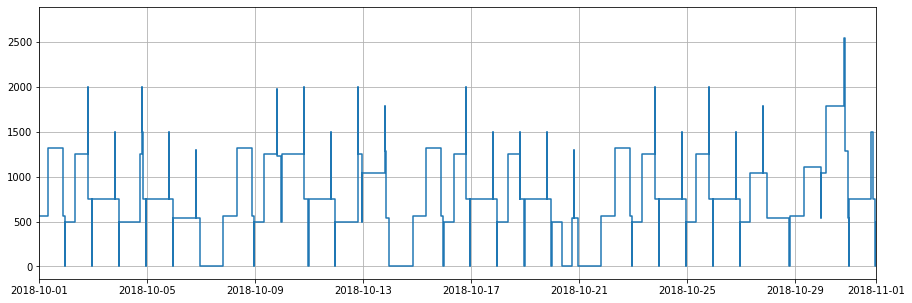

In [80]:
figure(figsize=(15,5))

plt.step(traffic_trasme.index,traffic_trasme.cum_pot)
plt.grid(True)
plt.xlim(['2018-10','2018-11'])

In [240]:
# ropax, consumo en escala

(10196*0.2*0.05) + (10196*0.16*0.4)

754.5040000000001

In [286]:
traffic_trasme.cum_pot.describe()

count    4588.000000
mean      716.102659
std       570.536984
min        -0.000000
25%       232.000000
50%       750.000000
75%      1082.000000
max      2441.000000
Name: cum_pot, dtype: float64

In [123]:
traffic_balearia.cum_pot.describe()

count    4980.000000
mean      695.497590
std       533.476285
min         0.000000
25%         0.000000
50%       750.000000
75%      1075.000000
max      2789.000000
Name: cum_pot, dtype: float64

#### Outdated

In [12]:
ferris_ro['Muelle Atraque Real'].unique()

array(['DIQUE DEL ESTE           ', 'TURIA                    ',
       'ESP.TUR.SUR-1            ', 'ESP.TUR.SUR-2            ',
       'PONIENTE-1               ', 'TRANSVERSALES            ',
       'TRANSV. DIQUE DEL ESTE   ', 'LEVANTE 4                ',
       'SUR                      ', 'NORTE(XITA)              ',
       'PONIENTE-2               ', 'CRUCEROS TRES            ',
       'LEVANTE 1                ', 'LEVANTE 3                ',
       'CRUCEROS UNO             ', 'ESP.TUR.NORTE-2          '],
      dtype=object)

In [166]:
ferris_ro_trasme = ferris_ro[(ferris_ro.Buque =='FORZA               ')|
                            (ferris_ro.Buque == 'ZURBARAN            ')|
                            (ferris_ro.Buque == 'DIMONIOS            ')|
                            (ferris_ro.Buque == 'SNAV ADRIATICO      ')|
                            (ferris_ro.Buque == 'TENACIA             ')|
                            (ferris_ro.Buque == 'CIUDAD DE PALMA     ')|
                            (ferris_ro.Buque == 'VOLCAN DE TENEGUIA  ')|
                            (ferris_ro.Buque == 'CIUDAD DE MAHON     ')|
                            (ferris_ro.Buque == 'CIUDAD DE CADIZ     ')|
                            (ferris_ro.Buque == 'JUAN J SISTER       ')|
                            (ferris_ro.Buque == 'SUPER FAST LEVANTE  ')|
                            (ferris_ro.Buque == 'SUPER FAST BALEARES ')|
                            (ferris_ro.Buque == 'ALMARIYA            ')|
                            (ferris_ro.Buque == 'CIUDAD DE IBIZA     ')|
                            (ferris_ro.Buque == 'ALMUDAINA DOS       ')|
                            (ferris_ro.Buque == 'VOLCÁN DE TIJARAFE  ')|
                            (ferris_ro.Buque == 'VOLCÁN DE TINAMAR   ')|
                            (ferris_ro.Buque == 'AL ANDALUS EXPRESS  ')|
                            (ferris_ro.Buque == 'CIUDAD DE CEUTA     ')
                           ]

In [33]:
# ferris_ro_trasme = ferris_ro[(ferris_ro['Muelle Atraque Real' ]=='PONIENTE-1               ')|
#                               (ferris_ro['Muelle Atraque Real' ]=='PONIENTE-2               ')|
#                               (ferris_ro['Muelle Atraque Real' ]=='LEVANTE 1                ')|
#                               (ferris_ro['Muelle Atraque Real' ]=='LEVANTE 3                ')|
#                               (ferris_ro['Muelle Atraque Real' ]=='LEVANTE 4                ')|
#                               (ferris_ro['Muelle Atraque Real' ]=='TRANSVERSALES            ')]

In [34]:
# ferris_ro_trasme = ferris_ro_trasme[(ferris_ro_trasme.Buque != 'IVAN                ')&
#                                     (ferris_ro_trasme.Buque != 'EL DJAZAIR II       ')&
#                                     (ferris_ro_trasme.Buque != 'NAPOLES             ')]

In [167]:
ferris_ro_trasme['Muelle Atraque Real'].unique()

array(['PONIENTE-1               ', 'TRANSVERSALES            ',
       'LEVANTE 4                ', 'SUR                      ',
       'PONIENTE-2               ', 'LEVANTE 1                ',
       'LEVANTE 3                ', 'DIQUE DEL ESTE           ',
       'ESP.TUR.SUR-1            '], dtype=object)

In [40]:
ferris_ro_trasme.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 25'],
      dtype='object')

In [168]:
ferris_ro_trasme['Clave Lloyd o Num. OMI'].unique()

array([9458523, 9039391, 9181091, 9204362, 9349772, 7928811, 8416308,
       9263370, 9350707, 9141833, 9398890, 9335161, 9506291, 8512152,
       9398527, 9304631, 9237644], dtype=int64)

In [122]:
ferris_ro_trasme.drop_duplicates(subset= 'Buque')

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,FH. Desamarre Calc,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25
25,2017,1 2017 107,9458523,FORZA,FERRYS RO/RO PASAJEROS,25518,1,NaN,32184,PONIENTE-1,...,2017-01-03 22:50:00,3.250000,8.293350e+04,NaN,8.293350e+04,3500,5728.752,11375.000000,18618.444001,NaN
30,2017,1 2017 131,9039391,JUAN J SISTER,FERRYS RO/RO PASAJEROS,22940,1,NaN,14683,TRANSVERSALES,...,2017-01-02 22:25:00,3.500000,8.029000e+04,NaN,8.029000e+04,3500,2613.574,12250.000000,9147.509000,NaN
58,2017,1 2017 238,9181091,ZURBARAN,FERRYS RO/RO PASAJEROS,22152,1,NaN,31268,PONIENTE-1,...,2017-01-08 22:35:00,3.583333,7.937800e+04,NaN,7.937800e+04,3500,5565.704,12541.666667,19943.772667,NaN
59,2017,1 2017 239,9204362,SUPER FAST LEVANTE,RO/RO LO/LO,17505,1,NaN,34300,TRANSVERSALES,...,2017-01-10 20:00:00,36.916667,6.462263e+05,NaN,6.462263e+05,3500,NaN,129208.333333,NaN,NaN
550,2017,1 2017 1557,9349772,DIMONIOS,FERRYS RO/RO PASAJEROS,27105,1,NaN,29376,PONIENTE-1,...,2017-03-17 01:50:00,3.833333,1.039025e+05,NaN,1.039025e+05,3500,5228.928,13416.666667,20044.224001,NaN
755,2017,1 2017 2146,7928811,ALMARIYA,FERRYS RO/RO PASAJEROS,21473,1,NaN,15300,TRANSVERSALES,...,2017-04-28 02:30:00,1.583333,3.399892e+04,NaN,3.399892e+04,3500,2723.400,5541.666666,4312.050000,NaN
826,2017,1 2017 2381,8416308,SNAV ADRIATICO,FERRYS RO/RO PASAJEROS,31910,1,NaN,25962,TRANSVERSALES,...,2017-05-03 23:55:00,5.000000,1.595500e+05,NaN,1.595500e+05,3500,4621.236,17500.000000,23106.180000,NaN
1078,2017,1 2017 3126,9263370,CIUDAD DE IBIZA,RO/RO LO/LO,16686,3,NaN,34262,LEVANTE 4,...,2017-06-18 14:35:00,77.750000,1.297337e+06,NaN,1.297337e+06,3500,NaN,272125.000000,NaN,NaN
1230,2017,1 2017 3537,9350707,TENACIA,FERRYS RO/RO PASAJEROS,25993,1,NaN,24000,PONIENTE-1,...,2017-07-01 23:00:00,3.416667,8.880942e+04,NaN,8.880942e+04,3500,4272.000,11958.333334,14596.000001,NaN
3386,2018,1 2018 2963,9141833,ALMUDAINA DOS,FERRYS RO/RO PASAJEROS,4662,1,NaN,21208,TRANSVERSALES,...,2018-06-06 20:55:00,28.416667,1.324785e+05,NaN,1.324785e+05,450,2099.592,12787.500000,59663.406000,NaN


In [169]:
# Dónde atracan los buques de Baleària

for each in ferris_ro_trasme['Muelle Atraque Real'].unique():
    print(str(each) + str(len(ferris_ro_trasme[ferris_ro_trasme['Muelle Atraque Real']==each])))

PONIENTE-1               595
TRANSVERSALES            940
LEVANTE 4                719
SUR                      4
PONIENTE-2               9
LEVANTE 1                28
LEVANTE 3                1
DIQUE DEL ESTE           14
ESP.TUR.SUR-1            1


In [170]:
# Cuántas escalas hace cada buque

for each in ferris_ro_trasme.Buque.unique():
    print(str(each) + str(len(ferris_ro_trasme[ferris_ro_trasme.Buque==each])))

FORZA               807
JUAN J SISTER       109
ZURBARAN            71
SUPER FAST LEVANTE  383
DIMONIOS            4
ALMARIYA            28
SNAV ADRIATICO      24
CIUDAD DE IBIZA     756
TENACIA             57
ALMUDAINA DOS       1
CIUDAD DE PALMA     2
VOLCÁN DE TIJARAFE  8
VOLCAN DE TENEGUIA  34
VOLCÁN DE TINAMAR   9
CIUDAD DE MAHON     5
AL ANDALUS EXPRESS  7
SUPER FAST BALEARES 3
CIUDAD DE CADIZ     2
CIUDAD DE CEUTA     1


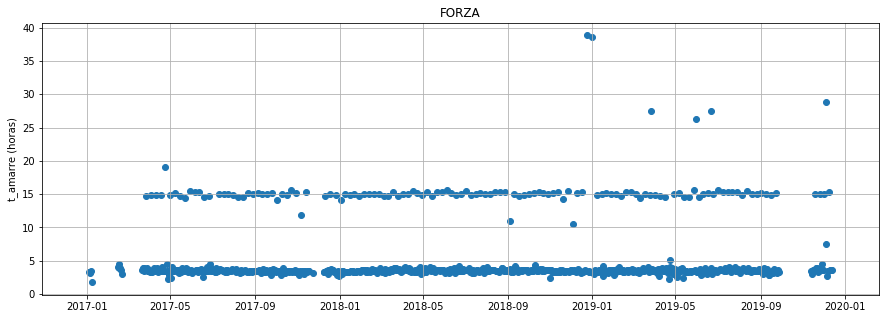

In [101]:
# 'FORZA               ' t_amarre vs inicio_escala
# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'FORZA               ']))+1
x = ferris_ro_trasme['FH. Amarre Calc'][ferris_ro_trasme.Buque == 'FORZA               ']
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'FORZA               ']

figure(figsize=(15,5))
plt.scatter(x,y)
plt.title('FORZA')
plt.ylabel('t_amarre (horas)')
# plt.set_xlabel('n_escalas')
plt.grid()
# plt.set_xlim([0,10])
# plt.set_ylim([0,10])


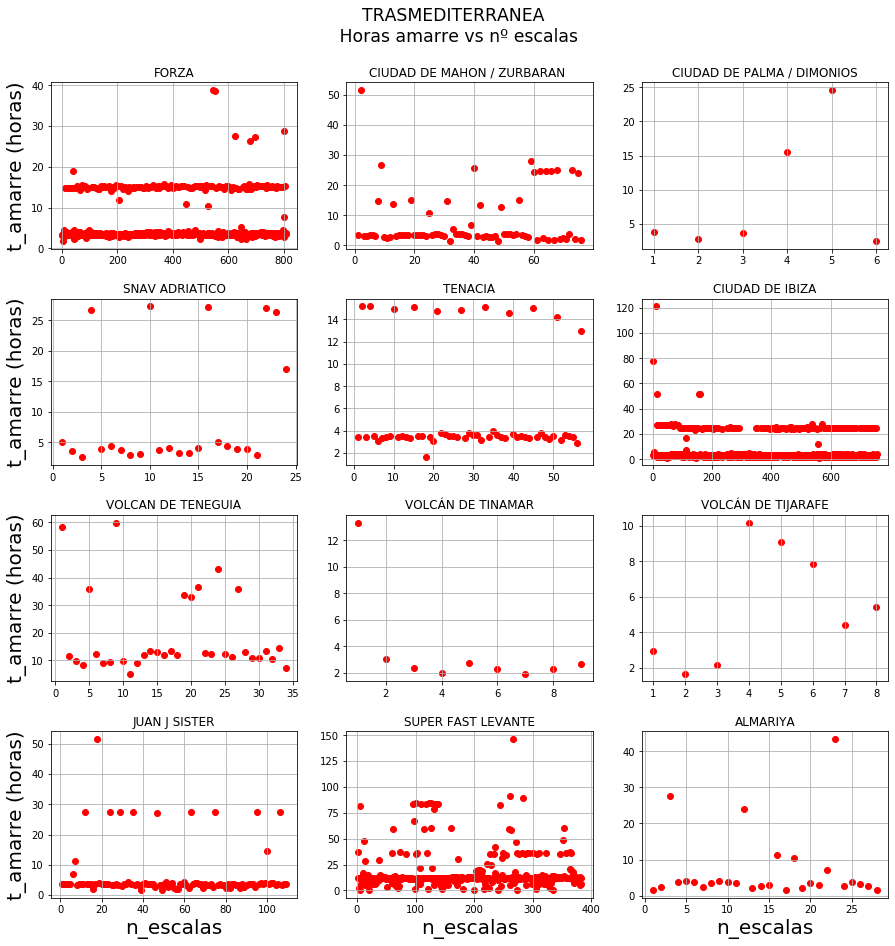

In [213]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize = (15,15))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('TRASMEDITERRANEA \n Horas amarre vs nº escalas', y=0.95, fontsize='xx-large')

# 'FORZA               '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'FORZA               ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'FORZA               ']
ax[0,0].scatter(x,y,facecolor='r')
ax[0,0].set_title('FORZA')
ax[0,0].set_ylabel('t_amarre (horas)', size=20)
# ax[0,0].set_xlabel('n_escalas')
ax[0,0].grid()
# ax[0,0].set_xlim([0,10])
# ax[0,0].set_ylim([0,10])

# 'ZURBARAN y CIUDAD DE MAHON'
x = np.arange(len(ferris_ro_trasme[(ferris_ro_trasme.Buque == 'ZURBARAN            ')|
                                   (ferris_ro_trasme.Buque == 'CIUDAD DE MAHON     ')]))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][(ferris_ro_trasme.Buque == 'ZURBARAN            ')|
                                   (ferris_ro_trasme.Buque == 'CIUDAD DE MAHON     ')]
ax[0,1].scatter(x,y,facecolor='r')
ax[0,1].set_title('CIUDAD DE MAHON / ZURBARAN ')
# ax[0,1].set_ylabel('t_amarre (horas)')
# ax[0,1].set_xlabel('n_escalas')
ax[0,1].grid()
# ax[0,1].set_xlim([0,10])
# ax[0,1].set_ylim([0,10])

# 'DIMONIOS y 'CIUDAD DE PALMA     '
x = np.arange(len(ferris_ro_trasme[(ferris_ro_trasme.Buque == 'DIMONIOS            ')|
                                   (ferris_ro_trasme.Buque == 'CIUDAD DE PALMA     ')]))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][(ferris_ro_trasme.Buque == 'DIMONIOS            ')|
                                   (ferris_ro_trasme.Buque == 'CIUDAD DE PALMA     ')]
ax[0,2].scatter(x,y,facecolor='r')
ax[0,2].set_title('CIUDAD DE PALMA / DIMONIOS')
# ax[0,2].set_ylabel('t_amarre (horas)')
# ax[0,2].set_xlabel('n_escalas')
ax[0,2].grid()
# ax[0,2].set_xlim([0,10])
# ax[0,2].set_ylim([0,10])



# 'SNAV ADRIATICO      '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'SNAV ADRIATICO      ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'SNAV ADRIATICO      ']
ax[1,0].scatter(x,y,facecolor='r')
ax[1,0].set_title('SNAV ADRIATICO')
ax[1,0].set_ylabel('t_amarre (horas)', size=20)
# ax[1,0].set_xlabel('n_escalas')
ax[1,0].grid()
# ax[1,0].set_xlim([0,10])
# ax[1,0].set_ylim([0,10])

# 'TENACIA             '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'TENACIA             ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'TENACIA             ']
ax[1,1].scatter(x,y,facecolor='r')
ax[1,1].set_title('TENACIA')
# ax[1,1].set_ylabel('t_amarre (horas)')
# ax[1,1].set_xlabel('n_escalas')
ax[1,1].grid()
# ax[1,1].set_xlim([0,10])
# ax[1,1].set_ylim([0,10])

# 'CIUDAD DE IBIZA     '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'CIUDAD DE IBIZA     ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'CIUDAD DE IBIZA     ']
ax[1,2].scatter(x,y,facecolor='r')
ax[1,2].set_title('CIUDAD DE IBIZA')
# ax[1,2].set_ylabel('t_amarre (horas)')
# ax[1,2].set_xlabel('n_escalas')
ax[1,2].grid()
# ax[1,2].set_xlim([0,10])
# ax[1,2].set_ylim([0,10])



# 'VOLCAN DE TENEGUIA  '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'VOLCAN DE TENEGUIA  ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'VOLCAN DE TENEGUIA  ']
ax[2,0].scatter(x,y,facecolor='r')
ax[2,0].set_title('VOLCAN DE TENEGUIA')
ax[2,0].set_ylabel('t_amarre (horas)', size=20)
# ax[2,0].set_xlabel('n_escalas')
ax[2,0].grid()
# ax[2,0].set_xlim([0,10])
# ax[2,0].set_ylim([0,10])

# 'VOLCÁN DE TINAMAR   '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'VOLCÁN DE TINAMAR   ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'VOLCÁN DE TINAMAR   ']
ax[2,1].scatter(x,y,facecolor='r')
ax[2,1].set_title('VOLCÁN DE TINAMAR')
# ax[2,1].set_ylabel('t_amarre (horas)')
# ax[2,1].set_xlabel('n_escalas')
ax[2,1].grid()
# ax[2,1].set_xlim([0,10])
# ax[2,1].set_ylim([0,10])

# 'VOLCÁN DE TIJARAFE  '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'VOLCÁN DE TIJARAFE  ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'VOLCÁN DE TIJARAFE  ']
ax[2,2].scatter(x,y,facecolor='r')
ax[2,2].set_title('VOLCÁN DE TIJARAFE')
# ax[2,2].set_ylabel('t_amarre (horas)')
# ax[2,2].set_xlabel('n_escalas')
ax[2,2].grid()
# ax[2,2].set_xlim([0,10])
# ax[2,2].set_ylim([0,10])


 # ------------------------------------------------------------------------------------------------------------- #


# 'JUAN J SISTER       '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'JUAN J SISTER       ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'JUAN J SISTER       ']
ax[3,0].scatter(x,y,facecolor='r')
ax[3,0].set_title('JUAN J SISTER')
ax[3,0].set_ylabel('t_amarre (horas)', size=20)
ax[3,0].set_xlabel('n_escalas', size=20)
ax[3,0].grid()
# ax[3,0].set_xlim([0,10])
# ax[3,0].set_ylim([0,10])

# 'SUPER FAST LEVANTE  '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'SUPER FAST LEVANTE  ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'SUPER FAST LEVANTE  ']
ax[3,1].scatter(x,y,facecolor='r')
ax[3,1].set_title('SUPER FAST LEVANTE')
# ax[3,1].set_ylabel('t_amarre (horas)')
ax[3,1].set_xlabel('n_escalas', size=20)
ax[3,1].grid()
# ax[3,1].set_xlim([0,10])
# ax[3,1].set_ylim([0,10])

# 'ALMARIYA            '
x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'ALMARIYA            ']))+1
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'ALMARIYA            ']
ax[3,2].scatter(x,y,facecolor='r')
ax[3,2].set_title('ALMARIYA')
# ax[3,2].set_ylabel('t_amarre (horas)')
ax[3,2].set_xlabel('n_escalas', size=20)
ax[3,2].grid()
# ax[3,2].set_xlim([0,10])
# ax[3,2].set_ylim([0,10])



# # 'CIUDAD DE IBIZA     '
# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'CIUDAD DE IBIZA     ']))+1
# y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'CIUDAD DE IBIZA     ']
# ax[4,0].scatter(x,y)
# ax[4,0].set_title('CIUDAD DE IBIZA')
# ax[4,0].set_ylabel('t_amarre (horas)')
# # ax[4,0].set_xlabel('n_escalas')
# ax[4,0].grid()
# # ax[4,0].set_xlim([0,10])
# # ax[4,0].set_ylim([0,10])

# # 'ALMUDAINA DOS       '
# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'ALMUDAINA DOS       ']))+1
# y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'ALMUDAINA DOS       ']
# ax[4,1].scatter(x,y)
# ax[4,1].set_title('ALMUDAINA DOS')
# # ax[4,1].set_ylabel('t_amarre (horas)')
# # ax[4,1].set_xlabel('n_escalas')
# ax[4,1].grid()
# # ax[4,1].set_xlim([0,10])
# # ax[4,1].set_ylim([0,10])

# # 'VOLCÁN DE TIJARAFE  '
# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'VOLCÁN DE TIJARAFE  ']))+1
# y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'VOLCÁN DE TIJARAFE  ']
# ax[4,2].scatter(x,y)
# ax[4,2].set_title('VOLCÁN DE TIJARAFE')
# # ax[4,2].set_ylabel('t_amarre (horas)')
# # ax[4,2].set_xlabel('n_escalas')
# ax[4,2].grid()
# # ax[4,2].set_xlim([0,10])
# # ax[4,2].set_ylim([0,10])



# # 'VOLCÁN DE TINAMAR   '
# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'VOLCÁN DE TINAMAR   ']))+1
# y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'VOLCÁN DE TINAMAR   ']
# ax[5,0].scatter(x,y)
# ax[5,0].set_title('VOLCÁN DE TINAMAR')
# ax[5,0].set_ylabel('t_amarre (horas)')
# ax[5,0].set_xlabel('n_escalas')
# ax[5,0].grid()
# # ax[5,0].set_xlim([0,10])
# # ax[5,0].set_ylim([0,10])

# # 'AL ANDALUS EXPRESS  '
# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'AL ANDALUS EXPRESS  ']))+1
# y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'AL ANDALUS EXPRESS  ']
# ax[5,1].scatter(x,y)
# ax[5,1].set_title('AL ANDALUS EXPRESS')
# # ax[5,1].set_ylabel('t_amarre (horas)')
# ax[5,1].set_xlabel('n_escalas')
# ax[5,1].grid()
# # ax[5,1].set_xlim([0,10])
# # ax[5,1].set_ylim([0,10])

# # 'CIUDAD DE CEUTA     '
# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'CIUDAD DE CEUTA     ']))+1
# y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == 'CIUDAD DE CEUTA     ']
# ax[5,2].scatter(x,y)
# ax[5,2].set_title('CIUDAD DE CEUTA')
# # ax[5,2].set_ylabel('t_amarre (horas)')
# ax[5,2].set_xlabel('n_escalas')
# ax[5,2].grid()
# # ax[5,2].set_xlim([0,10])
# # ax[5,2].set_ylim([0,10])



plt.savefig('ro_trasme_4x3.png')

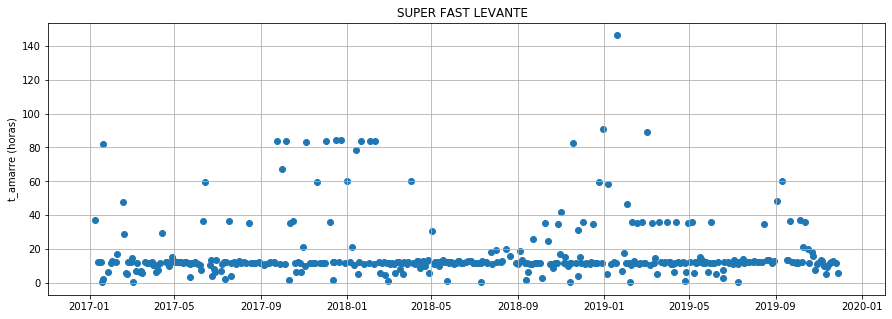

In [154]:
buque = 'SUPER FAST LEVANTE  '

# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'FORZA               ']))+1
x = ferris_ro_trasme['FH. Amarre Calc'][ferris_ro_trasme.Buque == buque]
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == buque]

figure(figsize=(15,5))
plt.scatter(x,y)
plt.title(buque)
plt.ylabel('t_amarre (horas)')
# plt.set_xlabel('n_escalas')
plt.grid()
# plt.set_xlim([0,10])
# plt.ylim([0,20])


(0, 20)

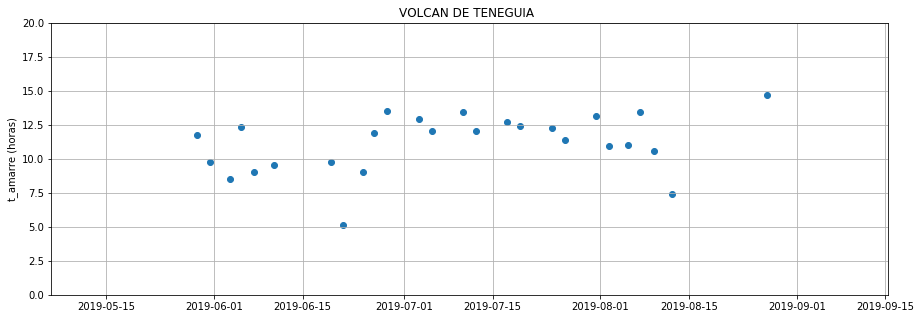

In [153]:
buque = 'VOLCAN DE TENEGUIA  '

# x = np.arange(len(ferris_ro_trasme[ferris_ro_trasme.Buque == 'FORZA               ']))+1
x = ferris_ro_trasme['FH. Amarre Calc'][ferris_ro_trasme.Buque == buque]
y = ferris_ro_trasme['Amarre calculado (horas)'][ferris_ro_trasme.Buque == buque]

figure(figsize=(15,5))
plt.scatter(x,y)
plt.title(buque)
plt.ylabel('t_amarre (horas)')
# plt.set_xlabel('n_escalas')
plt.grid()
# plt.set_xlim([0,10])
plt.ylim([0,20])

In [160]:
ferris_ro_trasme[['Amarre calculado (horas)','Buque']][(ferris_ro_trasme.Buque == 'ZURBARAN            ')|
        
                                (ferris_ro_trasme.Buque == 'FORZA               ')|
                                (ferris_ro_trasme.Buque == 'JUAN J SISTER       ')|
                                (ferris_ro_trasme.Buque == 'CIUDAD DE IBIZA     ')|
                                (ferris_ro_trasme.Buque == 'SUPER FAST LEVANTE  ')].groupby('Buque').describe().round(2)

Amarre calculado (horas)                             \
                                        count   mean    std   min    25%   
Buque                                                                      
CIUDAD DE IBIZA                         756.0   6.92   9.61  1.33   3.33   
FORZA                                   807.0   5.53   4.78  1.75   3.42   
JUAN J SISTER                           109.0   6.01   8.06  1.58   3.42   
SUPER FAST LEVANTE                      383.0  17.36  18.01  0.25  11.33   
ZURBARAN                                 71.0   7.58   9.19  1.42   3.08   

                                            
                        50%    75%     max  
Buque                                       
CIUDAD DE IBIZA        3.50   3.75  121.08  
FORZA                  3.58   3.75   38.83  
JUAN J SISTER          3.58   3.75   51.58  
SUPER FAST LEVANTE    12.00  13.08  146.27  
ZURBARAN               3.42   6.17   51.58

In [159]:
ferris_ro_trasme[['Amarre calculado (horas)','Buque']].groupby('Buque').describe().round(2)

Amarre calculado (horas)                              \
                                        count   mean    std    min    25%   
Buque                                                                       
AL ANDALUS EXPRESS                        7.0  18.95  18.40   9.33  12.08   
ALMARIYA                                 28.0   6.72   9.53   1.50   2.62   
ALMUDAINA DOS                             1.0  28.42    NaN  28.42  28.42   
CIUDAD DE CADIZ                           2.0  75.71  30.35  54.25  64.98   
CIUDAD DE CEUTA                           1.0   0.58    NaN   0.58   0.58   
CIUDAD DE IBIZA                         756.0   6.92   9.61   1.33   3.33   
CIUDAD DE MAHON                           5.0  11.32  12.07   1.67   2.08   
CIUDAD DE PALMA                           2.0  13.54  15.62   2.50   8.02   
DIMONIOS                                  4.0   6.48   6.03   2.83   3.52   
FORZA                                   807.0   5.53   4.78   1.75   3.42   
JUAN J SISTER                           109.0   6.01   8.06   1.58   3.42   
SNAV ADRIATICO                           24.0   9.11   9.70   2.50   3.50   
SUPER FAST LEVANTE                      383.0  17.36  18.01   0.25  11.33   
TENACIA                                  57.0   5.59   4.52   1.58   3.42   
VOLCAN DE TENEGUIA                       34.0  18.44  14.33   5.17  10.67   
VOLCÁN DE TIJARAFE                        8.0   5.46   3.24   1.67   2.73   
VOLCÁN DE TINAMAR                         9.0   3.61   3.66   1.92   2.25   
ZURBARAN                                 71.0   7.58   9.19   1.42   3.08   

                                            
                        50%    75%     max  
Buque                                       
AL ANDALUS EXPRESS    12.58  13.00   60.58  
ALMARIYA               3.46   4.17   43.42  
ALMUDAINA DOS         28.42  28.42   28.42  
CIUDAD DE CADIZ       75.71  86.44   97.17  
CIUDAD DE CEUTA        0.58   0.58    0.58  
CIUDAD DE IBIZA        3.50   3.75  121.08  
CIUDAD DE MAHON        3.83  23.92   25.08  
CIUDAD DE PALMA       13.54  19.06   24.58  
DIMONIOS               3.79   6.75   15.50  
FORZA                  3.58   3.75   38.83  
JUAN J SISTER          3.58   3.75   51.58  
SNAV ADRIATICO         3.96   7.98   27.25  
SUPER FAST LEVANTE    12.00  13.08  146.27  
TENACIA                3.50   3.75   15.17  
VOLCAN DE TENEGUIA    12.29  14.38   59.83  
VOLCÁN DE TIJARAFE     4.92   8.15   10.17  
VOLCÁN DE TINAMAR      2.33   2.75   13.33  
ZURBARAN               3.42   6.17   51.58

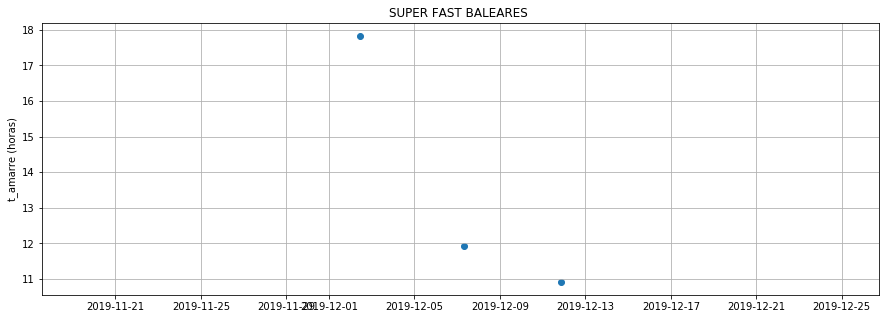

In [165]:
buque = 'SUPER FAST BALEARES '

# x = np.arange(len(ferris_ro[ferris_ro.Buque == 'FORZA               ']))+1
x = ferris_ro['FH. Amarre Calc'][ferris_ro.Buque == buque]
y = ferris_ro['Amarre calculado (horas)'][ferris_ro.Buque == buque]

figure(figsize=(15,5))
plt.scatter(x,y)
plt.title(buque)
plt.ylabel('t_amarre (horas)')
# plt.set_xlabel('n_escalas')
plt.grid()
# plt.set_xlim([0,10])
# plt.ylim([0,20])

### Baleària

In [111]:
# definición variables Balearia

t_active_ropax = 4                 # horas
pot_ropax = 800                    # kW
pot_ropax_inac = 600               # kW

# t_active_roro = 7                  # horas
# pot_roro = 500                     # kW 
# pot_roro_inac = pot_ropax_inac     # kW

#### Descripción general

In [112]:
balearia.columns

Index([               'Año Servicio',                   'Id.Escala',
            'Clave Lloyd o Num. OMI',                       'Buque',
                        'Tipo Buque',             'Det. G.T. Buque',
                      'Num. Atraque',                  'Power (kW)',
                          'Potencia',         'Muelle Atraque Real',
                     'Tipo Maniobra',   'Fecha de Fin del Servicio',
          'Hora de Fin del Servicio', 'Fecha de Inicio de Servicio',
       'Hora de Inicio del Servicio',             'FH. Amarre Calc',
                'FH. Desamarre Calc',    'Amarre calculado (horas)',
                       'Unnamed: 18',                 'Unnamed: 19',
                       'Manoeuvring',                         'MT=',
                                 0.8,                 'Unnamed: 23',
                       'Unnamed: 24',                 'Unnamed: 25',
                       'Unnamed: 26',                 'Unnamed: 27',
                       'Unnamed: 2

In [253]:
año = 2019

In [254]:
balearia[balearia['Año Servicio'] == año].describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas)
count,802.0,8.020000e+02,802.000000,802.000000,0.0,802.000000,802.000000,802.000000,802.000000
mean,2019.0,9.115012e+06,25888.360349,1.083541,NaN,27497.218204,1744.226933,1722.674564,7.143080
std,0.0,6.553107e+05,4560.176537,0.414173,NaN,2182.321429,375.755204,375.478701,8.767443
min,2019.0,7.827225e+06,18345.000000,1.000000,NaN,21000.000000,35.000000,20.000000,0.416667
25%,2019.0,9.137997e+06,24409.000000,1.000000,NaN,25645.000000,1845.000000,1835.000000,2.437500
50%,2019.0,9.498743e+06,26375.000000,1.000000,NaN,27638.000000,1910.000000,1855.000000,3.291667
75%,2019.0,9.498755e+06,28658.000000,1.000000,NaN,29376.000000,1935.000000,1925.000000,7.583333
max,2019.0,9.498767e+06,33958.000000,8.000000,NaN,30897.000000,2355.000000,2335.000000,72.000000


In [243]:
balearia['Amarre calculado (horas)'].sum()

17090.08333334903

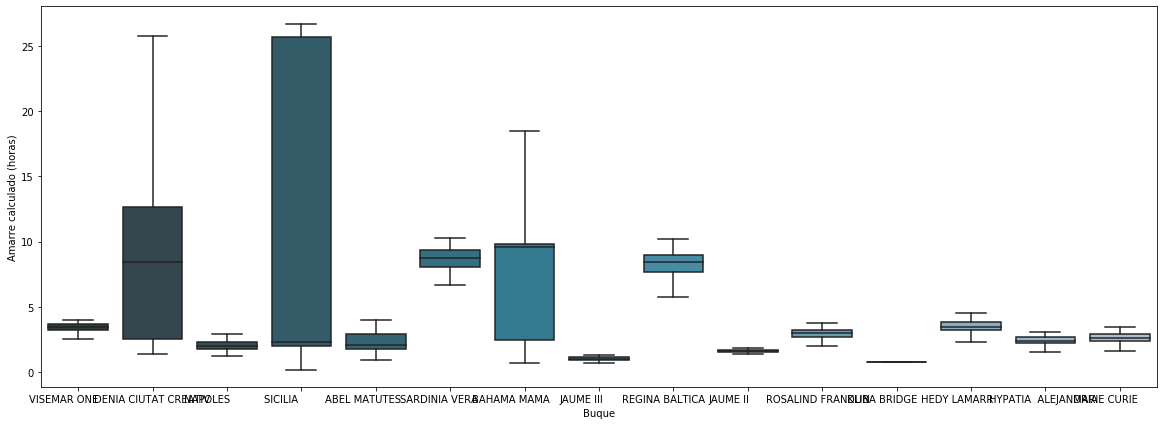

In [293]:
figure(figsize=(20,7))


sns.boxplot(x='Buque', y='Amarre calculado (horas)', data=balearia, showfliers = False, palette="PuBuGn_d")
# sns.palplot(sns.light_palette((210, 90, 60), input="husl"))

# plt.grid(True)

In [127]:
año = 2019

In [128]:
# consumo promedio en escala

balearia.Potencia_kW[balearia['Año Servicio'] == año].mean()

758.4890840797913

In [129]:
# consumo total por año

(balearia['Amarre calculado (horas)'][balearia['Año Servicio']==año]*balearia.Potencia_kW[balearia['Año Servicio']==año]).sum()/1000

3941.000000002538

#### Consums Baleària

In [113]:
balearia.columns

Index([               'Año Servicio',                   'Id.Escala',
            'Clave Lloyd o Num. OMI',                       'Buque',
                        'Tipo Buque',             'Det. G.T. Buque',
                      'Num. Atraque',                  'Power (kW)',
                          'Potencia',         'Muelle Atraque Real',
                     'Tipo Maniobra',   'Fecha de Fin del Servicio',
          'Hora de Fin del Servicio', 'Fecha de Inicio de Servicio',
       'Hora de Inicio del Servicio',             'FH. Amarre Calc',
                'FH. Desamarre Calc',    'Amarre calculado (horas)',
                       'Unnamed: 18',                 'Unnamed: 19',
                       'Manoeuvring',                         'MT=',
                                 0.8,                 'Unnamed: 23',
                       'Unnamed: 24',                 'Unnamed: 25',
                       'Unnamed: 26',                 'Unnamed: 27',
                       'Unnamed: 2

In [56]:
balearia.Buque.unique()

array(['VISEMAR ONE         ', 'DENIA CIUTAT CREATIV',
       'NAPOLES             ', 'SICILIA             ',
       'ABEL MATUTES        ', 'SARDINIA VERA       ',
       'BAHAMA MAMA         ', 'JAUME III           ',
       'REGINA BALTICA      ', 'JAUME II            ',
       'ROSALIND FRANKLIN   ', 'DUBA BRIDGE         ',
       'HEDY LAMARR         ', 'HYPATIA  ALEJANDRIA ',
       'MARIE CURIE         '], dtype=object)

In [114]:
balearia['Muelle Atraque Real'].unique()

array(['TURIA                    ', 'ESP.TUR.SUR-1            ',
       'ESP.TUR.SUR-2            ', 'SUR                      ',
       'ESP.TUR.NORTE-2          ', nan], dtype=object)

In [115]:
# Clasificación ferris Trasme según tipología de buque

for each in balearia.Buque.unique():
    print(str(each) + str(balearia['Tipo Buque'][balearia.Buque==each].max()))

VISEMAR ONE         FERRYS RO/RO PASAJEROS   
DENIA CIUTAT CREATIVFERRYS RO/RO PASAJEROS   
NAPOLES             FERRYS RO/RO PASAJEROS   
SICILIA             FERRYS RO/RO PASAJEROS   
ABEL MATUTES        FERRYS RO/RO PASAJEROS   
SARDINIA VERA       FERRYS RO/RO PASAJEROS   
BAHAMA MAMA         FERRYS RO/RO PASAJEROS   
JAUME III           OTROS DE PASAJE          
REGINA BALTICA      FERRYS RO/RO PASAJEROS   
JAUME II            FERRYS RO/RO PASAJEROS   
ROSALIND FRANKLIN   FERRYS RO/RO PASAJEROS   
DUBA BRIDGE         FERRYS RO/RO PASAJEROS   
HEDY LAMARR         FERRYS RO/RO PASAJEROS   
HYPATIA  ALEJANDRIA FERRYS RO/RO PASAJEROS   
MARIE CURIE         FERRYS RO/RO PASAJEROS   
nannan


In [116]:
# potencias ropax
balearia['Potencia_kW']=""

balearia.Potencia_kW[balearia['Amarre calculado (horas)']<=t_active_ropax] = pot_ropax

balearia.Potencia_kW[balearia['Amarre calculado (horas)']>t_active_ropax] = pot_ropax*(t_active_ropax/balearia['Amarre calculado (horas)'][
                   balearia['Amarre calculado (horas)']>t_active_ropax]
                                              )+pot_ropax_inac*((balearia['Amarre calculado (horas)'][
                   balearia['Amarre calculado (horas)']>t_active_ropax]-t_active_ropax)/balearia['Amarre calculado (horas)'][
                   balearia['Amarre calculado (horas)']>t_active_ropax])

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [117]:
balearia.Potencia_kW = balearia.Potencia_kW.astype('float')

In [118]:
balearia.Potencia_kW

0       800.000000
1       686.486486
2       754.838710
3       800.000000
4       691.428571
           ...    
2486    800.000000
2487    800.000000
2488    800.000000
2489    800.000000
2490    611.111111
Name: Potencia_kW, Length: 2491, dtype: float64

#### Simultaneidad Balearia

In [10]:
dfIN = balearia[['FH. Amarre Calc','Potencia_kW']]
dfOUT = balearia[['FH. Desamarre Calc','Potencia_kW']]
dfIN['direction'] = 1
dfOUT['direction'] = -1

In [11]:
dfIN.columns = ('TS','pot_media','direction')
dfOUT.columns = ('TS','pot_media','direction')

In [12]:
traffic_balearia = pd.concat([dfIN, dfOUT]).sort_values('TS')

In [13]:
traffic_balearia.pot_media = traffic_balearia.pot_media*traffic_balearia.direction

In [14]:
traffic_balearia['ships'] = traffic_balearia['direction'].cumsum()
traffic_balearia['cum_pot'] = traffic_balearia['pot_media'].cumsum()

In [15]:
traffic_balearia = traffic_balearia.round()

C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



(737060.0, 737406.0)

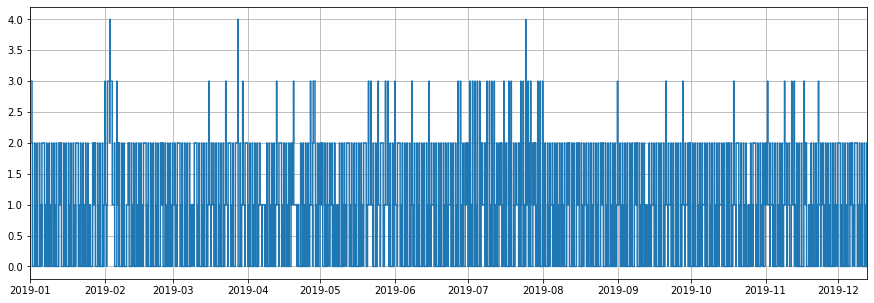

In [16]:
figure(figsize=(15,5))

plt.step(traffic_balearia.TS,traffic_balearia.ships, where='post')
plt.grid(True)
# plt.xlim(['2017-01-20','2017-01-21'])
plt.xlim(['2019-01-01','2019-12-13'])


(737060.0, 737406.0)

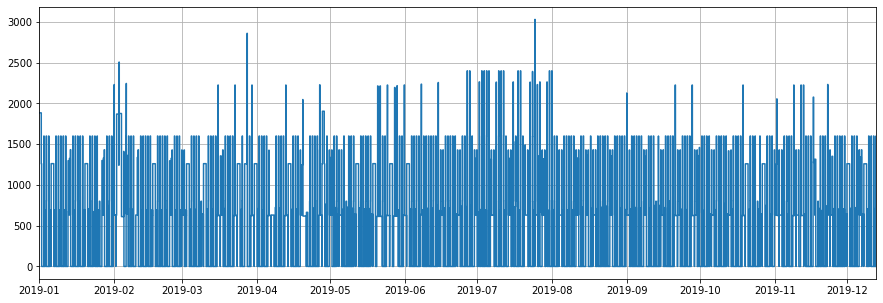

In [17]:
a = figure(figsize=(15,5))

plt.step(traffic_balearia.TS,traffic_balearia.cum_pot, where='post')
plt.grid(True)
plt.xlim(['2019-01-01','2019-12-13'])
# plt.xlim(['2017-01-20 18','2017-01-20 22'])
# plt.ylim([10000,30000])

In [18]:
traffic_balearia.describe()#.describe(include='all')

,pot_media,direction,ships,cum_pot
count,4980.000000,4980.0000,4980.000000,4980.000000
mean,0.000000,0.0000,1.018072,760.003213
std,760.682343,1.0001,0.770564,578.694095
min,-800.000000,-1.0000,0.000000,-0.000000
25%,-800.000000,-1.0000,0.000000,0.000000
50%,0.000000,0.0000,1.000000,800.000000
75%,800.000000,1.0000,2.000000,1260.000000
max,800.000000,1.0000,4.000000,3031.000000


In [19]:
traffic_balearia.TS = traffic_balearia.TS + pd.to_timedelta(traffic_balearia.groupby('TS').cumcount(), unit='ms')

In [20]:
traffic_balearia.TS.is_unique

True

In [21]:
print(len(traffic_balearia[traffic_balearia.TS.duplicated()==True]))

0


In [22]:
traffic_balearia = traffic_balearia.set_index('TS')#.resample('h')

In [23]:
### ---------------------------------------------------------- ###
### función que da el valor acumulado de potencias por horas
### ---------------------------------------------------------- ###

traffic_balearia.resample('1H').ffill().fillna(0).head(18)#.groupby('TS').sum()

,pot_media,direction,ships,cum_pot
TS,,,,
2017-01-02 18:00:00,0.0,0.0,0.0,0.0
2017-01-02 19:00:00,800.0,1.0,1.0,800.0
2017-01-02 20:00:00,800.0,1.0,2.0,1600.0
2017-01-02 21:00:00,800.0,1.0,2.0,1600.0
2017-01-02 22:00:00,-800.0,-1.0,1.0,800.0
2017-01-02 23:00:00,-800.0,-1.0,0.0,0.0
2017-01-03 00:00:00,-800.0,-1.0,0.0,0.0
2017-01-03 01:00:00,-800.0,-1.0,0.0,0.0
2017-01-03 02:00:00,-800.0,-1.0,0.0,0.0


In [24]:
traffic_balearia.head(6)

,pot_media,direction,ships,cum_pot
TS,,,,
2017-01-02 18:55:00,800.0,1,1,800.0
2017-01-02 19:20:00,800.0,1,2,1600.0
2017-01-02 21:45:00,-800.0,-1,1,800.0
2017-01-02 22:10:00,-800.0,-1,0,0.0
2017-01-03 09:20:00,686.0,1,1,686.0
2017-01-03 18:35:00,-686.0,-1,0,0.0


(737060.0, 737406.0)

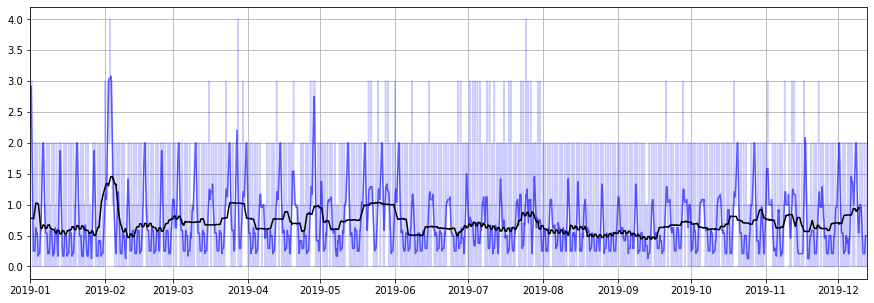

In [43]:
a = figure(figsize=(15,5))

x = traffic_balearia.resample('1H').ffill().index
y = traffic_balearia.resample('1H').ffill().fillna(0).ships

plt.plot(x,y,'b', color=[0,0,1,0.2])
plt.plot(x, y.rolling(window=24, center=True).mean(),color=[0,0,1,0.6])
plt.plot(x, y.rolling(window=24*7, center=True).mean(), 'k')

plt.grid(True)
plt.xlim(['2019-12-10','2019-12-13'])
plt.xlim(['2019-01-01','2019-12-13'])

In [49]:
sim = pd.concat([traffic_balearia.resample('1H').ffill().fillna(0).ships,
                 traffic_balearia.resample('1H').ffill().fillna(0).cum_pot], axis=1)
sim.to_excel("sim_balearia.xlsx")

In [31]:
y.rolling(window=24).mean()

TS
2017-01-02 18:00:00    NaN
2017-01-02 19:00:00    NaN
2017-01-02 20:00:00    NaN
2017-01-02 21:00:00    NaN
2017-01-02 22:00:00    NaN
                      ... 
2019-12-12 18:00:00    0.5
2019-12-12 19:00:00    0.5
2019-12-12 20:00:00    0.5
2019-12-12 21:00:00    0.5
2019-12-12 22:00:00    0.5
Freq: H, Name: ships, Length: 25781, dtype: float64

(array([5.29808774e-01, 2.87808851e-01, 1.63453706e-01, 1.86571506e-02,
        2.71517784e-04]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

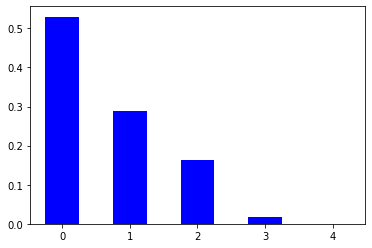

In [99]:
x = traffic_balearia.resample('1H').ffill().fillna(0).ships

plt.hist(x=x,bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5],density=True, rwidth=0.5, color='b')
# plt.grid(True)

In [100]:
5.29808774e-01+ 2.87808851e-01+ 1.63453706e-01+ 1.86571506e-02+ 2.71517784e-04

0.999999999384

In [372]:
print('nº ferris Balearia')
print('-------------')
# print('\n')
print(str(round(len(x[x==0])*100/len(x),2)) + ' % del tiempo sin cruceros atracados')
print(str(round(len(x[x==1])*100/len(x),2)) + ' % de horas con 1 crucero')
print(str(round(len(x[x==2])*100/len(x),2)) + ' % de horas con 2 simultaneos')
print(str(round(len(x[x==3])*100/len(x),2)) + ' % de horas con 3 simultaneos')
print(str(round(len(x[x==4])*100/len(x),2)) + ' % de horas con 4 simultaneos')

print('-------------')
print('Considerando solo el tiempo que hay al menos un crucero:')
print(str(round(len(x[x==1])*100/len(x[x!=0]),2)) + ' % de horas con 1 crucero')
print(str(round(len(x[x==2])*100/len(x[x!=0]),2)) + ' % de horas con 2 simultaneos')
print(str(round(len(x[x==3])*100/len(x[x!=0]),2)) + ' % de horas con 3 simultaneos')
print(str(round(len(x[x==4])*100/len(x[x!=0]),2)) + ' % de horas con 4 simultaneos')

nº ferris Balearia
-------------
52.98 % del tiempo sin cruceros atracados
28.78 % de horas con 1 crucero
16.35 % de horas con 2 simultaneos
1.87 % de horas con 3 simultaneos
0.03 % de horas con 4 simultaneos
-------------
Considerando solo el tiempo que hay al menos un crucero:
61.21 % de horas con 1 crucero
34.76 % de horas con 2 simultaneos
3.97 % de horas con 3 simultaneos
0.06 % de horas con 4 simultaneos


(737060.0, 737406.0)

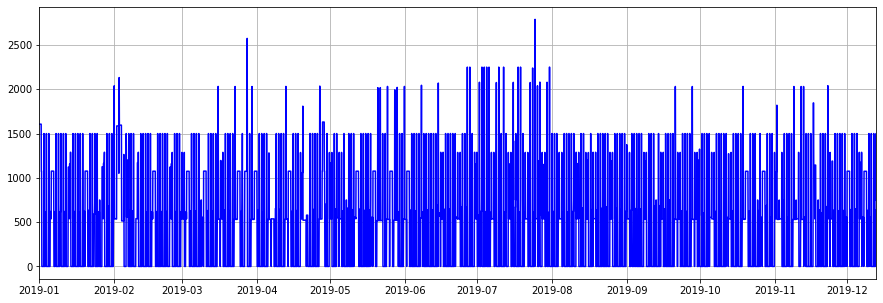

In [101]:
a = figure(figsize=(15,5))

x = traffic_balearia.resample('1H').ffill().index
y = traffic_balearia.resample('1H').ffill().fillna(0).cum_pot

plt.plot(x,y,'b')
plt.grid(True)
plt.xlim(['2019-12-10','2019-12-13'])
plt.xlim(['2019-01-01','2019-12-13'])

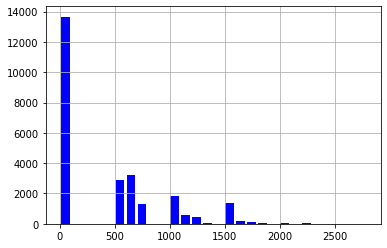

In [104]:
x = traffic_balearia.resample('1H').ffill().fillna(0).cum_pot

plt.hist(x=x,bins=28, rwidth= 0.8, color='b')
plt.grid(True)

In [119]:
np.array([-0.5,0.5,1.5,2.5,3.5,4.5])*pot_ropax

array([-375.,  375., 1125., 1875., 2625., 3375.])

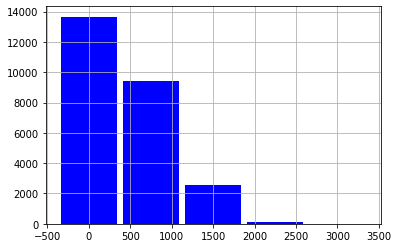

In [121]:
x = traffic_balearia.resample('1H').ffill().fillna(0).cum_pot

plt.hist(x=x,bins=np.array([-0.5,0.5,1.5,2.5,3.5,4.5])*pot_ropax, rwidth= 0.9, color='b')
plt.grid(True)

In [103]:
print('Power Balearia')
print('-------------------')
# print('\n')
print(str(round(len(x[x==0])*100/len(x),2)) + ' % del tiempo sin cruceros atracados')
print(str(round(len(x[(x>0) & (x<=500)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1 y 500 kW')
print(str(round(len(x[(x>500) & (x<=1000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 501 y 1000 kW')
print(str(round(len(x[(x>1000) & (x<=1500)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1001 y 1500 kW')
print(str(round(len(x[(x>1500) & (x<=2000)])*100/len(x),2)) + ' % de horas con pot acumulada entre 1501 y 2000 kW')
print(str(round(len(x[x>2000])*100/len(x),2)) + ' % de horas con pot acumulada mayor de 2000 kW')

print('-------------------')
print('Considerando solo el tiempo que hay al menos un crucero:')
print(str(round(len(x[(x>0) & (x<=500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1 y 500 kW')
print(str(round(len(x[(x>500) & (x<=1000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 500 y 1000 kW')
print(str(round(len(x[(x>1000) & (x<=1500)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1000 y 1500 kW')
print(str(round(len(x[(x>1500) & (x<=2000)])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada entre 1500 y 2000 kW')
print(str(round(len(x[x>2000])*100/len(x[x!=0]),2)) + ' % de horas con pot acumulada mayor de 2000 kW')

Power Balearia
-------------------
52.98 % del tiempo sin cruceros atracados
0.0 % de horas con pot acumulada entre 1 y 500 kW
28.78 % de horas con pot acumulada entre 500 y 1000 kW
16.35 % de horas con pot acumulada entre 1000 y 1500 kW
1.52 % de horas con pot acumulada entre 1500 y 2000 kW
0.37 % de horas con pot acumulada mayor de 2000 kW
-------------------
Considerando solo el tiempo que hay al menos un crucero:
0.0 % de horas con pot acumulada entre 1 y 500 kW
61.21 % de horas con pot acumulada entre 500 y 1000 kW
34.76 % de horas con pot acumulada entre 1000 y 1500 kW
3.23 % de horas con pot acumulada entre 1500 y 2000 kW
0.79 % de horas con pot acumulada mayor de 2000 kW


In [375]:
x[x<100]

TS
2017-01-02 18:00:00    0.0
2017-01-02 23:00:00    0.0
2017-01-03 00:00:00    0.0
2017-01-03 01:00:00    0.0
2017-01-03 02:00:00    0.0
                      ... 
2019-12-12 08:00:00    0.0
2019-12-12 09:00:00    0.0
2019-12-12 10:00:00    0.0
2019-12-12 18:00:00    0.0
2019-12-12 19:00:00    0.0
Name: cum_pot, Length: 13659, dtype: float64

In [245]:
# idx_TS.resample('H').sum().tail(23)#.interpolate('time')
# agg(np.sum)
# df['A'].replace(to_replace=0, method='ffill')

In [122]:
traffic_balearia.tail(11)

,pot_media,direction,ships,cum_pot
TS,,,,
2019-12-10 22:10:00,-750.0,-1,0,0.0
2019-12-11 19:15:00,750.0,1,1,750.0
2019-12-11 19:40:00,750.0,1,2,1500.0
2019-12-11 21:35:00,-750.0,-1,1,750.0
2019-12-11 22:25:00,-750.0,-1,0,0.0
2019-12-12 10:15:00,638.0,1,1,638.0
2019-12-12 17:30:00,-638.0,-1,0,0.0
2019-12-12 19:10:00,750.0,1,1,750.0
2019-12-12 19:45:00,750.0,1,2,1500.0


In [335]:
traffic_balearia.head(8)

,pot_media,direction,ships,cum_pot
TS,,,,
2017-01-02 18:55:00,750.0,1,1,750.0
2017-01-02 19:20:00,750.0,1,2,1500.0
2017-01-02 21:45:00,-750.0,-1,1,750.0
2017-01-02 22:10:00,-750.0,-1,0,0.0
2017-01-03 09:20:00,451.0,1,1,451.0
2017-01-03 18:35:00,-451.0,-1,0,0.0
2017-01-03 18:50:00,750.0,1,1,750.0
2017-01-03 19:45:00,750.0,1,2,1500.0


#### Outdated

In [117]:
# ferris_ro_balea = ferris_ro[(ferris_ro.Buque == 'VISEMAR ONE         ')|(ferris_ro.Buque == 'HEDY LAMARR         ')|
#                             (ferris_ro.Buque == 'NAPOLES             ')|
#                             (ferris_ro.Buque == 'DUBA BRIDGE         ')|
                            
#                             (ferris_ro.Buque == 'DENIA CIUTAT CREATIV')|
#                             (ferris_ro.Buque == 'SICILIA             ')|
#                             (ferris_ro.Buque == 'ABEL MATUTES        ')|
#                             (ferris_ro.Buque == 'BAHAMA MAMA         ')|
#                             (ferris_ro.Buque == 'REGINA BALTICA      ')|
#                             (ferris_ro.Buque == 'JAUME II            ')|
#                             (ferris_ro.Buque == 'JAUME III           ')|
#                             (ferris_ro.Buque == 'ROSALIND FRANKLIN   ')|
#                             (ferris_ro.Buque == 'HYPATIA  ALEJANDRIA ')|
#                             (ferris_ro.Buque == 'MARIE CURIE         ')
#                            ]

In [163]:
# Dónde atracan los buques de Baleària

print('Dónde atracan los buques de Baleària:')
for each in ferris_ro_balea['Muelle Atraque Real'].unique():
    print(str(each) + str(len(ferris_ro_balea[ferris_ro_balea['Muelle Atraque Real']==each])))
print('\n')    
# Cuántas escalas por buque

print('Cuántas escalas por buque:')
for each in ferris_ro_balea.Buque.unique():
    print(str(each) + str(len(ferris_ro_balea[ferris_ro_balea.Buque==each])))

Dónde atracan los buques de Baleària:
TURIA                    1010
ESP.TUR.SUR-1            1264
ESP.TUR.SUR-2            6
SUR                      141
DIQUE DEL ESTE           34
TRANSVERSALES            1
CRUCEROS TRES            25
NORTE(XITA)              2
ESP.TUR.NORTE-2          1


Cuántas escalas por buque:
VISEMAR ONE         535
DENIA CIUTAT CREATIV62
NAPOLES             370
SICILIA             101
ABEL MATUTES        277
BAHAMA MAMA         47
JAUME III           36
REGINA BALTICA      414
JAUME II            16
ROSALIND FRANKLIN   60
DUBA BRIDGE         5
HEDY LAMARR         296
HYPATIA  ALEJANDRIA 192
MARIE CURIE         73


In [173]:
# ferris_ro_balea.Buque[(ferris_ro_balea['Muelle Atraque Real']=='TURIA                    ')|
#                       (ferris_ro_balea['Muelle Atraque Real']=='ESP.TUR.SUR-1            ')|
#                       (ferris_ro_balea['Muelle Atraque Real']=='SUR                      ')|
#                       (ferris_ro_balea['Muelle Atraque Real']=='DIQUE DEL ESTE           ')|
#                       (ferris_ro_balea['Muelle Atraque Real']=='CRUCEROS TRES            ')
#                      ].unique()

array(['VISEMAR ONE         ', 'DENIA CIUTAT CREATIV',
       'NAPOLES             ', 'SICILIA             ',
       'ABEL MATUTES        ', 'BAHAMA MAMA         ',
       'JAUME III           ', 'REGINA BALTICA      ',
       'JAUME II            ', 'ROSALIND FRANKLIN   ',
       'DUBA BRIDGE         ', 'HEDY LAMARR         ',
       'HYPATIA  ALEJANDRIA ', 'MARIE CURIE         '], dtype=object)

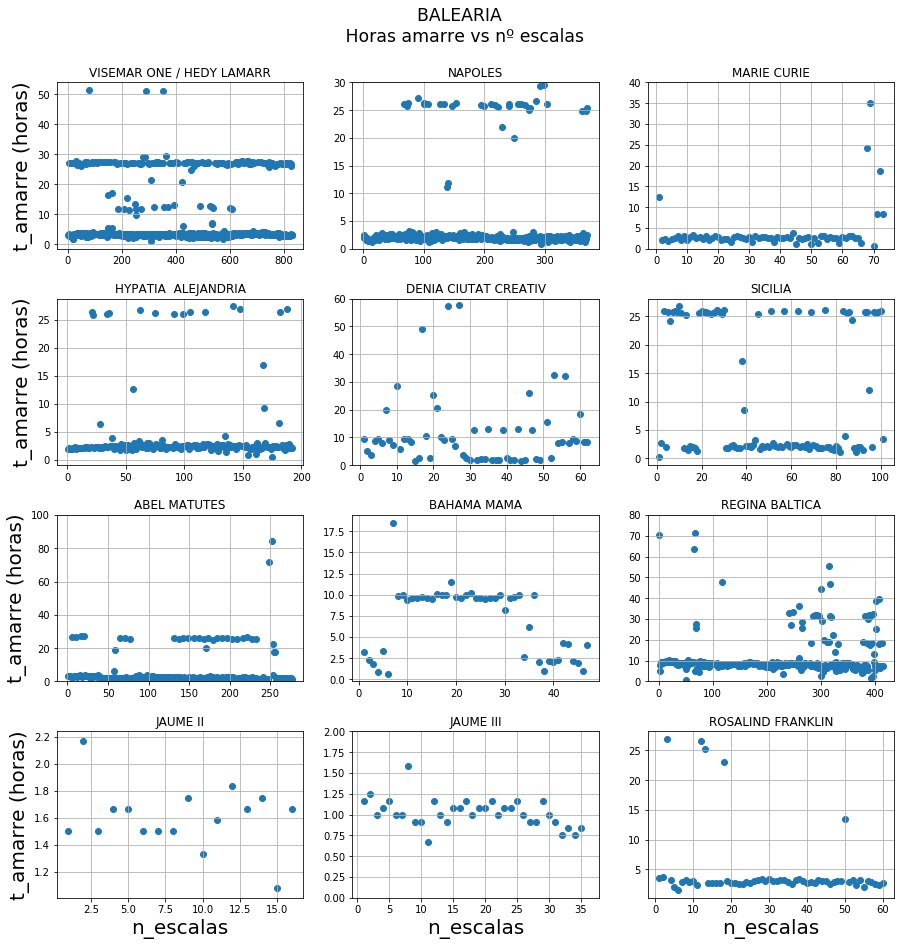

In [214]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize = (15,15))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('BALEARIA \n Horas amarre vs nº escalas', y=0.95, fontsize='xx-large')

# 'VISEMAR ONE o HEDY LAMARR'
x = np.arange(len(ferris_ro_balea[(ferris_ro_balea.Buque == 'VISEMAR ONE         ')|
                                 (ferris_ro_balea.Buque == 'HEDY LAMARR         ')]))+1
y = ferris_ro_balea['Amarre calculado (horas)'][(ferris_ro_balea.Buque == 'VISEMAR ONE         ')|
                                 (ferris_ro_balea.Buque == 'HEDY LAMARR         ')
                                               ]
ax[0,0].scatter(x,y)
ax[0,0].set_title('VISEMAR ONE / HEDY LAMARR')
ax[0,0].set_ylabel('t_amarre (horas)', size=20)
# ax[0,0].set_xlabel('n_escalas')
ax[0,0].grid()
# ax[0,0].set_xlim([0,10])
# ax[0,0].set_ylim([0,10])

# 'NAPOLES             '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'NAPOLES             ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'NAPOLES             ']
ax[0,1].scatter(x,y)
ax[0,1].set_title('NAPOLES')
# ax[0,1].set_ylabel('t_amarre (horas)')
# ax[0,1].set_xlabel('n_escalas')
ax[0,1].grid()
# ax[0,1].set_xlim([0,10])
ax[0,1].set_ylim([0,30])

# 'MARIE CURIE         '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'MARIE CURIE         ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'MARIE CURIE         ']
ax[0,2].scatter(x,y)
ax[0,2].set_title('MARIE CURIE')
# ax[0,2].set_ylabel('t_amarre (horas)')
# ax[0,2].set_xlabel('n_escalas')
ax[0,2].grid()
# ax[0,2].set_xlim([0,10])
ax[0,2].set_ylim([0,40])



# 'HYPATIA  ALEJANDRIA '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'HYPATIA  ALEJANDRIA ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'HYPATIA  ALEJANDRIA ']
ax[1,0].scatter(x,y)
ax[1,0].set_title('HYPATIA  ALEJANDRIA')
ax[1,0].set_ylabel('t_amarre (horas)', size=20)
# ax[1,0].set_xlabel('n_escalas')
ax[1,0].grid()
# ax[1,0].set_xlim([0,10])
# ax[1,0].set_ylim([0,10])

# 'DENIA CIUTAT CREATIV'
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'DENIA CIUTAT CREATIV']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'DENIA CIUTAT CREATIV']
ax[1,1].scatter(x,y)
ax[1,1].set_title('DENIA CIUTAT CREATIV')
# ax[1,1].set_ylabel('t_amarre (horas)')
# ax[1,1].set_xlabel('n_escalas')
ax[1,1].grid()
# ax[1,1].set_xlim([0,10])
ax[1,1].set_ylim([0,60])

# 'SICILIA             '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'SICILIA             ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'SICILIA             ']
ax[1,2].scatter(x,y)
ax[1,2].set_title('SICILIA')
# ax[1,2].set_ylabel('t_amarre (horas)')
# ax[1,2].set_xlabel('n_escalas')
ax[1,2].grid()
# ax[1,2].set_xlim([0,10])
# ax[1,2].set_ylim([0,10])



# 'ABEL MATUTES        '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'ABEL MATUTES        ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'ABEL MATUTES        ']
ax[2,0].scatter(x,y)
ax[2,0].set_title('ABEL MATUTES')
ax[2,0].set_ylabel('t_amarre (horas)', size=20)
# ax[2,0].set_xlabel('n_escalas')
ax[2,0].grid()
# ax[2,0].set_xlim([0,10])
ax[2,0].set_ylim([0,100])

# 'BAHAMA MAMA         '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'BAHAMA MAMA         ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'BAHAMA MAMA         ']
ax[2,1].scatter(x,y)
ax[2,1].set_title('BAHAMA MAMA')
# ax[2,1].set_ylabel('t_amarre (horas)')
# ax[2,1].set_xlabel('n_escalas')
ax[2,1].grid()
# ax[2,1].set_xlim([0,10])
# ax[2,1].set_ylim([0,10])

# 'REGINA BALTICA      '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'REGINA BALTICA      ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'REGINA BALTICA      ']
ax[2,2].scatter(x,y)
ax[2,2].set_title('REGINA BALTICA')
# ax[2,2].set_ylabel('t_amarre (horas)')
# ax[2,2].set_xlabel('n_escalas')
ax[2,2].grid()
# ax[2,2].set_xlim([0,10])
ax[2,2].set_ylim([0,80])


 # ------------------------------------------------------------------------------------------------------------- #


# 'JAUME II            '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'JAUME II            ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'JAUME II            ']
ax[3,0].scatter(x,y)
ax[3,0].set_title('JAUME II')
ax[3,0].set_ylabel('t_amarre (horas)', size=20)
ax[3,0].set_xlabel('n_escalas', size=20)
ax[3,0].grid()
# ax[3,0].set_xlim([0,10])
# ax[3,0].set_ylim([0,10])

# 'JAUME III           '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'JAUME III           ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'JAUME III           ']
ax[3,1].scatter(x,y)
ax[3,1].set_title('JAUME III')
# ax[3,1].set_ylabel('t_amarre (horas)')
ax[3,1].set_xlabel('n_escalas', size=20)
ax[3,1].grid()
# ax[3,1].set_xlim([0,10])
ax[3,1].set_ylim([0,2])

# 'ROSALIND FRANKLIN   '
x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'ROSALIND FRANKLIN   ']))+1
y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'ROSALIND FRANKLIN   ']
ax[3,2].scatter(x,y)
ax[3,2].set_title('ROSALIND FRANKLIN')
# ax[3,2].set_ylabel('t_amarre (horas)')
ax[3,2].set_xlabel('n_escalas', size=20)
ax[3,2].grid()
# ax[3,2].set_xlim([0,10])
# ax[3,2].set_ylim([0,10])



# # 'HYPATIA  ALEJANDRIA '
# x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'HYPATIA  ALEJANDRIA ']))+1
# y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'HYPATIA  ALEJANDRIA ']
# ax[4,0].scatter(x,y)
# ax[4,0].set_title('HYPATIA  ALEJANDRIA')
# ax[4,0].set_ylabel('t_amarre (horas)')
# ax[4,0].set_xlabel('n_escalas')
# ax[4,0].grid()
# # ax[4,0].set_xlim([0,10])
# # ax[4,0].set_ylim([0,10])

# # 'MARIE CURIE         '
# x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'MARIE CURIE         ']))+1
# y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'MARIE CURIE         ']
# ax[4,1].scatter(x,y)
# ax[4,1].set_title('MARIE CURIE')
# # ax[4,1].set_ylabel('t_amarre (horas)')
# ax[4,1].set_xlabel('n_escalas')
# ax[4,1].grid()
# # ax[4,1].set_xlim([0,10])
# # ax[4,1].set_ylim([0,10])

# # 'VOLCÁN DE TIJARAFE  '
# x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'VOLCÁN DE TIJARAFE  ']))+1
# y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'VOLCÁN DE TIJARAFE  ']
# ax[4,2].scatter(x,y)
# ax[4,2].set_title('VOLCÁN DE TIJARAFE')
# # ax[4,2].set_ylabel('t_amarre (horas)')
# # ax[4,2].set_xlabel('n_escalas')
# ax[4,2].grid()
# # ax[4,2].set_xlim([0,10])
# # ax[4,2].set_ylim([0,10])



# # 'VOLCÁN DE TINAMAR   '
# x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'VOLCÁN DE TINAMAR   ']))+1
# y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'VOLCÁN DE TINAMAR   ']
# ax[5,0].scatter(x,y)
# ax[5,0].set_title('VOLCÁN DE TINAMAR')
# ax[5,0].set_ylabel('t_amarre (horas)')
# ax[5,0].set_xlabel('n_escalas')
# ax[5,0].grid()
# # ax[5,0].set_xlim([0,10])
# # ax[5,0].set_ylim([0,10])

# # 'AL ANDALUS EXPRESS  '
# x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'AL ANDALUS EXPRESS  ']))+1
# y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'AL ANDALUS EXPRESS  ']
# ax[5,1].scatter(x,y)
# ax[5,1].set_title('AL ANDALUS EXPRESS')
# # ax[5,1].set_ylabel('t_amarre (horas)')
# ax[5,1].set_xlabel('n_escalas')
# ax[5,1].grid()
# # ax[5,1].set_xlim([0,10])
# # ax[5,1].set_ylim([0,10])

# # 'CIUDAD DE CEUTA     '
# x = np.arange(len(ferris_ro_balea[ferris_ro_balea.Buque == 'CIUDAD DE CEUTA     ']))+1
# y = ferris_ro_balea['Amarre calculado (horas)'][ferris_ro_balea.Buque == 'CIUDAD DE CEUTA     ']
# ax[5,2].scatter(x,y)
# ax[5,2].set_title('CIUDAD DE CEUTA')
# # ax[5,2].set_ylabel('t_amarre (horas)')
# ax[5,2].set_xlabel('n_escalas')
# ax[5,2].grid()
# # ax[5,2].set_xlim([0,10])
# # ax[5,2].set_ylim([0,10])



plt.savefig('ro_balea_4x3.png')

In [175]:
ferris_ro_balea.drop_duplicates(subset='Buque')

,Año Servicio,Id.Escala,Clave Lloyd o Num. OMI,Buque,Tipo Buque,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Muelle Atraque Real,...,FH. Desamarre Calc,Amarre calculado (horas),GT*t,Potencia*atraque,GT*atraque,Paux_a(kW),Paux_b(kW),Paux_a*t (kWh),Paux_b*t (kWh),Unnamed: 25
2,2017,1 2017 16,9498743,VISEMAR ONE,FERRYS RO/RO PASAJEROS,26375,1,NaN,29376,TURIA,...,2017-01-02 22:10:00,3.250000,8.571875e+04,NaN,8.571875e+04,3500,5228.928,11375.000000,16994.016000,NaN
3,2017,1 2017 57,9019054,DENIA CIUTAT CREATIV,FERRYS RO/RO PASAJEROS,19308,1,NaN,21000,ESP.TUR.SUR-1,...,2017-01-03 18:35:00,9.250000,1.785990e+05,NaN,1.785990e+05,3500,3738.000,32375.000000,34576.500000,NaN
7,2017,1 2017 66,9243423,NAPOLES,FERRYS RO/RO PASAJEROS,24409,1,NaN,25696,ESP.TUR.SUR-1,...,2017-01-02 21:45:00,2.416667,5.898842e+04,NaN,5.898842e+04,3500,4573.888,8458.333333,11053.562667,NaN
16,2017,1 2017 82,9261542,SICILIA,FERRYS RO/RO PASAJEROS,24409,1,NaN,25696,ESP.TUR.SUR-1,...,2017-01-07 19:30:00,0.166667,4.068167e+03,NaN,4.068167e+03,3500,4573.888,583.333333,762.314667,NaN
190,2017,1 2017 615,9441130,ABEL MATUTES,FERRYS RO/RO PASAJEROS,29670,1,NaN,24480,TURIA,...,2017-01-31 22:30:00,3.333333,9.890000e+04,NaN,9.890000e+04,3500,4357.440,11666.666667,14524.800000,NaN
208,2017,1 2017 658,9441142,BAHAMA MAMA,FERRYS RO/RO PASAJEROS,20238,1,NaN,24480,ESP.TUR.SUR-1,...,2017-01-30 20:55:00,3.250000,6.577350e+04,NaN,6.577350e+04,3500,4357.440,11375.000000,14161.680001,NaN
1062,2017,1 2017 3081,9135884,JAUME III,OTROS DE PASAJE,4305,1,NaN,22000,TURIA,...,2017-06-16 15:15:00,1.166667,5.022500e+03,NaN,5.022500e+03,450,NaN,525.000000,NaN,NaN
1079,2017,1 2017 3128,7827225,REGINA BALTICA,FERRYS RO/RO PASAJEROS,18345,1,NaN,25645,CRUCEROS TRES,...,2017-06-11 12:00:00,70.333333,1.290265e+06,NaN,1.290265e+06,3500,4564.810,246166.666667,321058.303333,NaN
1546,2017,1 2017 4326,9116113,JAUME II,FERRYS RO/RO PASAJEROS,4112,1,NaN,22000,TURIA,...,2017-08-17 15:15:00,1.500000,6.168000e+03,NaN,6.168000e+03,450,2178.000,675.000000,3267.000000,NaN
3449,2018,1 2018 3097,9137997,ROSALIND FRANKLIN,FERRYS RO/RO PASAJEROS,33958,1,NaN,30897,TURIA,...,2018-06-09 23:10:00,3.500000,1.188530e+05,NaN,1.188530e+05,3500,5499.666,12250.000000,19248.831000,NaN


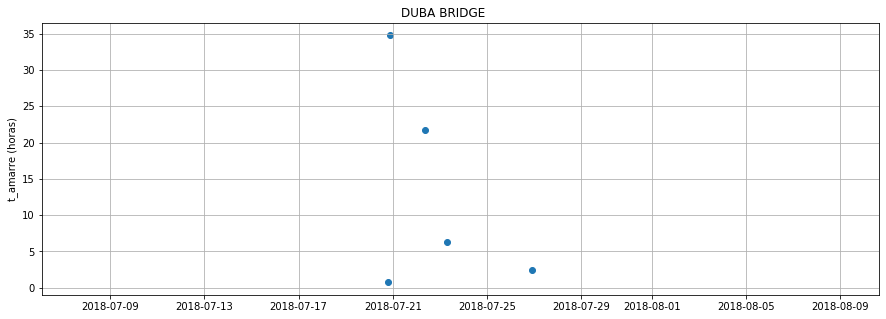

In [176]:
buque = 'DUBA BRIDGE         '

# x = np.arange(len(ferris_ro[ferris_ro.Buque == 'FORZA               ']))+1
x = ferris_ro['FH. Amarre Calc'][ferris_ro.Buque == buque]
y = ferris_ro['Amarre calculado (horas)'][ferris_ro.Buque == buque]

figure(figsize=(15,5))
plt.scatter(x,y)
plt.title(buque)
plt.ylabel('t_amarre (horas)')
# plt.set_xlabel('n_escalas')
plt.grid()
# plt.set_xlim([0,10])
# plt.ylim([0,20])

In [182]:
ferris_ro_balea[['Amarre calculado (horas)','Buque']][(ferris_ro_balea.Buque == 'VISEMAR ONE         ')|
        
                                (ferris_ro_balea.Buque == 'NAPOLES             ')|
                                (ferris_ro_balea.Buque == 'SICILIA             ')|
                                (ferris_ro_balea.Buque == 'ABEL MATUTES        ')|
                                (ferris_ro_balea.Buque == 'HEDY LAMARR         ')| 
                                (ferris_ro_balea.Buque == 'HYPATIA  ALEJANDRIA ')|
                                (ferris_ro_balea.Buque == 'REGINA BALTICA      ')].groupby('Buque').describe().round(2)

Amarre calculado (horas)                             \
                                        count   mean     std   min   25%   
Buque                                                                      
ABEL MATUTES                            277.0  17.59  139.38  0.92  1.75   
HEDY LAMARR                             296.0   7.98    9.38  1.75  3.17   
HYPATIA  ALEJANDRIA                     192.0   4.31    6.40  0.42  2.17   
NAPOLES                                 370.0   4.24    7.12  0.83  1.75   
REGINA BALTICA                          414.0  13.60   60.51  0.75  7.67   
SICILIA                                 101.0  11.04   11.39  0.17  2.00   
VISEMAR ONE                             535.0   7.37    9.12  1.08  3.17   

                                            
                       50%    75%      max  
Buque                                       
ABEL MATUTES          2.17   3.00  1926.67  
HEDY LAMARR           3.42   3.83    27.92  
HYPATIA  ALEJANDRIA   2.33   2.67    27.42  
NAPOLES               2.00   2.25    47.50  
REGINA BALTICA        8.42   9.08  1229.25  
SICILIA               2.33  25.67    26.75  
VISEMAR ONE           3.42   3.67    51.42

In [216]:
ferris_ro_balea[['Amarre calculado (horas)','Clave Lloyd o Num. OMI']][(ferris_ro_balea.Buque == 'VISEMAR ONE         ')|
        
                                (ferris_ro_balea.Buque == 'NAPOLES             ')|
                                (ferris_ro_balea.Buque == 'SICILIA             ')|
                                (ferris_ro_balea.Buque == 'ABEL MATUTES        ')|
                                (ferris_ro_balea.Buque == 'HEDY LAMARR         ')| 
                                (ferris_ro_balea.Buque == 'HYPATIA  ALEJANDRIA ')|
                                (ferris_ro_balea.Buque == 'REGINA BALTICA      ')].groupby('Clave Lloyd o Num. OMI').describe().round(2)

Amarre calculado (horas)                             \
                                          count   mean     std   min   25%   
Clave Lloyd o Num. OMI                                                       
7827225                                   414.0  13.60   60.51  0.75  7.67   
9243423                                   370.0   4.24    7.12  0.83  1.75   
9261542                                   101.0  11.04   11.39  0.17  2.00   
9441130                                   277.0  17.59  139.38  0.92  1.75   
9498743                                   831.0   7.59    9.21  1.08  3.17   
9498755                                   192.0   4.31    6.40  0.42  2.17   

                                              
                         50%    75%      max  
Clave Lloyd o Num. OMI                        
7827225                 8.42   9.08  1229.25  
9243423                 2.00   2.25    47.50  
9261542                 2.33  25.67    26.75  
9441130                 2.17   3.00  1926.67  
9498743                 3.42   3.75    51.42  
9498755                 2.33   2.67    27.42

In [183]:
ferris_ro_balea[['Amarre calculado (horas)','Buque']].groupby('Buque').describe().round(2)

Amarre calculado (horas)                             \
                                        count   mean     std   min   25%   
Buque                                                                      
ABEL MATUTES                            277.0  17.59  139.38  0.92  1.75   
BAHAMA MAMA                              47.0   7.03    4.06  0.67  2.50   
DENIA CIUTAT CREATIV                     62.0  15.90   38.48  1.33  2.58   
DUBA BRIDGE                               5.0  13.18   14.62  0.75  2.42   
HEDY LAMARR                             296.0   7.98    9.38  1.75  3.17   
HYPATIA  ALEJANDRIA                     192.0   4.31    6.40  0.42  2.17   
JAUME II                                 16.0   1.60    0.23  1.08  1.50   
JAUME III                                36.0  18.14  102.69  0.67  0.92   
MARIE CURIE                              73.0   6.33   22.48  0.67  2.42   
NAPOLES                                 370.0   4.24    7.12  0.83  1.75   
REGINA BALTICA                          414.0  13.60   60.51  0.75  7.67   
ROSALIND FRANKLIN                        60.0   4.56    5.82  1.50  2.67   
SICILIA                                 101.0  11.04   11.39  0.17  2.00   
VISEMAR ONE                             535.0   7.37    9.12  1.08  3.17   

                                            
                       50%    75%      max  
Buque                                       
ABEL MATUTES          2.17   3.00  1926.67  
BAHAMA MAMA           9.58   9.79    18.50  
DENIA CIUTAT CREATIV  8.46  12.73   297.83  
DUBA BRIDGE           6.33  21.67    34.75  
HEDY LAMARR           3.42   3.83    27.92  
HYPATIA  ALEJANDRIA   2.33   2.67    27.42  
JAUME II              1.62   1.69     2.17  
JAUME III             1.00   1.17   617.17  
MARIE CURIE           2.67   3.00   190.83  
NAPOLES               2.00   2.25    47.50  
REGINA BALTICA        8.42   9.08  1229.25  
ROSALIND FRANKLIN     3.00   3.17    26.92  
SICILIA               2.33  25.67    26.75  
VISEMAR ONE           3.42   3.67    51.42

In [215]:
ferris_ro.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 25'],
      dtype='object')

### Proves simultaneitat

In [12]:
dfIN = ferris_ro[['FH. Amarre Calc','Paux_b(kW)']]
dfOUT = ferris_ro[['FH. Desamarre Calc','Paux_b(kW)']]
dfIN['direction'] = 1
dfOUT['direction'] = -1

In [13]:
dfIN.columns = ('TS','pot_media','direction')
dfOUT.columns = ('TS','pot_media','direction')

In [14]:
traffic = pd.concat([dfIN, dfOUT]).sort_values('TS')

In [15]:
traffic.pot_media = traffic.pot_media*traffic.direction

In [16]:
traffic['ships'] = traffic['direction'].cumsum()
traffic['cum_pot'] = traffic['pot_media'].cumsum()

In [17]:
traffic = traffic.round()

(736664.0, 736695.0)

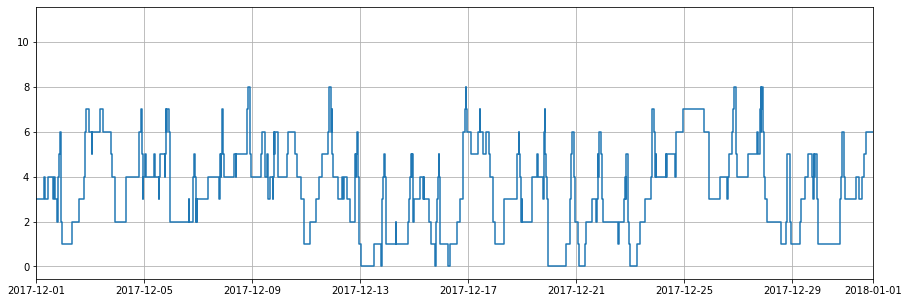

In [156]:
figure(figsize=(15,5))

plt.step(traffic.TS,traffic.ships, where='post')
plt.grid(True)
plt.xlim(['2017-01-20','2017-01-21'])
plt.xlim(['2017-12-01','2018-01-01'])


(736664.0, 736695.0)

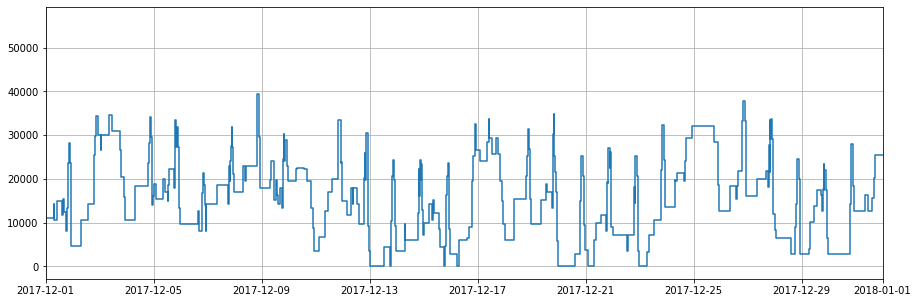

In [175]:
a = figure(figsize=(15,5))

plt.step(traffic.TS,traffic.cum_pot, where='post')
plt.grid(True)
plt.xlim(['2017-12-01','2018-01-01'])
# plt.xlim(['2017-01-20 18','2017-01-20 22'])
# plt.ylim([10000,30000])

In [58]:
traffic.iloc[215:225]

,TS,pot_media,direction,ships,cum_pot
132,2017-01-20 00:45:00,-5566.0,-1,4,18645.0
92,2017-01-20 01:00:00,-5229.0,-1,3,13416.0
147,2017-01-20 14:25:00,801.0,1,4,14217.0
109,2017-01-20 15:05:00,2227.0,1,5,16444.0
96,2017-01-20 18:50:00,-3738.0,-1,4,12706.0
123,2017-01-20 18:50:00,2614.0,1,5,15319.0
102,2017-01-20 19:15:00,-3572.0,-1,4,11747.0
93,2017-01-20 20:10:00,5229.0,1,5,16976.0
101,2017-01-20 20:25:00,4574.0,1,6,21550.0
150,2017-01-20 20:50:00,3028.0,1,7,24577.0


In [280]:
traffic_trasme[(traffic_trasme.TS > '2017-01-20 18:00') & (traffic_trasme.TS < '2017-01-20 19:00')]

,TS,pot_media,direction,ships,cum_pot
33,2017-01-20 18:50:00,163.0,1,2,297.0


In [281]:
traffic_b[traffic_b.TS == '2017-01-20 18:50']

,TS,pot_media,direction,ships,cum_pot
39,2017-01-20 18:50:00,-213.0,-1,0,-0.0


## VTE (Ro-Ro)

### Descripción general

In [13]:
vte.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)'],
      dtype='object')

In [9]:
vte.describe()

,Año Servicio,Clave Lloyd o Num. OMI,Det. G.T. Buque,Num. Atraque,Power (kW),Potencia,Hora de Fin del Servicio,Hora de Inicio del Servicio,Amarre calculado (horas)
count,2201.000000,2.201000e+03,2201.000000,2201.000000,0.0,2201.000000,2201.000000,2201.000000,2201.000000
mean,2017.980918,9.371863e+06,38092.215811,1.050886,NaN,17869.323944,1226.039982,1207.471149,16.590542
std,0.818313,1.768186e+05,9213.306088,0.247074,NaN,7390.086630,608.219327,607.878091,19.672018
min,2017.000000,8.020599e+06,9600.000000,1.000000,NaN,1600.000000,5.000000,0.000000,0.250000
25%,2017.000000,9.247936e+06,32645.000000,1.000000,NaN,12640.000000,715.000000,655.000000,8.750000
50%,2018.000000,9.451719e+06,32647.000000,1.000000,NaN,19334.000000,1300.000000,1245.000000,12.416667
75%,2019.000000,9.465538e+06,44408.000000,1.000000,NaN,20070.000000,1735.000000,1720.000000,17.583333
max,2019.000000,9.784051e+06,76420.000000,4.000000,NaN,45000.000000,2359.000000,2355.000000,366.166667


### Consumos en escala

In [77]:
roro_eurocargo = 700                     # kW 
car_baltimora = 800                     # kW 
car_detroit = 650                     # kW 

In [121]:
vte['Potencia_kW']=""

# potencia roro
vte.Potencia_kW = pot_roro

In [128]:
(buques.buque_def=='roro')

0        False
1        False
2        False
3        False
4        False
         ...  
19840    False
19841    False
19842    False
19843    False
19844    False
Name: buque_def, Length: 19845, dtype: bool

In [32]:
# Eurocargo (Grimaldi) = 700
buques.Potencia_kW[(buques.buque_def=='roro') & (buques.Buque.str.contains("EUROC"))] = 700
# Grande Baltimora (Grimaldi) = 800
buques.Potencia_kW[(buques.buque_def=='roro') & (buques['Det. G.T. Buque']>40000) &
                   ((buques.Buque.str.contains("GRAND")) | (buques.Buque.str.contains("GRAN BRETAGNA")))] = 800
# Grande Detroit (Grimaldi) = 650
buques.Potencia_kW[(buques.buque_def=='roro') & (buques['Det. G.T. Buque']<40000) &
                   (buques.Buque.str.contains("GRAND"))] = 650
#----------------------------------#
# HOEGH = 800
buques.Potencia_kW[(buques.buque_def=='roro') & 
                   ((buques.Buque.str.contains("HOEGH")) | (buques.Buque.str.contains("HÖEGH")))] = 800
# Neptune = 650
buques.Potencia_kW[(buques.buque_def=='roro') & (buques.Buque.str.contains("NEPTUNE"))] = 650
#

NameError: name 'buques' is not defined

In [196]:
buques['Det. G.T. Buque'][(buques.buque_def=='roro') & (buques.Buque.str.contains("NEPTUNE"))].describe()

count      131.000000
mean     34520.465649
std       5019.744101
min      19220.000000
25%      36711.000000
50%      36825.000000
75%      36825.000000
max      37602.000000
Name: Det. G.T. Buque, dtype: float64

array([47020., 51925., 16361., 17505., 59835., 41000., 41009., 29874.,
       46800., 56973., 37237., 57280., 62105., 20381., 58107.,  9600.,
       40986., 60876., 57692., 36711., 44408., 33823., 47057., 72700.,
       40628., 36834., 39362., 61804., 59694., 69931., 58329., 62838.,
       60131., 58752., 58250., 43810., 57030., 11197., 47053., 60118.,
       58917., 14411., 30998.])

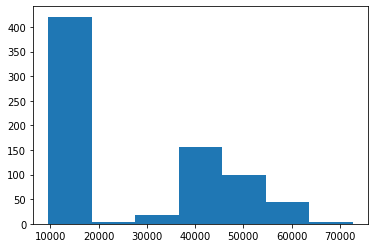

In [180]:

plt.hist(buques['Det. G.T. Buque'][(buques.buque_def=='roro') & (buques.Potencia_kW>499) & (buques.Potencia_kW<501)],bins=7)
buques['Det. G.T. Buque'][(buques.buque_def=='roro') & (buques.Potencia_kW>499) & (buques.Potencia_kW<501)].unique()

In [198]:
#buques['Det. G.T. Buque'][(buques.buque_def=='roro') & 
#                          (buques.Potencia_kW>499) & (buques.Potencia_kW<501) &
#                          (buques['Det. G.T. Buque']<25000)]
buques.Potencia_kW[(buques.buque_def=='roro') & 
                   (buques.Potencia_kW>499) & (buques.Potencia_kW<501) &
                   (buques['Det. G.T. Buque']>25000) & (buques['Det. G.T. Buque']<45000)] = 650 # kW

buques.Potencia_kW[(buques.buque_def=='roro') & 
                   (buques.Potencia_kW>499) & (buques.Potencia_kW<501) &
                   (buques['Det. G.T. Buque']>=45000)] = 800                                    # kW


In [204]:
buques.Potencia_kW[(buques.buque_def=='roro')]

30       650
31       800
133      800
145      650
151      800
        ... 
19830    800
19831    700
19832    700
19833    650
19834    700
Name: Potencia_kW, Length: 2610, dtype: object

In [165]:
buques[buques.buque_def=='roro']

Año Servicio                            int64
Id.Escala                              object
Clave Lloyd o Num. OMI                  int32
Buque                                  object
Tipo Buque                             object
Det. G.T. Buque                       float64
Num. Atraque                            int64
Power (kW)_x                          float64
Potencia                              float64
Muelle Atraque Real                    object
Tipo Maniobra                          object
Fecha de Fin del Servicio      datetime64[ns]
Hora de Fin del Servicio                int64
Fecha de Inicio de Servicio    datetime64[ns]
Hora de Inicio del Servicio             int64
FH. Amarre Calc                datetime64[ns]
FH. Desamarre Calc                     object
Amarre calculado (horas)              float64
GT*t                                  float64
Potencia*atraque                      float64
GT*atraque                            float64
Paux_a(kW)                        

In [80]:
%store buques

Stored 'buques' (DataFrame)


## Otros

### Hotelling

In [123]:
otros.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)'],
      dtype='object')

In [125]:
otros['Tipo Buque'].unique()

array(['OTROS GRANELEROS         ', 'PRODUCTOS QUÍMICOS       ',
       'ASFÁLTICO                ', 'CEMENTERO                ',
       'PETROLERO REFINADO       ', 'GRANELERO/CONTENEDOR     ',
       'POLIV. GENERAL CONTENEDOR', 'MERCANT. CONVENCIONAL    ',
       'CEREALERO                ', 'OTROS MERCANTES          ',
       'GAS LICUADO              ', 'BUQUE TANQUE/MG          ',
       'PETROLERO NO REFINADO    ', 'OTROS BUQUES             ',
       'ACEITEROS                '], dtype=object)

In [133]:
otros['Tipo Buque'].isin(['PRODUCTOS QUÍMICOS       ','ASFÁLTICO                ',
                                'CEMENTERO                ','PETROLERO REFINADO       ',
                                'GAS LICUADO              ', 'BUQUE TANQUE/MG          ',
                                'PETROLERO NO REFINADO    ','ACEITEROS                '])

0      False
1      False
2       True
3       True
4      False
       ...  
674     True
675     True
676     True
677    False
678     True
Name: Tipo Buque, Length: 679, dtype: bool

In [16]:
# hotelling

#tankers

liquid_aux_main = 0.3
liquid_mano_time = 1
liquid_load_main = 0.2
liquid_time_main = 1
liquid_load_aux = 0.6

# except tankers

dry_aux_main = 0.3
dry_mano_time = 1
dry_load_main = 0.2
dry_time_main = 0.05
dry_load_aux = 0.4

# general_aux_main = 0.23
# general_mano_time = 1
# general_load_main = 0.2
# general_time_main = 0.05
# general_load_aux = 0.4

In [17]:
buques_vessl_ihs['Tipo Buque'][buques_vessl_ihs.buque_def=='otros'].unique()

array(['OTROS GRANELEROS         ', 'PRODUCTOS QUÍMICOS       ',
       'ASFÁLTICO                ', 'CEMENTERO                ',
       'PETROLERO REFINADO       ', 'GRANELERO/CONTENEDOR     ',
       'CEREALERO                ', 'GAS LICUADO              ',
       'BUQUE TANQUE/MG          ', 'PETROLERO NO REFINADO    ',
       'OTROS BUQUES             ', 'ACEITEROS                '],
      dtype=object)

In [22]:
buques_vessl_ihs.Potencia_kW[buques_vessl_ihs['Tipo Buque'].isin(['PRODUCTOS QUÍMICOS       ','ASFÁLTICO                ',
                                                                  'CEMENTERO                ','PETROLERO REFINADO       ',
                                                                  'GAS LICUADO              ', 'BUQUE TANQUE/MG          ',
                                                                  'PETROLERO NO REFINADO    ','ACEITEROS                '])
] = buques_vessl_ihs.Potencia*[liquid_load_main*liquid_time_main + liquid_aux_main*liquid_load_aux]
    
buques_vessl_ihs.Potencia_kW[buques_vessl_ihs['Tipo Buque'].isin(['CEREALERO                ','GRANELERO/CONTENEDOR     ',
                                                                  'OTROS GRANELEROS         ','OTROS BUQUES             '])
] = buques_vessl_ihs.Potencia*[dry_load_main*dry_time_main + dry_aux_main*dry_load_aux]

# otros.Potencia_kW[otros['Tipo Buque'].isin(['POLIV. GENERAL CONTENEDOR', 'MERCANT. CONVENCIONAL    ',
#                                             , 'OTROS MERCANTES          '])] = otros.Potencia*[
#     general_load_main*general_time_main + general_aux_main*general_load_aux]

In [24]:
buques_vessl_ihs.Potencia_kW[buques_vessl_ihs.buque_def=='otros'].mean()

1709.5786099585075

In [149]:
#otros['Potencia_kW']=""

#otros.Potencia_kW[otros['Tipo Buque'].isin(['PRODUCTOS QUÍMICOS       ','ASFÁLTICO                ',
#                                             'CEMENTERO                ','PETROLERO REFINADO       ',
#                                             'GAS LICUADO              ', 'BUQUE TANQUE/MG          ',
#                                             'PETROLERO NO REFINADO    ',
#                                             'ACEITEROS                '])] = otros.Potencia*[
#    liquid_load_main*liquid_time_main + liquid_aux_main*liquid_load_aux]
    
#otros.Potencia_kW[otros['Tipo Buque'].isin(['CEREALERO                ','GRANELERO/CONTENEDOR     ',
#                                             'OTROS GRANELEROS         '])] = otros.Potencia*[
#    dry_load_main*dry_time_main + dry_aux_main*dry_load_aux]

#otros.Potencia_kW[otros['Tipo Buque'].isin(['POLIV. GENERAL CONTENEDOR', 'MERCANT. CONVENCIONAL    ',
#                                             'OTROS BUQUES             ', 'OTROS MERCANTES          ',])] = otros.Potencia*[
#    general_load_main*general_time_main + general_aux_main*general_load_aux]


C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\badria\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [279]:
otros.Potencia_kW.mean()

1314.8929455081

## Totales

In [6]:
buques_vessl_ihs.columns

Index(['Año Servicio', 'Id.Escala', 'Clave Lloyd o Num. OMI', 'Buque',
       'Tipo Buque', 'Det. G.T. Buque', 'Num. Atraque', 'Power (kW)',
       'Potencia', 'Muelle Atraque Real', 'Tipo Maniobra',
       'Fecha de Fin del Servicio', 'Hora de Fin del Servicio',
       'Fecha de Inicio de Servicio', 'Hora de Inicio del Servicio',
       'FH. Amarre Calc', 'FH. Desamarre Calc', 'Amarre calculado (horas)',
       'GT*t', 'Potencia*atraque', 'GT*atraque', 'Paux_a(kW)', 'Paux_b(kW)',
       'Paux_a*t (kWh)', 'Paux_b*t (kWh)', 'Unnamed: 25', 'Potencia_kW',
       'terminal', 'buque_def', 'IMO', 'TotalPower', 'GT', 'Manoeuvring'],
      dtype='object')

In [13]:
buques_vessl_ihs[buques_vessl_ihs.buque_def=='otros'].mean()

Año Servicio                   2.018031e+03
Clave Lloyd o Num. OMI         9.299284e+06
Det. G.T. Buque                1.327594e+04
Num. Atraque                   1.159751e+00
Power (kW)                              NaN
Potencia                       6.596324e+03
Hora de Fin del Servicio       1.205967e+03
Hora de Inicio del Servicio    1.196141e+03
Amarre calculado (horas)       6.535138e+01
GT*t                                    NaN
Potencia*atraque                        NaN
GT*atraque                              NaN
Paux_a(kW)                              NaN
Paux_b(kW)                              NaN
Paux_a*t (kWh)                          NaN
Paux_b*t (kWh)                          NaN
Unnamed: 25                             NaN
Potencia_kW                    1.709579e+03
IMO                            9.600514e+06
TotalPower                     6.578000e+03
GT                             4.352500e+03
dtype: float64

### Manoeuvring (EEA/EMEP)

In [208]:
# manoeuvring 

liquid_aux_main = 0.3
liquid_mano_time = 1
liquid_load_main = 0.2
liquid_time_main = 1
liquid_load_aux = 0.5

dry_aux_main = 0.3
dry_mano_time = 1
dry_load_main = 0.2
dry_time_main = 1
dry_load_aux = 0.5

container_aux_main = 0.25
container_mano_time = 1
container_load_main = 0.2
container_time_main = 1
container_load_aux = 0.5

roro_aux_main = 0.24
roro_mano_time = 1
roro_load_main = 0.2
roro_time_main = 1
roro_load_aux = 0.5

passenger_aux_main = 0.16
passenger_mano_time = 0.8
passenger_load_main = 0.2
passenger_time_main = 1
passenger_load_aux = 0.5

In [73]:
buques.Manoeuvring.mean()

7955.391577727602

In [217]:
buques_vessl_ihs['Manoeuvring']=""

In [72]:
# calculo manoeuvring EEA, con potencias reales

# otros (bulk liquid)
buques.Manoeuvring[buques['Tipo Buque'].isin(['PRODUCTOS QUÍMICOS       ','ASFÁLTICO                ',
                                                                  'CEMENTERO                ','PETROLERO REFINADO       ',
                                                                  'GAS LICUADO              ', 'BUQUE TANQUE/MG          ',
                                                                  'PETROLERO NO REFINADO    ','ACEITEROS                '])
] = buques.Potencia*[liquid_load_main*liquid_time_main + liquid_aux_main*liquid_load_aux]
# otros (bulk dry)    
buques.Manoeuvring[buques['Tipo Buque'].isin(['CEREALERO                ','GRANELERO/CONTENEDOR     ',
                                                                  'OTROS GRANELEROS         ','OTROS BUQUES             '])
] = buques.Potencia*[dry_load_main*dry_time_main + dry_aux_main*dry_load_aux]
# contenedores
buques.Manoeuvring[buques.buque_def=='contenedor'
                            ] = buques.Potencia*[container_load_main*container_time_main +
                                                           container_aux_main*container_load_aux]
# ropax y cruceros
buques.Manoeuvring[(buques.buque_def=='ropax')|(buques.buque_def=='crucero')
                            ] = buques.Potencia*[passenger_load_main*passenger_time_main +
                                                           passenger_aux_main*passenger_load_aux]*passenger_mano_time # 0.8 h
# roro
buques.Manoeuvring[buques.buque_def=='roro'
                            ] = buques.Potencia*[roro_load_main*roro_time_main +
                                                           roro_aux_main*roro_load_aux]


In [209]:
# totales manoeuvring

for i in buques['Año Servicio'].unique():
    for j in buques.buque_def.unique():
        print( str(i) + '  ' + str(j) + ' -- ' +
               str(round(buques.Manoeuvring[(buques['Año Servicio']==i) & 
                                                     (buques.buque_def== str(j))].sum()/1e6,2))
               + " GWh")
    print('\n')
    print(str(i) + '   ' +  str(round(buques.Manoeuvring[buques['Año Servicio']==i].sum()/1e6,2))+ " GWh")
    print('\n')

2017  contenedor -- 37.5 GWh
2017  roro -- 5.14 GWh
2017  otros -- 0.36 GWh
2017  ropax -- 6.93 GWh
2017  crucero -- 1.93 GWh


2017   51.86 GWh


2018  contenedor -- 38.51 GWh
2018  roro -- 4.98 GWh
2018  otros -- 0.37 GWh
2018  ropax -- 7.28 GWh
2018  crucero -- 1.76 GWh


2018   52.91 GWh


2019  contenedor -- 38.62 GWh
2019  roro -- 5.05 GWh
2019  otros -- 0.38 GWh
2019  ropax -- 7.26 GWh
2019  crucero -- 1.8 GWh


2019   53.11 GWh




### Hotelling

In [205]:
# totales hotelling (tipo buque)

for i in buques['Año Servicio'].unique():
    for j in buques.buque_def.unique():
        print( str(i) + '  ' + str(j) + ' -- ' +
               str(round(((buques.Potencia_kW[(buques['Año Servicio']==i) & 
                                                     (buques.buque_def== str(j))])*(
                   buques['Amarre calculado (horas)'][(buques['Año Servicio']==i) & 
                                                     (buques.buque_def== str(j))])).sum()/1e6,2))
               + " GWh")
    print('\n')
    print(str(i) + '   ' +  
          str(round(((buques.Potencia_kW[buques['Año Servicio']==i])*(
                      buques['Amarre calculado (horas)'][buques['Año Servicio']==i])).sum()/1e6,2)) +
          " GWh")
    print('\n')

2017  contenedor -- 84.89 GWh
2017  roro -- 10.61 GWh
2017  otros -- 13.78 GWh
2017  ropax -- 6.67 GWh
2017  crucero -- 15.4 GWh


2017   131.35 GWh


2018  contenedor -- 86.36 GWh
2018  roro -- 9.69 GWh
2018  otros -- 13.91 GWh
2018  ropax -- 6.3 GWh
2018  crucero -- 13.2 GWh


2018   129.46 GWh


2019  contenedor -- 87.81 GWh
2019  roro -- 9.44 GWh
2019  otros -- 14.87 GWh
2019  ropax -- 6.39 GWh
2019  crucero -- 13.51 GWh


2019   132.02 GWh




In [206]:
# totales hotelling (por terminal)

for i in buques['Año Servicio'].unique():
    for j in buques.terminal.unique():
        print( str(i) + '  ' + str(j) + ' -- ' +
               str(round(((buques.Potencia_kW[(buques['Año Servicio']==i) & 
                                                     (buques.terminal== str(j))])*(
                   buques['Amarre calculado (horas)'][(buques['Año Servicio']==i) & 
                                                     (buques.terminal== str(j))])).sum()/1e6,2))
               + " GWh")
    print('\n')
    print(str(i) + '   ' +  
          str(round(((buques.Potencia_kW[buques['Año Servicio']==i])*(
                      buques['Amarre calculado (horas)'][buques['Año Servicio']==i])).sum()/1e6,2)) +
          " GWh")
    print('\n')

2017  apm -- 23.72 GWh
2017  csp -- 43.69 GWh
2017  msc -- 17.79 GWh
2017  vte -- 13.4 GWh
2017  balea_otros -- 14.77 GWh
2017  trasme_cru -- 11.34 GWh
2017  ampli_norte -- 6.64 GWh


2017   131.35 GWh


2018  apm -- 26.57 GWh
2018  csp -- 45.07 GWh
2018  msc -- 14.43 GWh
2018  vte -- 11.03 GWh
2018  balea_otros -- 16.64 GWh
2018  trasme_cru -- 9.49 GWh
2018  ampli_norte -- 6.22 GWh


2018   129.46 GWh


2019  apm -- 26.2 GWh
2019  csp -- 44.54 GWh
2019  msc -- 17.32 GWh
2019  vte -- 10.97 GWh
2019  balea_otros -- 16.85 GWh
2019  trasme_cru -- 8.98 GWh
2019  ampli_norte -- 7.16 GWh


2019   132.02 GWh




In [207]:
# totales hotelling (por muelle)

for i in buques['Año Servicio'].unique():
    for j in buques['Muelle Atraque Real'].unique():
        print( str(i) + '  ' + str(j) + ' -- ' +
               str(round(((buques.Potencia_kW[(buques['Año Servicio']==i) & 
                                                     (buques['Muelle Atraque Real']== str(j))])*(
                   buques['Amarre calculado (horas)'][(buques['Año Servicio']==i) & 
                                                     (buques['Muelle Atraque Real']== str(j))])).sum()/1e6,2))
               + " GWh")
    print('\n')
    print(str(i) + '   ' +  
          str(round(((buques.Potencia_kW[buques['Año Servicio']==i])*(
                      buques['Amarre calculado (horas)'][buques['Año Servicio']==i])).sum()/1e6,2)) +
          " GWh")
    print('\n')

2017  LLOVERA                   -- 9.89 GWh
2017  LEVANTE 1                 -- 8.15 GWh
2017  LEVANTE 3                 -- 2.7 GWh
2017  PRINCIPE FELIPE           -- 43.68 GWh
2017  LEVANTE 2                 -- 0.88 GWh
2017  TRANSVERSAL COSTA         -- 17.79 GWh
2017  LEVANTE 4                 -- 2.11 GWh
2017  DIQUE DEL ESTE            -- 6.94 GWh
2017  SUR                       -- 9.91 GWh
2017  TURIA                     -- 1.72 GWh
2017  ESP.TUR.SUR-1             -- 2.06 GWh
2017  ESP.TUR.SUR-2             -- 0.21 GWh
2017  PONIENTE-1                -- 5.19 GWh
2017  TRANSVERSALES             -- 3.16 GWh
2017  NORTE(XITA)               -- 4.4 GWh
2017  TRANSV. DIQUE DEL ESTE    -- 2.07 GWh
2017  ESP.TUR.TESTERO           -- 0.86 GWh
2017  PONIENTE-2                -- 2.99 GWh
2017  CRUCEROS DOS              -- 6.25 GWh
2017  M. ESTE (PRINCIPE FELIPE) -- 0.01 GWh
2017  CRUCEROS UNO              -- 0.39 GWh
2017  ESP.TUR.NORTE-1           -- 0.0 GWh
2017  ESP.TUR.NORTE-2           -

### Outdated

In [199]:

print("Consumos Otros (hotelling + manoeuvring)")
print("----------------------------------------")

print("liquid")
print(str(round((6543*0.2 + 6543*0.3*0.6)*30.53*74/1e6,2)) + " GWh")
print(round((6543*0.2 + 6543*0.3*0.5)*74/1e6,2))
print("")
print("solid")
print(str(round((4397*0.2*0.05 + 4397*0.3*0.4)*97.75*90/1e6,2)) + " GWh")
print(round((4397*0.2 + 4397*0.3*0.5)*90/1e6,2))
print("")
print("general")
print(str(round((2555*0.2*0.05 + 2555*0.23*0.4)*55.01*80/1e6,2)) + " GWh")
print(round((2555*0.2 + 2555*0.23*0.5)*80/1e6,2))
print("")

print ("---------------------------")

print("TOTAL")
print(str(round(((6543*0.2 + 6543*0.3*0.6)*30.53*74 + (6543*0.2 + 6543*0.3*0.5)*74 + 
                (4397*0.2*0.05 + 4397*0.3*0.4)*97.75*90 + (4397*0.2 + 4397*0.3*0.5)*90 + 
                (2555*0.2*0.05 + 2555*0.23*0.4)*55.01*80 + (2555*0.2 + 2555*0.23*0.5)*80)/1e6, 2)
               ) + " GWh")

print ("---------------------------")
print("")
# media burda
print("Total (aprox)")
print(str(round((4500*0.2*0.05 + 4500*0.3*0.6)*63*244/1e6,2)) + " GWh")
print(round((4500*0.2 + 4500*0.3*0.6)*244/1e6,2))
print("\n")

Consumos Otros (hotelling + manoeuvring)
----------------------------------------
liquid
5.62 GWh
0.17

solid
5.03 GWh
0.14

general
1.15 GWh
0.06

---------------------------
TOTAL
12.17 GWh
---------------------------

Total (aprox)
13.14 GWh
0.42




In [10]:
buques = buques2
del buques2

# Save and load

## Save

In [294]:
%store balearia
%store buques
%store contenedores
%store cruceros
%store trasme
%store vte
%store ro

Stored 'balearia' (DataFrame)
Stored 'buques' (DataFrame)
Stored 'contenedores' (DataFrame)
Stored 'cruceros' (DataFrame)
Stored 'trasme' (DataFrame)
Stored 'vte' (DataFrame)
Stored 'ro' (DataFrame)


In [275]:
%store cont_ihs
%store ihs_db
%store MSC_2018

%store traffic_contenedores
%store traffic_balearia
%store traffic_trasme
%store traffic_MSC_2018

Stored 'cont_ihs' (DataFrame)
Stored 'ihs_db' (DataFrame)


UsageError: Unknown variable 'MSC_2018'


In [28]:
%store buques
%store buques_vessl
%store vessl_jorge
%store buques_vessl_ihs
%store MSC2018_IHS

UsageError: Unknown variable 'buques'


In [149]:
%store buques

Stored 'buques' (DataFrame)


In [31]:
MSC2 = MSC2018_IHS
%store MSC2

Stored 'MSC2' (DataFrame)


## Load

In [20]:
%store -r balearia
# %store -r buques
%store -r contenedores
%store -r cruceros
%store -r trasme
%store -r vte
%store -r ro

In [2]:
%store -r buques
# %store -r buques_vessl
# %store -r MSC2018_IHS
# %store -r traffic_MSC_2018
# %store -r cont_ihs
# %store -r traffic_cont_ihs

no stored variable or alias buques


In [29]:
# %store -r vessl_jorge
%store -r MSC2018_IHS
%store -r MSC_2018

no stored variable MSC_2018


In [9]:

%store -r ihs_db
%store -r MSC_2018
%store -r traffic_contenedores
%store -r traffic_balearia
%store -r traffic_trasme
%store -r traffic_MSC_2018

no stored variable MSC_2018
no stored variable traffic_contenedores
no stored variable traffic_balearia
no stored variable traffic_trasme
no stored variable traffic_MSC_2018


In [1]:
%store -r buques_vessl_ihs

In [1]:
%store -r buques_clean

no stored variable or alias buques_clean
